# Health Insurance Cross Sell Prediction 🏠 🏥

### Author: Marco Greco
### Linkedin: https://www.linkedin.com/in/marcogreco314/

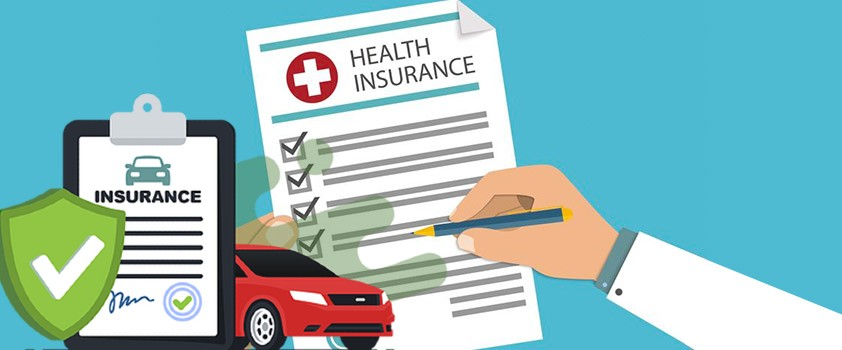

Cross-selling is the sale of additional products or services related to the service/product purchased by the customer or in which the customer has expressed interest.
Our client in question received health insurance from an insurance company and now needs (the insurance company) to build a model that predicts whether the insured (customers) from the past year will also be interested in the car insurance provided by the company.

An insurance policy is an agreement whereby a company agrees to provide a guarantee of compensation for certain losses, damage, illness or death in return for the payment of a certain premium. The premium is a sum of money that the customer has to pay regularly to the insurance company to obtain this guarantee.

For example, one may pay a premium of Rs 5,000 per year for health cover of Rs 200,000, so that if one falls ill and has to be hospitalised in that year, the insurance company will cover the cost of hospitalisation etc. up to Rs 200,000. 

Just like medical insurance, there is car insurance where the customer has to pay a premium of a certain amount to the insurance company every year, so that in the event of an unfortunate accident with the vehicle, the insurance company will provide compensation (called 'sum insured') to the customer.

Building a model to predict whether a customer is interested in vehicle insurance is extremely useful for the company, which can then plan its communication strategy to reach those customers and optimise its business model and revenues.

Predicting whether a customer is interested in vehicle insurance requires demographic information (gender, age, type of regional code), vehicles (vehicle age, damage), policy (premium, sourcing channel), etc.

The basic steps of the project will be as follows:

**1)** Defining the problem <br>
**2)** Obtaining the dataset and having a quick look at the data <br>
**3)** Exploratory data analysis (graph something and see if visual patterns emerge on the data)<br>
**4)** Preparing data for machine learning algorithms (e.g. transform categorical data)<br>
**5)** Select several models and train them<br>
**6)** Fine-tuning the model (go to work on the capabilities of the model to improve it)<br>
**7)** Integrating the model into something bigger for the future<br>

summarised in 3 general steps:

**1)** Pre-processing<br>
**2)** Classification<br>
**3)** Post-processing<br>

First of all, however, I import important libraries for the project:

In [3]:
import os
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from dython.nominal import associations
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler


from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.python.client import device_lib
from tensorflow.keras import regularizers


warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.filterwarnings("ignore", message="numpy.ndarray size changed")
warnings.filterwarnings('ignore')
np.random.seed(42)
sns.set(style="whitegrid")
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID= "progettoDm242455"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "Images")
os.makedirs(IMAGES_PATH, exist_ok=True)

warnings.filterwarnings(action="ignore", message="^internal gelsd")

warnings.filterwarnings('ignore')
# Hrule--> "====="
hrule = lambda x : "="*x

In [4]:
def outliersTodelete(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    
    to_delete = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    
    return to_delete

def firstTen(arr): #for feature selection
    index = {}
    for i in arr:
        index[str(i)]=np.where(i == i)
    arr = sorted(arr, reverse=True)[:10]
    
def ordina_decrescente(clfs, score): #sort models by metric value
    # I use the zip function to combine the two arrays
    combined = zip(score, clfs)
    # I order the combined array based on the second element (numbers)
    sorted_combined = sorted(combined, key=lambda x: x[0])
    sorted_scores = [x[0] for x in sorted_combined]
    # I extract the reordered values from the string array
    sorted_clfs = [x[1] for x in sorted_combined]
    sorted_clfs.reverse()
    sorted_scores.reverse()
    return [sorted_clfs, sorted_scores]

def plot_roc_curve(fpr, tpr, axes, i,label = None):
    axes[i].plot(fpr, tpr, linewidth=2, label=label)
    axes[i].plot([0, 1], [0, 1], 'k--')
    axes[i].axis([0, 1, 0, 1])
    axes[0].set_xlabel('False Positive Rate', fontsize=16)
    axes[0].set_ylabel('True Positive Rate', fontsize=16)


def get_available_devices():
   local_device_protos = device_lib.list_local_devices()
   return [x.name for x in local_device_protos]


## 1) Defining the problem

The dataset has 12 attributes:

1) **id**: Unique customer ID<br>
2) **gender**: Gender of customer<br>
3) **age**: Age of customer<br>
4) **driving_license**: 0 : The customer does not have a driving licence, 1 : The customer has a driving licence<br>
5) **region_code**: Unique customer region code<br>
6) **previously_insured**: 1: The customer already has insurance for the vehicle,0: The customer does not have vehicle insurance<br>
7) **vehicle_age**: Years of the vehicle<br>
8) **vehicle_damage**: 1: The customer has suffered damage to his vehicle in the past, 0: The customer has not suffered damage to the vehicle in the past<br>
9) **annual_premium**: The amount the customer has to pay as a premium during the year<br>
10) **policySalesChannel**: Anonymous code for the customer contact channel, e.g. different agents, mail, telephone, person, etc..<br>
11) **vintage**: Number of days the customer was associated with the company<br>
12) **response**: 1: The customer is interested, 0: The customer is not interested (to take out vehicle insurance)<br>

We are asked to build a model that can predict whether a customer is interested in the car insurance offered by the same company as the health insurance company or not, and the best way to model this problem is to use supervised learning, and in particular the output being discrete data, we make use of **classification**.

## 2) Let's have a quick look at the data

The creator of the dataset provides us with both training set and test set csv files with a 75% - 25% split

In [5]:
plt.style.use('seaborn-notebook')

customers = pd.read_csv('Input/train.csv')
customers_test= pd.read_csv('Input/test.csv')
sample_submission=pd.read_csv('Input/sample_submission.csv')
print(customers.shape)

(381109, 12)


In [6]:
customers_test.shape

(127037, 11)

In [7]:
customers.head()

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   1    Male   44                1         28.0                   0   
1   2    Male   76                1          3.0                   0   
2   3    Male   47                1         28.0                   0   
3   4    Male   21                1         11.0                   1   
4   5  Female   29                1         41.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0   > 2 Years            Yes         40454.0                  26.0      217   
1    1-2 Year             No         33536.0                  26.0      183   
2   > 2 Years            Yes         38294.0                  26.0       27   
3    < 1 Year             No         28619.0                 152.0      203   
4    < 1 Year             No         27496.0                 152.0       39   

   Response  
0         1  
1         0  
2         1  
3         0  
4         0

In [8]:
customers_test.head()

id Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0  381110   Male   25                1         11.0                   1   
1  381111   Male   40                1         28.0                   0   
2  381112   Male   47                1         28.0                   0   
3  381113   Male   24                1         27.0                   1   
4  381114   Male   27                1         28.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  
0    < 1 Year             No         35786.0                 152.0       53  
1    1-2 Year            Yes         33762.0                   7.0      111  
2    1-2 Year            Yes         40050.0                 124.0      199  
3    < 1 Year            Yes         37356.0                 152.0      187  
4    < 1 Year             No         59097.0                 152.0      297

In [9]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


**There are categorical data, such as:**

● Gender<br>
● Vehicle_Age<br>
● Vehicle_Damage<br>


**and numeric attributes**

● id<br>
● Age<br>
● Driving_License<br>
● Region_Code<br>
● Previously_Insured<br>
● Annual_Premium<br>
● Policy_Sales_Channel<br>
● Vintage<br>
● Response<br>

**Also, as can be seen, there are no attributes with null values.**

**indeed:**

In [10]:
customers.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [11]:
customers.describe()

id            Age  Driving_License    Region_Code  \
count  381109.000000  381109.000000    381109.000000  381109.000000   
mean   190555.000000      38.822584         0.997869      26.388807   
std    110016.836208      15.511611         0.046110      13.229888   
min         1.000000      20.000000         0.000000       0.000000   
25%     95278.000000      25.000000         1.000000      15.000000   
50%    190555.000000      36.000000         1.000000      28.000000   
75%    285832.000000      49.000000         1.000000      35.000000   
max    381109.000000      85.000000         1.000000      52.000000   

       Previously_Insured  Annual_Premium  Policy_Sales_Channel  \
count       381109.000000   381109.000000         381109.000000   
mean             0.458210    30564.389581            112.034295   
std              0.498251    17213.155057             54.203995   
min              0.000000     2630.000000              1.000000   
25%              0.000000    24405.000000             29.000000   
50%              0.000000    31669.000000            133.000000   
75%              1.000000    39400.000000            152.000000   
max              1.000000   540165.000000            163.000000   

             Vintage       Response  
count  381109.000000  381109.000000  
mean      154.347397       0.122563  
std        83.671304       0.327936  
min        10.000000       0.000000  
25%        82.000000       0.000000  
50%       154.000000       0.000000  
75%       227.000000       0.000000  
max       299.000000       1.000000

- The presence of different scales can be noted.</br>
- The average of the label suggests an imbalance of classes.</br>
- Furthermore, the attribute Annual_Premium has a maximum value of 540165.0 and an average value of 30564.4, which leads one to think of the presence of outliers.

Furthermore, both the column Region_Code and Policy_Sales_Channel are nothing more than codes replacing the region name and the customer contact channel respectively. Therefore, they should not be left numeric as the model would give more weight to the region_code/Policy_Sales_Channel with a numerically larger code than a smaller one.

**They should be categorical and not numerical attributes!**

N.b. Conversion to categorical attributes will be done after data exploration

In [12]:
customers=customers.astype({"Region_Code":int})
customers_test=customers_test.astype({"Region_Code":int})
customers=customers.astype({"Policy_Sales_Channel":int})
customers_test=customers_test.astype({"Policy_Sales_Channel":int})

In [13]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  int32  
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  int32  
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(1), int32(2), int64(6), object(3)
memory usage: 32.0+ MB


In [14]:
customers_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    127037 non-null  int64  
 1   Gender                127037 non-null  object 
 2   Age                   127037 non-null  int64  
 3   Driving_License       127037 non-null  int64  
 4   Region_Code           127037 non-null  int32  
 5   Previously_Insured    127037 non-null  int64  
 6   Vehicle_Age           127037 non-null  object 
 7   Vehicle_Damage        127037 non-null  object 
 8   Annual_Premium        127037 non-null  float64
 9   Policy_Sales_Channel  127037 non-null  int32  
 10  Vintage               127037 non-null  int64  
dtypes: float64(1), int32(2), int64(5), object(3)
memory usage: 9.7+ MB


To understand whether the test set is well constructed, one can compare the distribution of the train set with that of the test set.

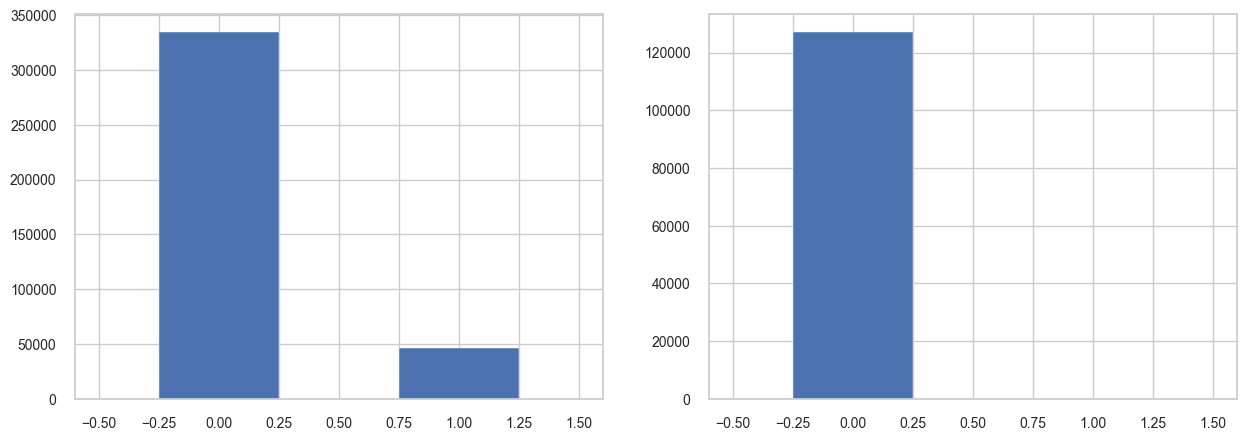

In [15]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15,5)
axes[0].hist(customers["Response"],bins=[-0.5,-0.25,0.25,0.5,0.75,1.25,1.5])
axes[1].hist(sample_submission["Response"],bins=[-0.5,-0.25,0.25,0.5,0.75,1.25,1.5])
plt.show()

As can be seen, the test set is not well constructed</br>.

this can also be seen from the ids which suggest a dry split starting with id 381110

In [16]:
customers['id'].tail(20)

381089    381090
381090    381091
381091    381092
381092    381093
381093    381094
381094    381095
381095    381096
381096    381097
381097    381098
381098    381099
381099    381100
381100    381101
381101    381102
381102    381103
381103    381104
381104    381105
381105    381106
381106    381107
381107    381108
381108    381109
Name: id, dtype: int64

In [17]:
customers_test['id'].head(20)

0     381110
1     381111
2     381112
3     381113
4     381114
5     381115
6     381116
7     381117
8     381118
9     381119
10    381120
11    381121
12    381122
13    381123
14    381124
15    381125
16    381126
17    381127
18    381128
19    381129
Name: id, dtype: int64

I join the sample_submission labels to the test set and then the test set to the training set, in order to perform a split with the function provided by sklearn train_test_split

In [18]:
customers_test2=pd.merge(customers_test,sample_submission,on='id')
customers_test2.head(10)

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0  381110    Male   25                1           11                   1   
1  381111    Male   40                1           28                   0   
2  381112    Male   47                1           28                   0   
3  381113    Male   24                1           27                   1   
4  381114    Male   27                1           28                   1   
5  381115    Male   22                1           30                   1   
6  381116  Female   51                1           37                   1   
7  381117    Male   25                1           41                   1   
8  381118    Male   42                1           41                   0   
9  381119  Female   37                1           12                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0    < 1 Year             No         35786.0                   152       53   
1    1-2 Year            Yes         33762.0                     7      111   
2    1-2 Year            Yes         40050.0                   124      199   
3    < 1 Year            Yes         37356.0                   152      187   
4    < 1 Year             No         59097.0                   152      297   
5    < 1 Year             No         40207.0                   152      266   
6    1-2 Year             No         40118.0                    26      107   
7    < 1 Year             No         23375.0                   152      232   
8    1-2 Year            Yes          2630.0                    26      277   
9    1-2 Year             No         27124.0                   124      133   

   Response  
0         0  
1         0  
2         0  
3         0  
4         0  
5         0  
6         0  
7         0  
8         0  
9         0

In [19]:
print(customers_test.shape)
print(customers_test2.shape)

(127037, 11)
(127037, 12)


In [20]:
dataset=pd.concat([customers,customers_test2],ignore_index=True)
dataset.shape

(508146, 12)

In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508146 entries, 0 to 508145
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    508146 non-null  int64  
 1   Gender                508146 non-null  object 
 2   Age                   508146 non-null  int64  
 3   Driving_License       508146 non-null  int64  
 4   Region_Code           508146 non-null  int32  
 5   Previously_Insured    508146 non-null  int64  
 6   Vehicle_Age           508146 non-null  object 
 7   Vehicle_Damage        508146 non-null  object 
 8   Annual_Premium        508146 non-null  float64
 9   Policy_Sales_Channel  508146 non-null  int32  
 10  Vintage               508146 non-null  int64  
 11  Response              508146 non-null  int64  
dtypes: float64(1), int32(2), int64(6), object(3)
memory usage: 42.6+ MB


In [22]:
dataset.head(10)

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   1    Male   44                1           28                   0   
1   2    Male   76                1            3                   0   
2   3    Male   47                1           28                   0   
3   4    Male   21                1           11                   1   
4   5  Female   29                1           41                   1   
5   6  Female   24                1           33                   0   
6   7    Male   23                1           11                   0   
7   8  Female   56                1           28                   0   
8   9  Female   24                1            3                   1   
9  10  Female   32                1            6                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0   > 2 Years            Yes         40454.0                    26      217   
1    1-2 Year             No         33536.0                    26      183   
2   > 2 Years            Yes         38294.0                    26       27   
3    < 1 Year             No         28619.0                   152      203   
4    < 1 Year             No         27496.0                   152       39   
5    < 1 Year            Yes          2630.0                   160      176   
6    < 1 Year            Yes         23367.0                   152      249   
7    1-2 Year            Yes         32031.0                    26       72   
8    < 1 Year             No         27619.0                   152       28   
9    < 1 Year             No         28771.0                   152       80   

   Response  
0         1  
1         0  
2         1  
3         0  
4         0  
5         0  
6         0  
7         1  
8         0  
9         0

In [23]:
dataset.tail(10)

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
508136  508137    Male   35                1           33                   1   
508137  508138    Male   21                1           46                   1   
508138  508139    Male   64                1           28                   0   
508139  508140  Female   71                1            3                   1   
508140  508141    Male   21                1            8                   1   
508141  508142  Female   26                1           37                   1   
508142  508143  Female   38                1           28                   0   
508143  508144    Male   21                1           46                   1   
508144  508145    Male   71                1           28                   1   
508145  508146    Male   41                1           29                   1   

       Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
508136    1-2 Year             No         28544.0                   124   
508137    < 1 Year             No         30691.0                   160   
508138    1-2 Year             No         39038.0                    26   
508139    1-2 Year             No          2630.0                   124   
508140    < 1 Year             No         35767.0                   152   
508141    < 1 Year             No         30867.0                   152   
508142    1-2 Year            Yes         28700.0                   122   
508143    < 1 Year             No         29802.0                   152   
508144    1-2 Year             No         62875.0                    26   
508145    1-2 Year             No         27927.0                   124   

        Vintage  Response  
508136      133         0  
508137       76         0  
508138       62         0  
508139      147         0  
508140      195         0  
508141       56         0  
508142      165         0  
508143       74         0  
508144      265         0  
508145      231         0

I remove duplicates, as they can cause negative effects during analysis. I then first display the number of duplicates:

In [24]:
print(dataset.duplicated(keep='first').sum()) #n.b. True=1
print(hrule(20))
dataset.shape

0


(508146, 12)

You can see that the number of duplicates in the dataset is zero. Just for exercise and verification, I run the command to delete the duplicates.

In [25]:
dataset.drop_duplicates(keep='first', inplace=True)
dataset.shape

(508146, 12)

The number of tuples remained unchanged => no duplicates

Effettuerò già ora lo split del dataset sia per prevenire un fenomeno noto come data snooping e sia per fare in modo che i dati futuri verranno elaborati esattamente nello stesso modo dei dati di test, garantendo così la coerenza delle prestazioni del modello.

I split the dataset using the sklearn function train_test_split. I choose a 90% - 10% split

In [26]:
train_set, test_set = train_test_split(dataset, test_size=0.1, random_state=42)
print(len(train_set),"train +", len(test_set), "test")

457331 train + 50815 test


I verify that the test set is well constructed by again comparing the distribution of the train set with that of the test set.

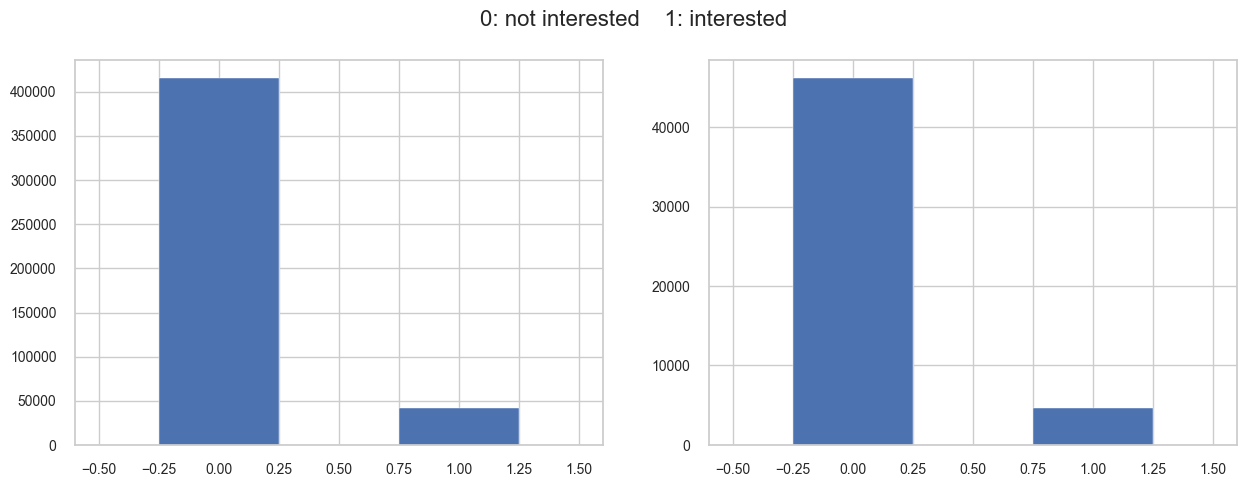

In [27]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15,5)
axes[0].hist(train_set["Response"],bins=[-0.5,-0.25,0.25,0.5,0.75,1.25,1.5])
axes[1].hist(test_set["Response"],bins=[-0.5,-0.25,0.25,0.5,0.75,1.25,1.5])
fig.suptitle('0: not interested    1: interested ', fontsize=16)
plt.show()

OK now here we go.

## 3) Exploratory data analysis

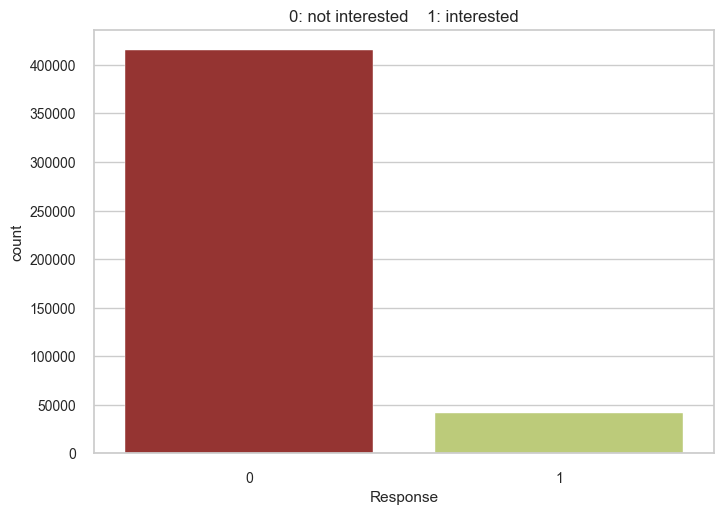

In [28]:
sns.countplot(x="Response",data=train_set,palette=["#A52422","#C5D86D"])
plt.title("0: not interested    1: interested")
plt.show()

In [29]:
train_set.Response.value_counts()

Response
0    415289
1     42042
Name: count, dtype: int64

As we can see, we have a class imbalance problem in this dataset.</br>

One could oversample the minority class, but this is not always the best choice (especially if the object space is very small) as the new samples may be too similar to each other. </br>

In our case we still have 406k tuples, but since the class 'yes' consists of 37k tuples (not a few and sufficient for learning) I will undersample the majority class. But I will do that later.

I now analyse the relationships between the target attribute and other attributes

### Response & Gender

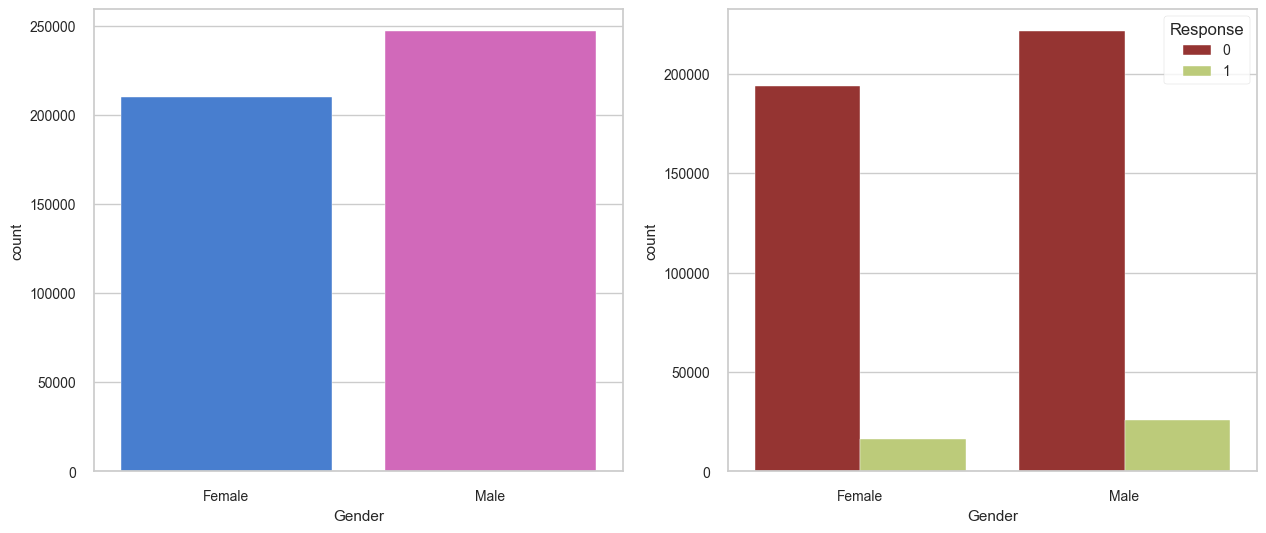

In [30]:
fig, ax =plt.subplots(1,2,figsize = (15,6))
c1=sns.countplot(x=train_set['Gender'],palette=["#3179e6","#E258C4"],ax=ax[0])
c2=sns.countplot(x=train_set['Gender'], hue = train_set['Response'],palette=["#A52422","#C5D86D"],ax=ax[1])
fig.show()

In [31]:
print("Number of males: " + str((train_set.Gender == 'Male').sum()))
print("Number of females: " + str((train_set.Gender == 'Female').sum()))
print("Number of males with response 1: " + str(c2.patches[2].get_height()))
print("Number of females with response 1: " + str(c2.patches[3].get_height()))

Number of males: 247045
Number of females: 210286
Number of males with response 1: 16426.0
Number of females with response 1: 25616.0


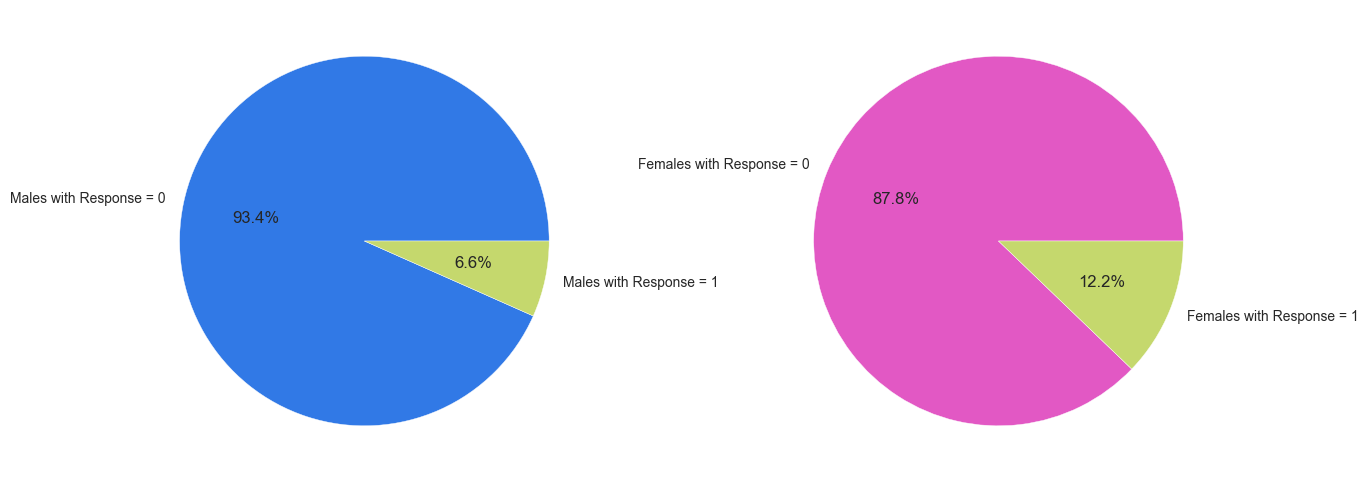

In [32]:
fig, ax =plt.subplots(1,2,figsize = (15,6))
data_m = [(train_set.Gender == 'Male').sum()-c2.patches[2].get_height(),c2.patches[2].get_height()]
keys_m = ['Males with Response = 0','Males with Response = 1']
data_f = [(train_set.Gender == 'Female').sum()-c2.patches[3].get_height(),c2.patches[3].get_height()]
keys_f = ['Females with Response = 0','Females with Response = 1']
ax[0].pie(data_m, labels=keys_m, colors=["#3179e6","#C5D86D"], autopct='%.1f%%')
ax[1].pie(data_f, labels=keys_f, colors=["#E258C4","#C5D86D"], autopct='%.1f%%')
plt.show()

Gender is evenly distributed in the dataset but one can note a slightly higher percentage of women than men in being inclined to take out vehicle insurance with the same company.

### Response & Vehicle_Damage

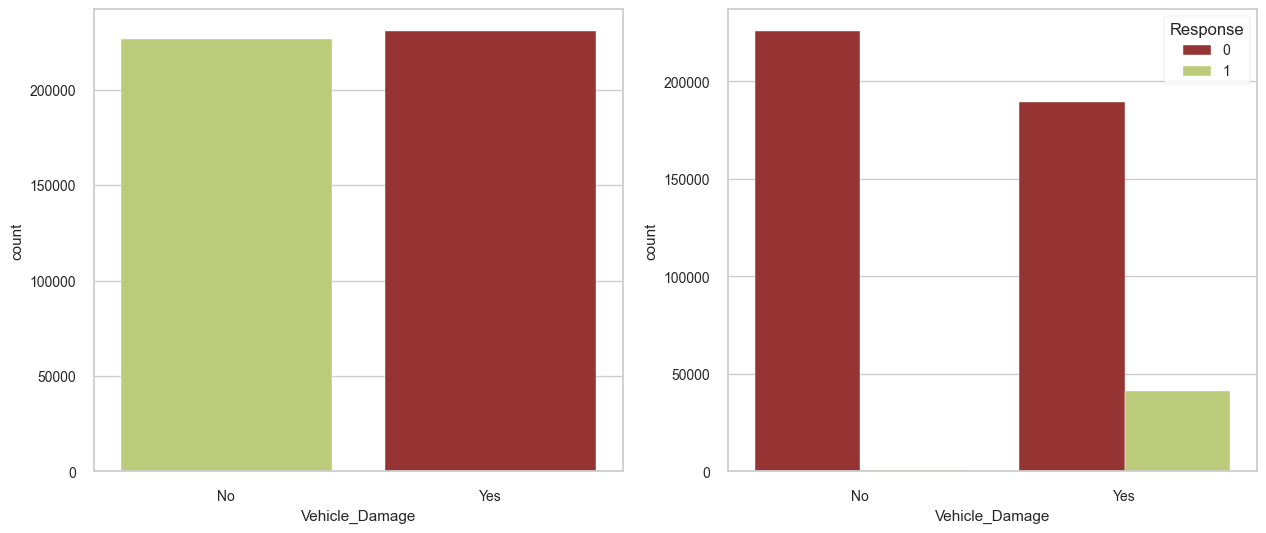

In [33]:
fig, ax =plt.subplots(1,2,figsize = (15,6))
c3=sns.countplot(x=train_set['Vehicle_Damage'],palette=["#C5D86D","#A52422"],ax=ax[0])
c4=sns.countplot(x=train_set['Vehicle_Damage'], hue = train_set['Response'],palette=["#A52422","#C5D86D"],ax=ax[1])
plt.show()

In [34]:
print("Number of damaged vehicles: " + str((train_set.Vehicle_Damage == 'Yes').sum()))
print("Number of non-damaged vehicles: " + str((train_set.Vehicle_Damage == 'No').sum()))
print("Number of non-damaged vehicles with response 1: " + str(c4.patches[2].get_height()))
print("Number of damaged vehicles with response 1: " + str(c4.patches[3].get_height()))

Number of damaged vehicles: 230684
Number of non-damaged vehicles: 226647
Number of non-damaged vehicles with response 1: 890.0
Number of damaged vehicles with response 1: 41152.0


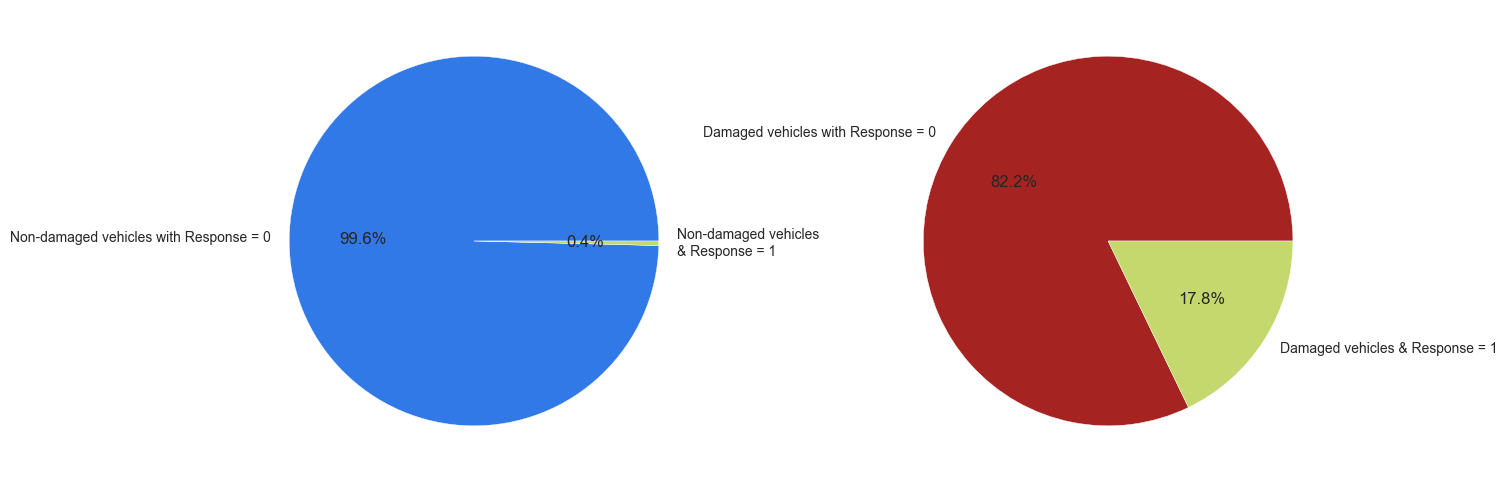

In [35]:
fig, ax =plt.subplots(1,2,figsize = (15,6))
data_nd = [(train_set.Vehicle_Damage == 'No').sum()-c4.patches[2].get_height(),c4.patches[2].get_height()]
keys_nd = ['Non-damaged vehicles with Response = 0','Non-damaged vehicles \n& Response = 1']
data_d = [(train_set.Vehicle_Damage == 'Yes').sum()-c4.patches[3].get_height(),c4.patches[3].get_height()]
keys_d = ['Damaged vehicles with Response = 0','Damaged vehicles & Response = 1']
ax[0].pie(data_nd, labels=keys_nd, colors=["#3179e6","#C5D86D"], autopct='%.1f%%')
ax[1].pie(data_d, labels=keys_d, colors=["#A52422","#C5D86D"], autopct='%.1f%%')
plt.show()

Those who have already had vehicle damage in the past are more likely to accept it.

### Response & Vehicle_Age

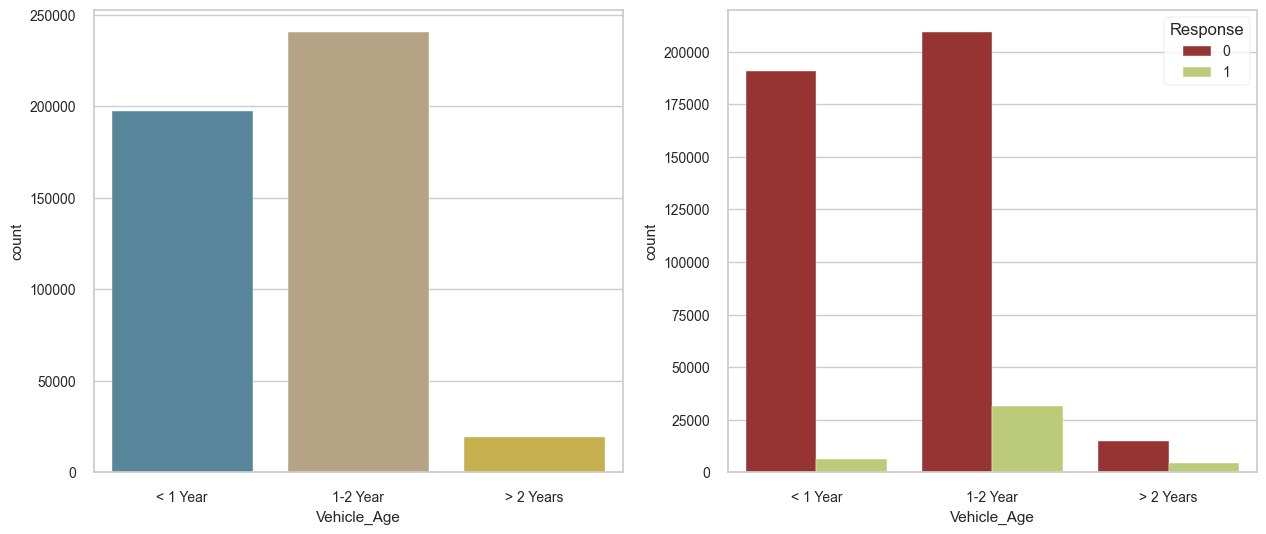

In [36]:
fig, ax =plt.subplots(1,2,figsize = (15,6))
c5=sns.countplot(x=train_set['Vehicle_Age'],palette=["#4C89A5","#BEA57D","#DABC39"],ax=ax[0])
c6=sns.countplot(x=train_set['Vehicle_Age'], hue = train_set['Response'],palette=["#A52422","#C5D86D"],ax=ax[1])
plt.show()

In [37]:
print("Number of Vehicle Age equal to 1-2 Years: " + str((train_set.Vehicle_Age == '1-2 Year').sum()))
print("Number of Vehicle Age less than 1 Year: " + str((train_set.Vehicle_Age == '< 1 Year').sum()))
print("Number of Vehicle Age greater than 2 Years: " + str((train_set.Vehicle_Age == '> 2 Years').sum()))
print("Number of  Vehicle Age equal to 1-2 Years with response 1: " + str(c6.patches[3].get_height()))
print("Number of Vehicle Age less than 1 Year with response 1: " + str(c6.patches[4].get_height()))
print("Number of  Vehicle Age greater than 2 Years with response 1: " + str(c6.patches[5].get_height()))

Number of Vehicle Age equal to 1-2 Years: 240548
Number of Vehicle Age less than 1 Year: 197562
Number of Vehicle Age greater than 2 Years: 19221
Number of  Vehicle Age equal to 1-2 Years with response 1: 6496.0
Number of Vehicle Age less than 1 Year with response 1: 31289.0
Number of  Vehicle Age greater than 2 Years with response 1: 4257.0


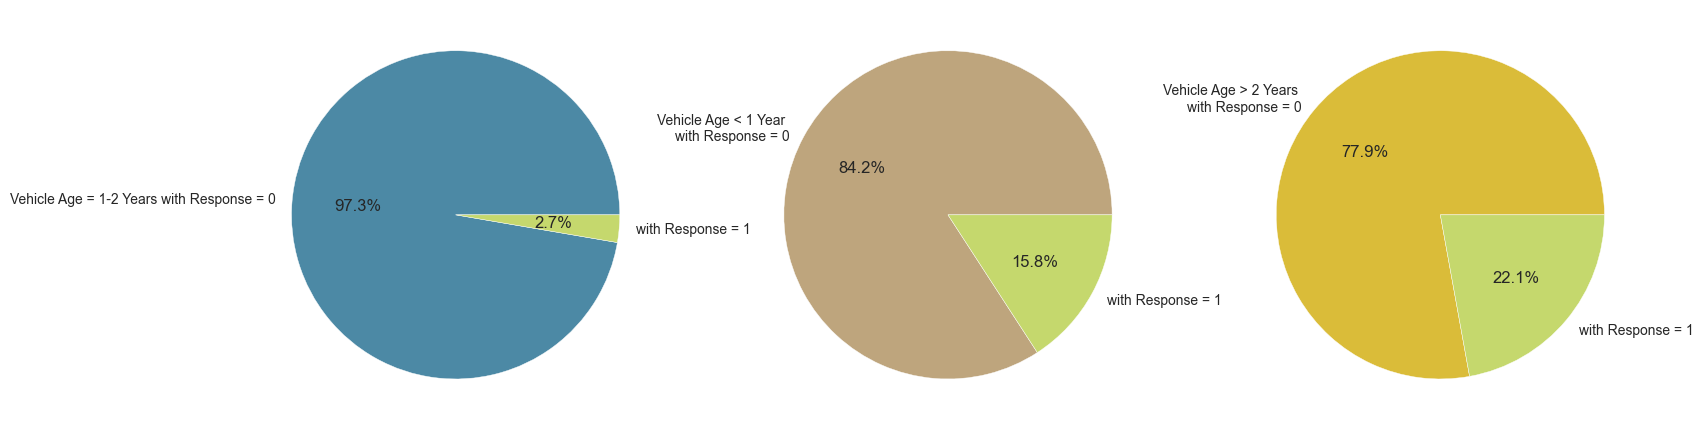

In [38]:
fig, ax =plt.subplots(1,3,figsize = (18,6))
data_12 = [(train_set.Vehicle_Age == '1-2 Year').sum()-c6.patches[3].get_height(),c6.patches[3].get_height()]
keys_12 = ['Vehicle Age = 1-2 Years with Response = 0','with Response = 1']
data_1 = [(train_set.Vehicle_Age == '< 1 Year').sum()-c6.patches[4].get_height(),c6.patches[4].get_height()]
keys_1 = ['Vehicle Age < 1 Year \nwith Response = 0','with Response = 1']
data_2 = [(train_set.Vehicle_Age == '> 2 Years').sum()-c6.patches[5].get_height(),c6.patches[5].get_height()]
keys_2 = ['Vehicle Age > 2 Years \nwith Response = 0','with Response = 1']
ax[0].pie(data_12, labels=keys_12, colors=["#4C89A5","#C5D86D"], autopct='%.1f%%')
ax[1].pie(data_1, labels=keys_1, colors=["#BEA57D","#C5D86D"], autopct='%.1f%%')
ax[2].pie(data_2, labels=keys_2, colors=["#DABC39","#C5D86D"], autopct='%.1f%%')
plt.show()

Here we should not be fooled by the high percentage of vehicles older than 2 years whose owners will accept insurance with the same company, as the total number of vehicles older than 2 is much lower than the other two (1-2 Years & < 1 Year). Therefore on vehicles older than 2 we cannot make a correct analysis, but we can say that owners of vehicles that are at least 1 year old will accept the proposal more easily.

### Response & Previously_Insured

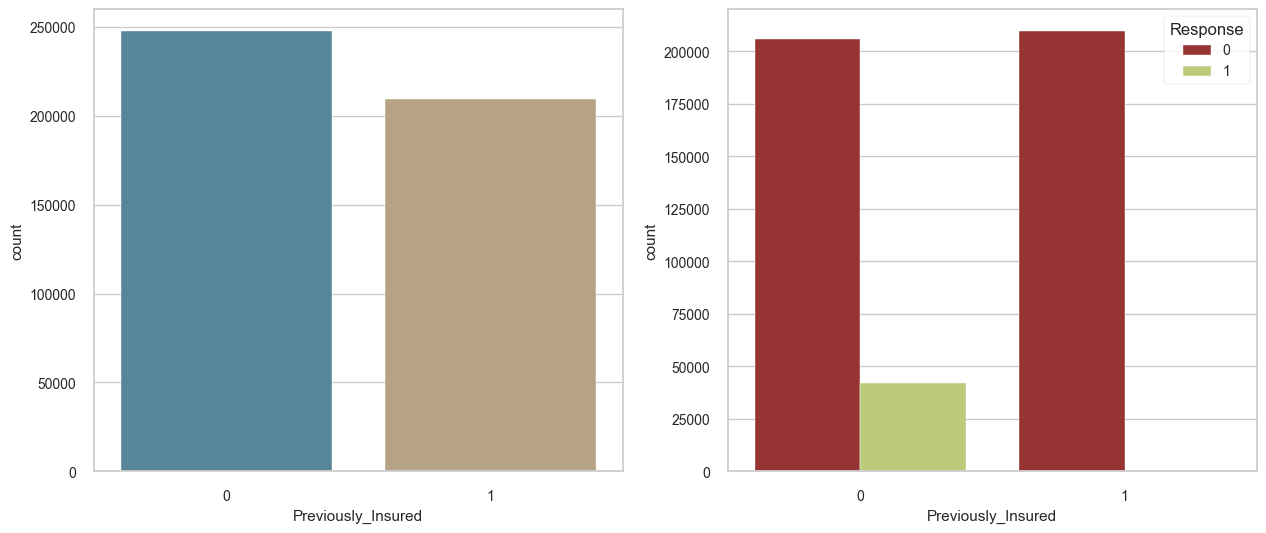

In [39]:
fig, ax =plt.subplots(1,2,figsize = (15,6))
c7=sns.countplot(x=train_set['Previously_Insured'],palette=["#4C89A5","#BEA57D"],ax=ax[0])
c8=sns.countplot(x=train_set['Previously_Insured'], hue = train_set['Response'],palette=["#A52422","#C5D86D"],ax=ax[1])
plt.show()

In [40]:
print("Number of previously insured vehicles: " + str((train_set.Previously_Insured == 1).sum()))
print("Number of non-previously insured vehicles: " + str((train_set.Previously_Insured == 0).sum()))
print("Number of non-previously insured vehicles with response 1: " + str(c8.patches[2].get_height()))
print("Number of previously insured vehicles with response 1: " + str(c8.patches[3].get_height()))

Number of previously insured vehicles: 209713
Number of non-previously insured vehicles: 247618
Number of non-previously insured vehicles with response 1: 41899.0
Number of previously insured vehicles with response 1: 143.0


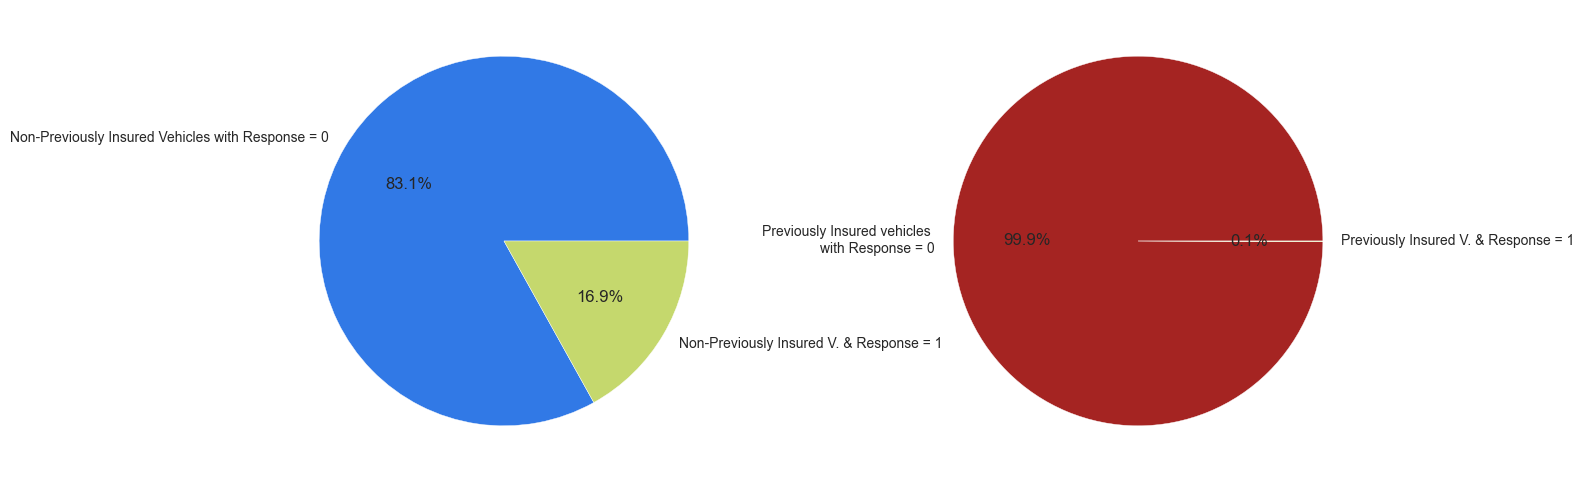

In [41]:
fig, ax =plt.subplots(1,2,figsize = (15,6))
data_npi = [(train_set.Previously_Insured == 0).sum()-c8.patches[2].get_height(),c8.patches[2].get_height()]
keys_npi = ['Non-Previously Insured Vehicles with Response = 0','Non-Previously Insured V. & Response = 1']
data_pi = [(train_set.Previously_Insured == 1).sum()-c8.patches[3].get_height(),c8.patches[3].get_height()]
keys_pi = ['Previously Insured vehicles \nwith Response = 0','Previously Insured V. & Response = 1']
ax[0].pie(data_npi, labels=keys_npi, colors=["#3179e6","#C5D86D"], autopct='%.1f%%')
ax[1].pie(data_pi, labels=keys_pi, colors=["#A52422","#C5D86D"], autopct='%.1f%%')
plt.show()

Almost all customers with vehicles without insurance are inclined to take out vehicle insurance with the same company.

### Response & Driving License

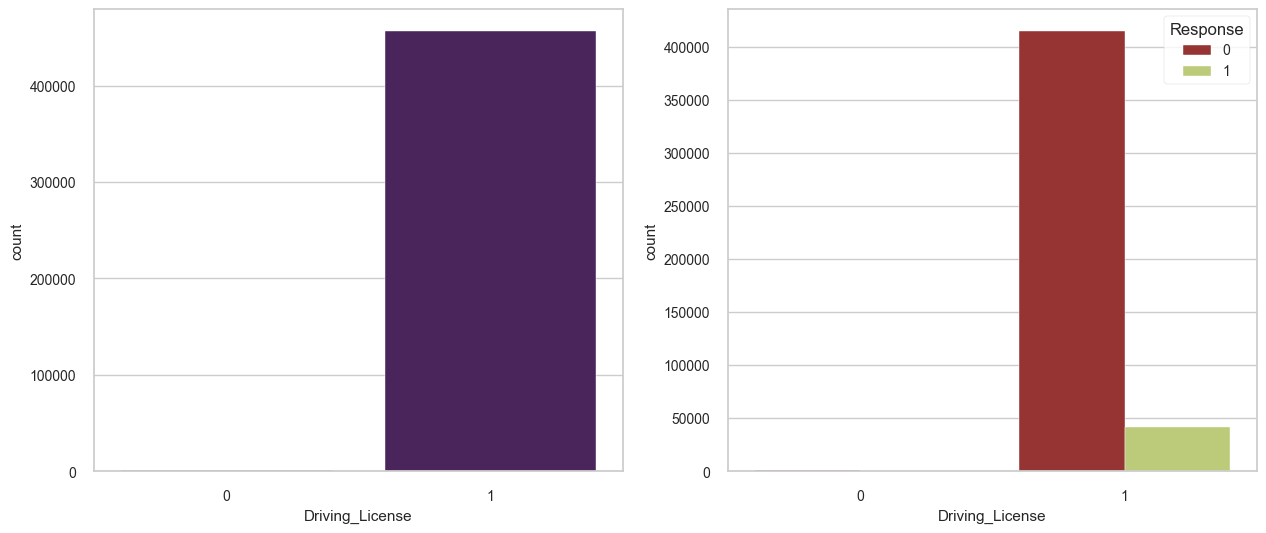

In [42]:
fig, ax =plt.subplots(1,2,figsize = (15,6))
c9=sns.countplot(x=train_set['Driving_License'],palette=["#4C89A5","#4E1C64"],ax=ax[0])
c10=sns.countplot(x=train_set['Driving_License'], hue = train_set['Response'],palette=["#A52422","#C5D86D"],ax=ax[1])
plt.show()

In [43]:
print("Number of customers with driving license: " + str((train_set.Driving_License == 1).sum()))
print("Number of customers without driving license: " + str((train_set.Driving_License == 0).sum()))
print("Number of customers without driving license with response 1: " + str(c10.patches[2].get_height()))
print("Number of customers with driving licenses with response 1: " + str(c10.patches[3].get_height()))

Number of customers with driving license: 456399
Number of customers without driving license: 932
Number of customers without driving license with response 1: 38.0
Number of customers with driving licenses with response 1: 42004.0


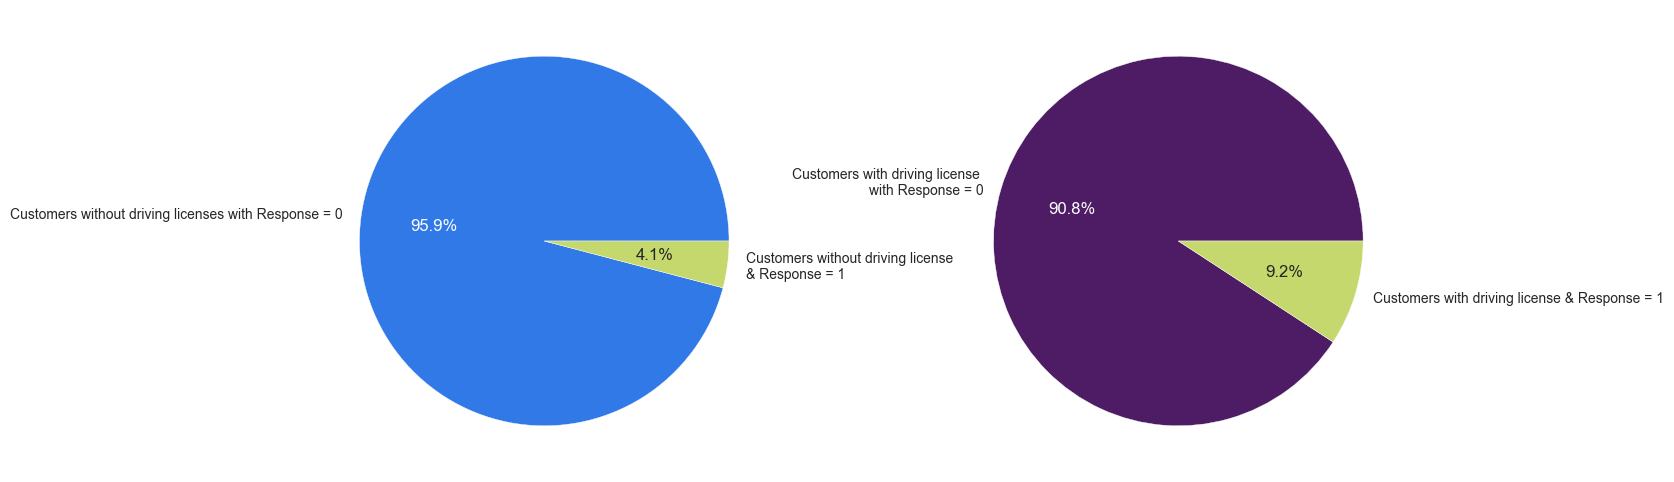

In [44]:
fig, ax =plt.subplots(1,2,figsize = (15,6))
data_npi = [(train_set.Driving_License == 0).sum()-c10.patches[2].get_height(),c10.patches[2].get_height()]
keys_npi = ['Customers without driving licenses with Response = 0','Customers without driving license \n& Response = 1']
data_pi = [(train_set.Driving_License == 1).sum()-c10.patches[3].get_height(),c10.patches[3].get_height()]
keys_pi = ['Customers with driving license \nwith Response = 0','Customers with driving license & Response = 1']
patches, texts, autotexts = ax[0].pie(data_npi,labels=keys_npi ,colors=["#3179e6","#C5D86D"], autopct='%.1f%%')
patches, texts, autotexts2 = ax[1].pie(data_pi,labels=keys_pi ,colors=["#4E1C64","#C5D86D"], autopct='%.1f%%')
autotexts[0].set_color('white')
autotexts2[0].set_color('white')
plt.show()

The fact that as many as 90.8% of customers with a driving licence would not accept the proposal to take out vehicle insurance is surely due to the problem of class imbalance

### Response & Age

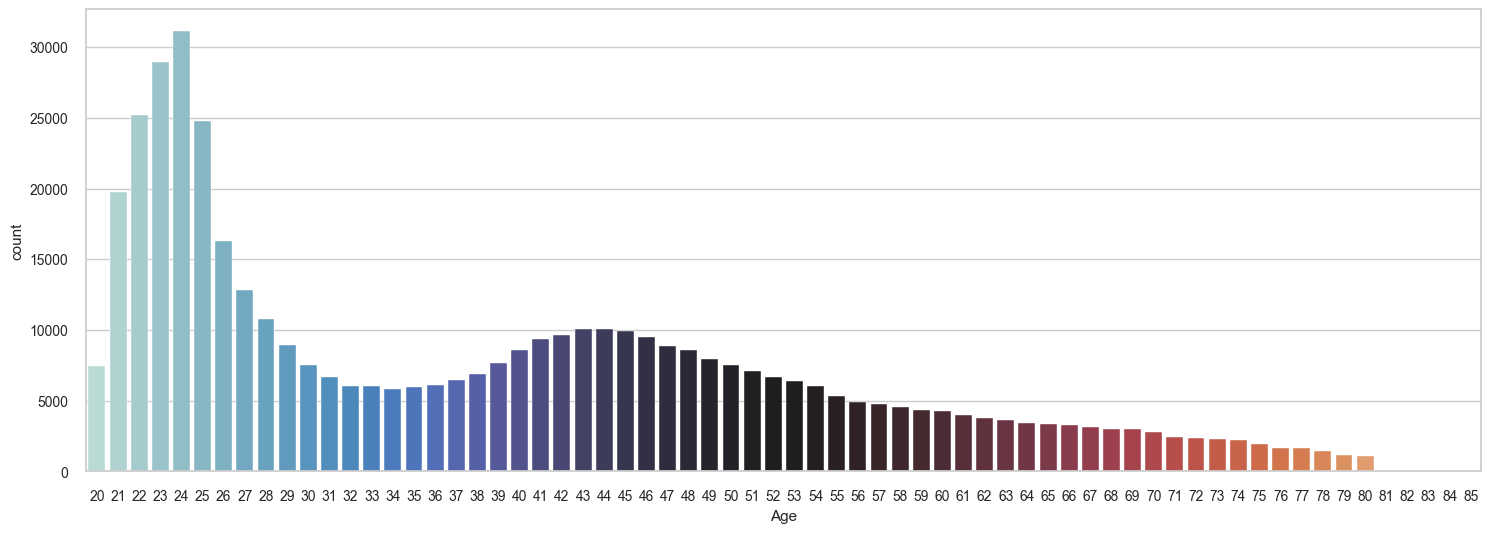

In [45]:
fig = plt.subplots(figsize = (18,6))
sns.countplot(x=train_set['Age'],palette="icefire")
plt.show()

count    457331.000000
mean         38.825912
std          15.500708
min          20.000000
25%          25.000000
50%          36.000000
75%          49.000000
max          85.000000
Name: Age, dtype: float64


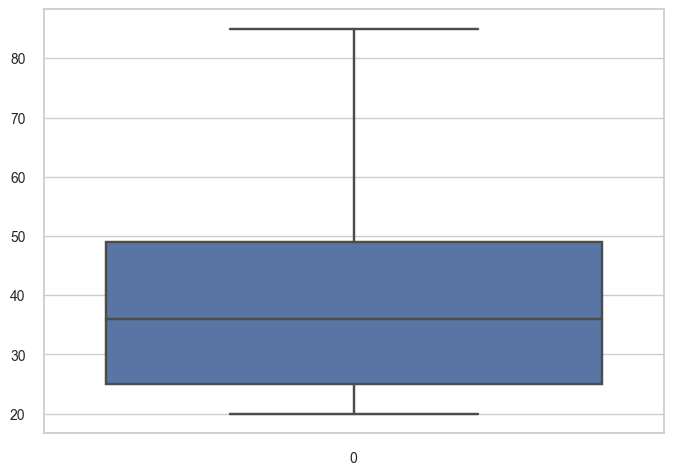

In [46]:
print(train_set.Age.describe())
sns.boxplot(train_set['Age'])
plt.show()

The middle 50 per cent of the observations made (those between the first and third quartiles) have a range of 25 years - 49 years.
The first quartile is therefore 25 years, the third 49 years with a median of 36. The dispersion of the values below the first quartile is up to 20 years and the dispersion above the third quartile up to 85 years. furthermore, as we can see, there are no outliers present that might presage possible outliers.

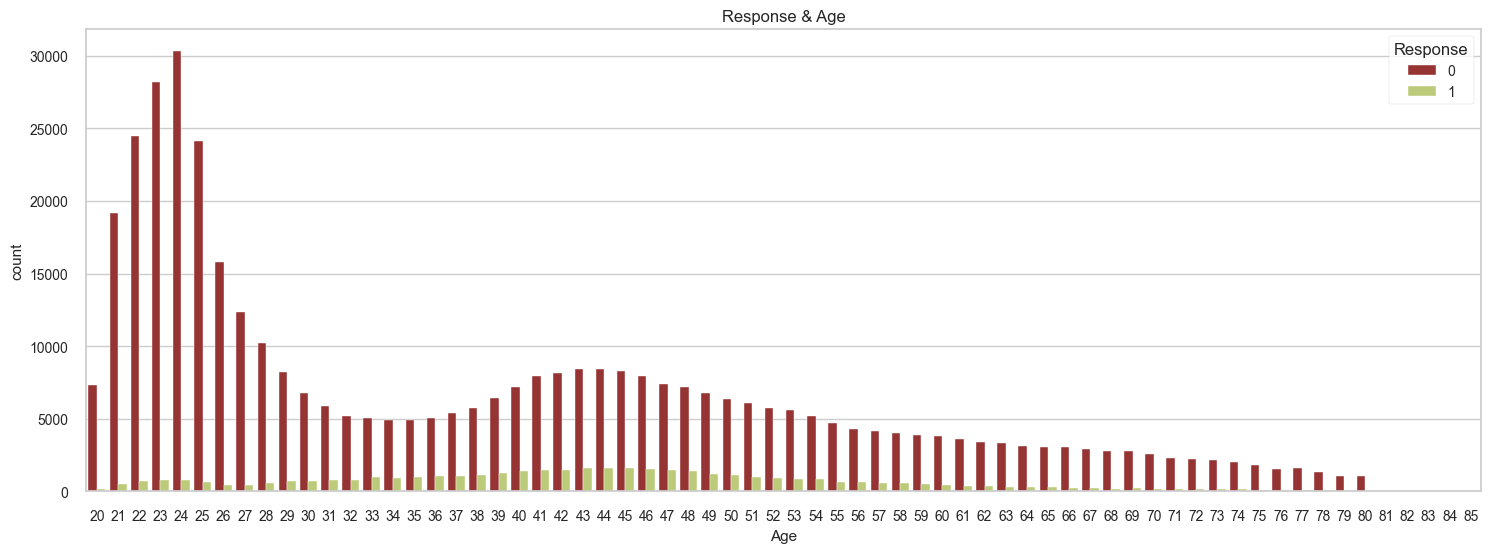

In [47]:
fig = plt.subplots(figsize = (18,6))
sns.countplot(x=train_set['Age'], hue = train_set['Response'],palette=["#A52422","#C5D86D"])
plt.title("Response & Age")
plt.show()

The age group around 44 is more inclined to take out car insurance with the same company, although we also notice a slight propensity around the age of 24, but this could be due to the presence of more champions in that age group.

### Annual Premium

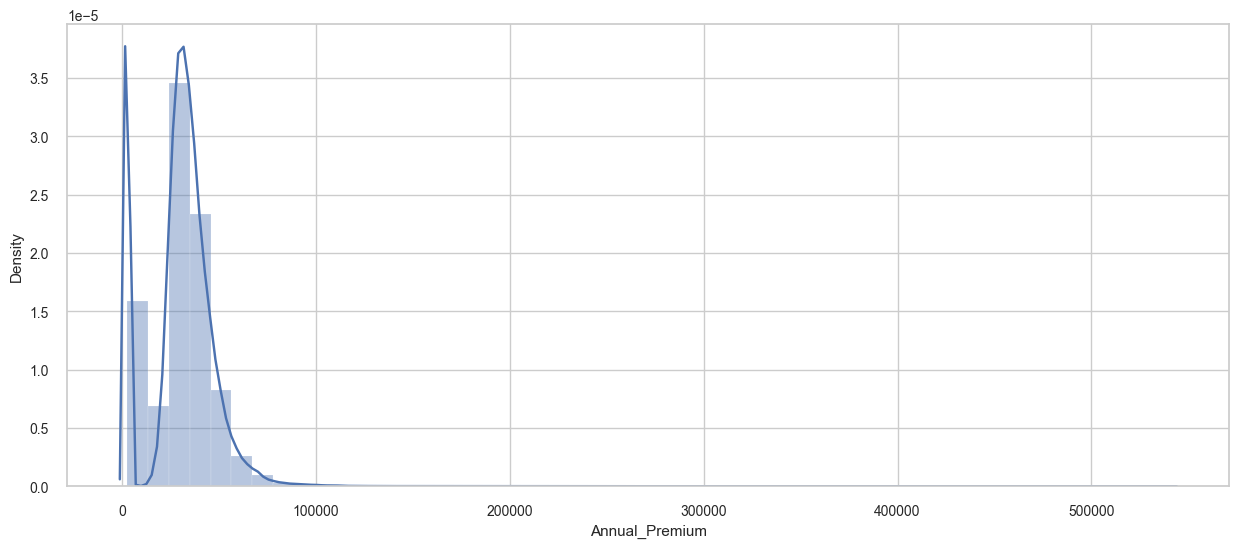

In [48]:
fig = plt.figure(figsize = (15,6))
sns.distplot(train_set.Annual_Premium)
plt.show()

In [49]:
(train_set.Annual_Premium == 2630).sum()

77815

The distribution of the attribute Annual_Premium shows a peak in the initial part. It may be that the minimum range is set at 2630 (all premiums payable that have a value less than 2630 are truncated precisely in 2630) even though the range (0, 2630) is rather small. Or there may be the presence of outliers.

count    457331.000000
mean      30563.447599
std       17171.238346
min        2630.000000
25%       24382.000000
50%       31668.000000
75%       39419.000000
max      540165.000000
Name: Annual_Premium, dtype: float64


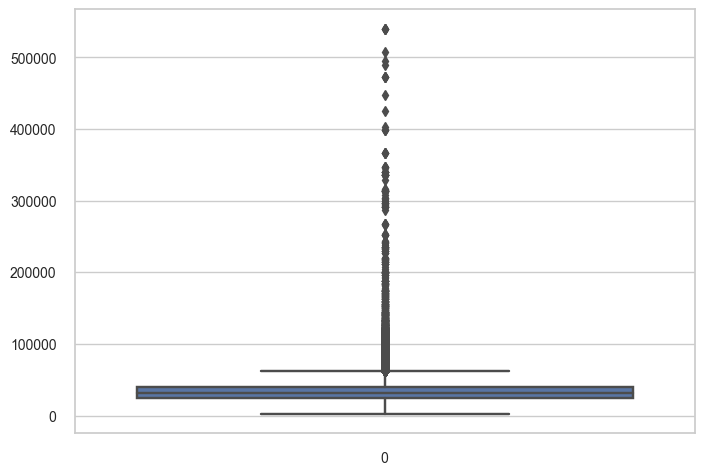

In [50]:
print(train_set.Annual_Premium.describe())
sns.boxplot(train_set['Annual_Premium'])
plt.show()

As can be seen from this box plot relating to the Annual Premium, we have numerous outliers that lead one to think of the presence of outliers as I had noted in the initial analysis using the describe() method

using the interquartile method, outliers are those falling below Q1 - 1.5IQR or above Q3 +1.5IQR, where Q1 is the 25th percentile, Q3 the 75th percentile and IQR represents the interquartile range calculated from Q3-Q1

In [51]:
q1 = train_set['Annual_Premium'].quantile(0.25)
q3 = train_set['Annual_Premium'].quantile(0.75)
IQR = q3-q1
outliers_train = train_set['Annual_Premium'][((train_set['Annual_Premium']<(q1-1.5*IQR)) | (train_set['Annual_Premium']>(q3+1.5*IQR)))]
print("Number of outliers: "+ str(len(outliers_train)))

print("Max outlier value: "+ str(outliers_train.max()))

print("Min outlier value: "+ str(outliers_train.min()))

Number of outliers: 12257
Max outlier value: 540165.0
Min outlier value: 61977.0


### Vintage

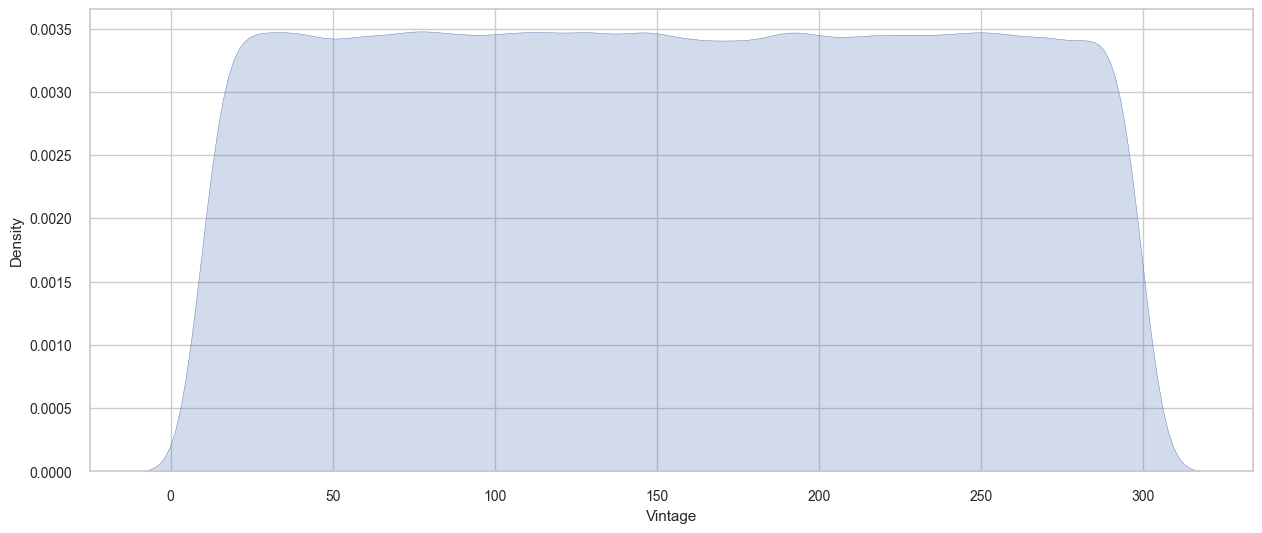

In [52]:
fig = plt.figure(figsize = (15,6))
sns.kdeplot(train_set.Vintage,shade=True)
plt.show()

count    457331.000000
mean        154.354011
std          83.660598
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64


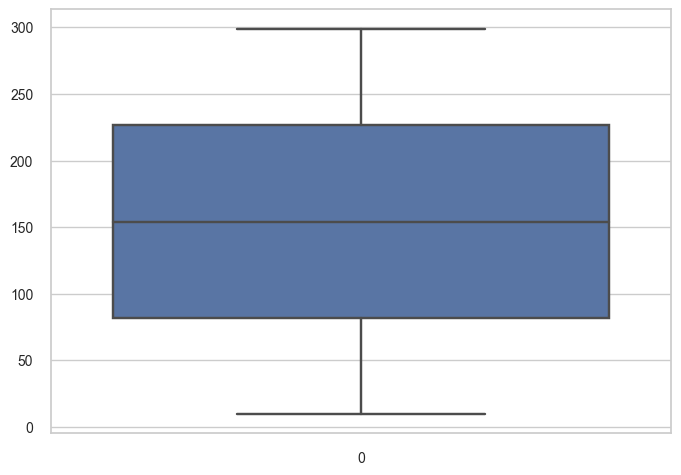

In [53]:
print(train_set.Vintage.describe())
sns.boxplot(train_set['Vintage'])
plt.show()

The middle 50 per cent of the observations have a range of 82 - 227 days. The first quartile is therefore 85 days, the third 227 days with a median of 154. The dispersion of the values below the first quartile is up to 10 days and the dispersion above the third quartile up to 299. Furthermore, as can be seen, there are no outliers to suggest the presence of possible outliers.

### Region Code & Response

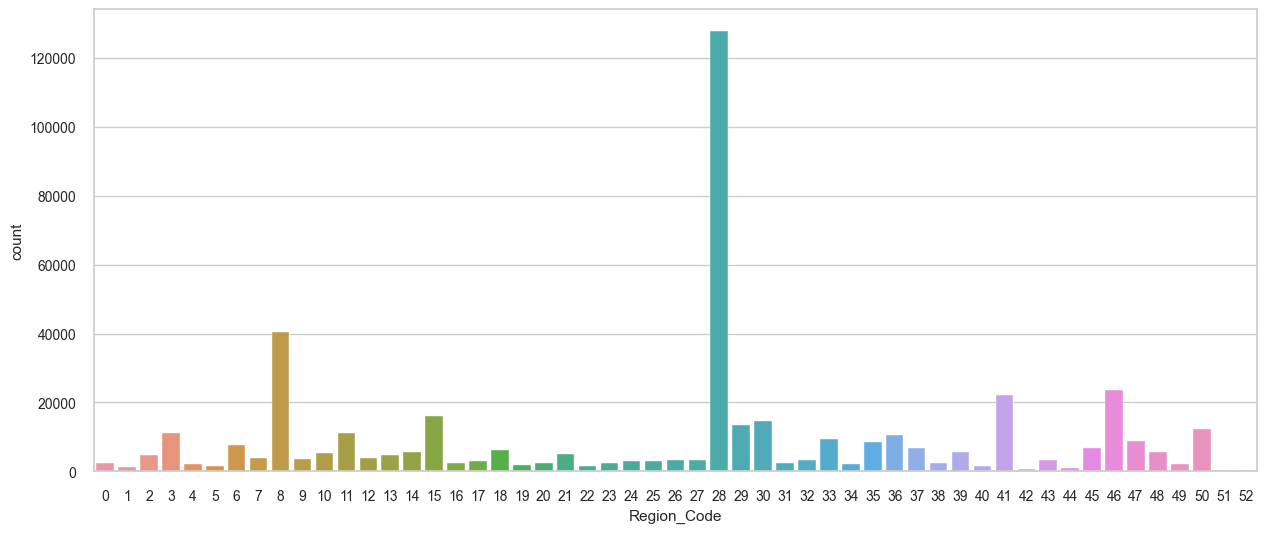

In [54]:
fig = plt.figure(figsize=(15,6))
sns.countplot(x=train_set['Region_Code'])
plt.show()

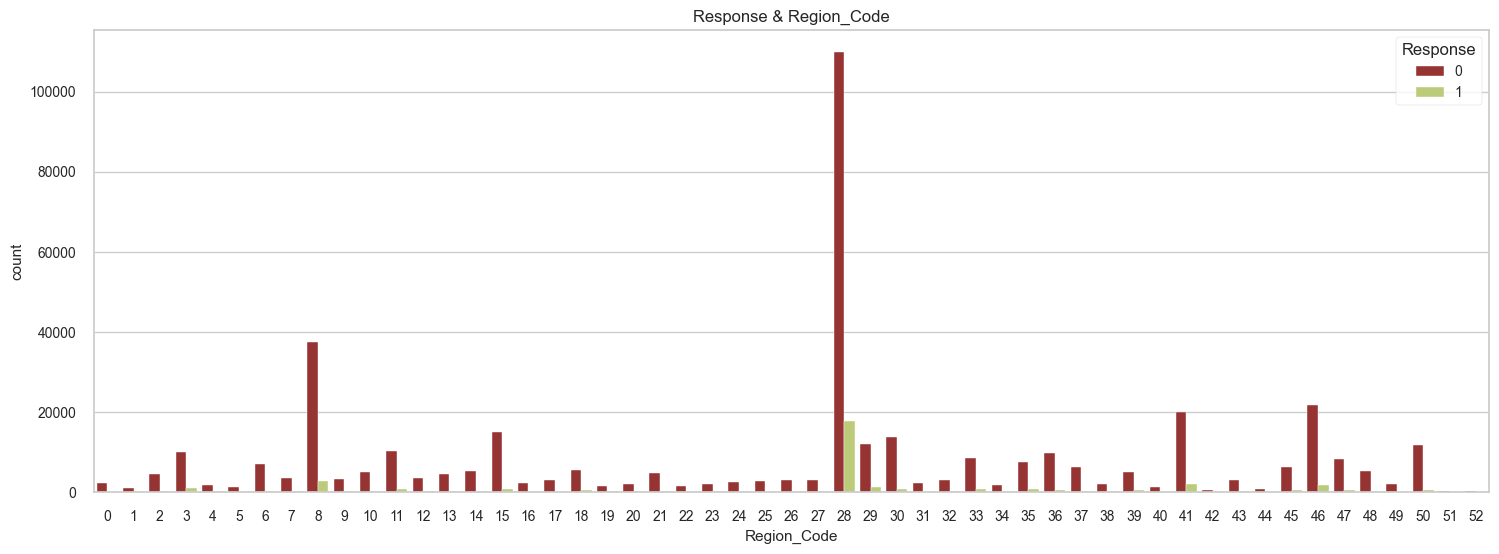

In [55]:
fig = plt.subplots(figsize = (18,6))
sns.countplot(x=train_set['Region_Code'], hue = train_set['Response'],palette=["#A52422","#C5D86D"])
plt.title("Response & Region_Code")
plt.show()

The dataset only provides us with a region code, so we cannot do a very accurate analysis. From the countplot, it can be seen that region 28 has more customers who gave a yes answer about taking out vehicle insurance with the same company (note, however, that the number of samples is much higher than in the other regions). It could be assumed that the insurance company is based in region 28. Another significant region is region 41 followed by region 8 in terms of sample ratio.

### Response & Policy Sales Channel

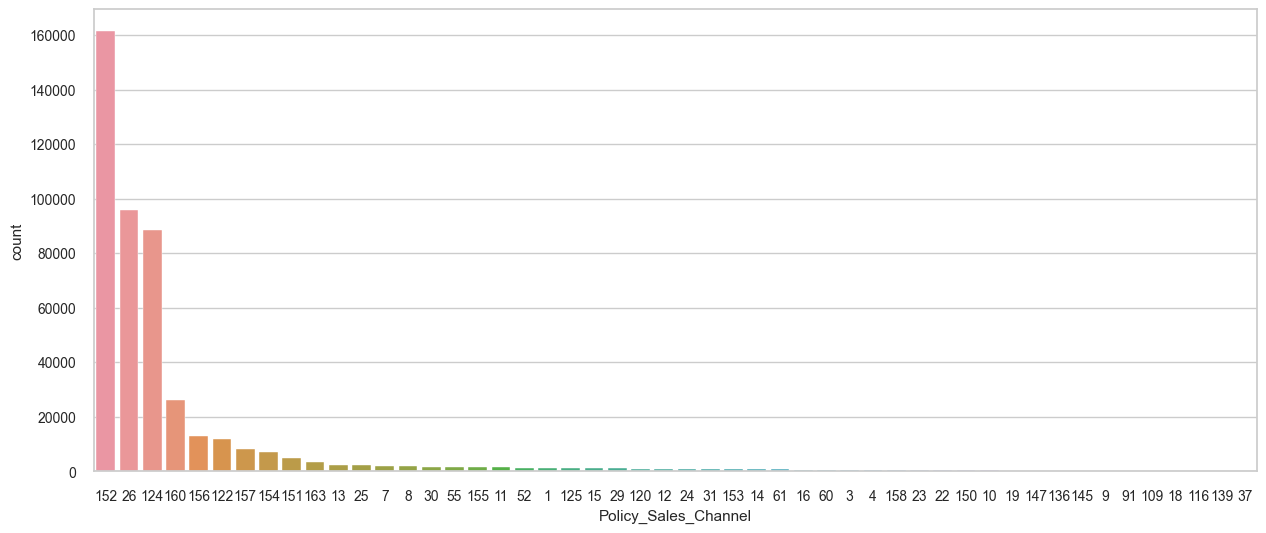

In [56]:
fig = plt.figure(figsize=(15,6))
sns.countplot(x=train_set['Policy_Sales_Channel'], order=pd.value_counts(train_set['Policy_Sales_Channel']).iloc[:50].index)
plt.show()

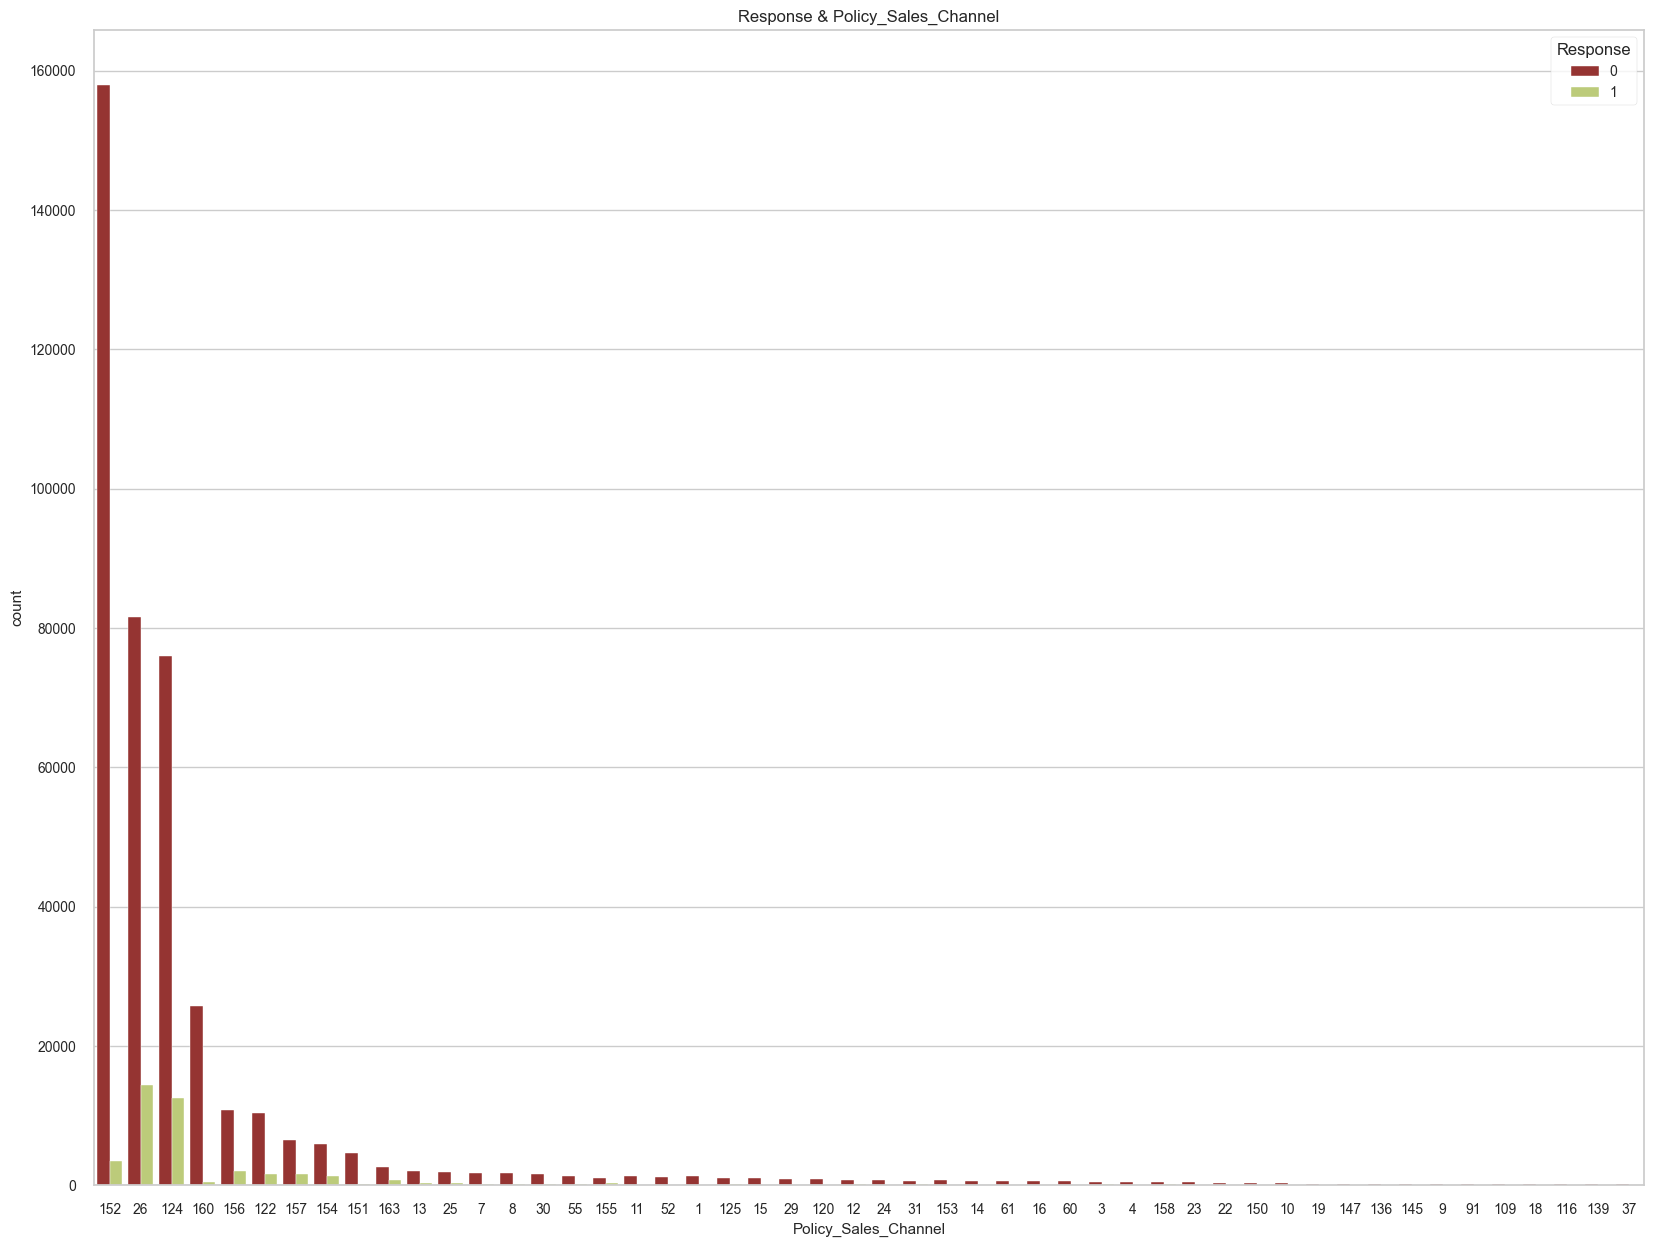

In [57]:
fig = plt.figure(figsize = (20,15))
sns.countplot(x=train_set['Policy_Sales_Channel'], order=pd.value_counts(train_set['Policy_Sales_Channel']).iloc[:50].index, hue = train_set['Response'],palette=["#A52422","#C5D86D"])
plt.title("Response & Policy_Sales_Channel")
plt.show()

26 and 124 are channels of customer contact that prompted the acceptance of car insurance with the same company.

From all these analyses, none brings the need to eliminate attributes, especially since the distribution of the Response in relation to each other attribute is never equally distributed. To be resolved is the issue of outliers in Annual Premium.

## 4) Preparing data for machine learning algorithms

Column not significant for the purposes of the following analysis is the ID

In [58]:
train_set.drop(labels='id', axis=1, inplace=True)
test_set.drop(labels='id', axis=1, inplace=True)

In [59]:
train_set.head()

Gender  Age  Driving_License  Region_Code  Previously_Insured  \
5074    Female   20                1           26                   0   
221200  Female   57                1            0                   0   
45039   Female   40                1           25                   1   
357084    Male   49                1           28                   0   
231238    Male   23                1           28                   0   

       Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
5074      < 1 Year             No         25003.0                   160   
221200    1-2 Year            Yes          2630.0                    26   
45039     1-2 Year             No          2630.0                   151   
357084    1-2 Year            Yes         43051.0                    26   
231238    1-2 Year            Yes         50485.0                    26   

        Vintage  Response  
5074        238         0  
221200      266         0  
45039       148         0  
357084      124         0  
231238      274         0

In [60]:
test_set.head()

Gender  Age  Driving_License  Region_Code  Previously_Insured  \
299638  Female   25                1           41                   1   
336405    Male   33                1           11                   0   
373094  Female   26                1           32                   1   
469314    Male   24                1           27                   1   
91525     Male   77                1            8                   1   

       Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
299638    < 1 Year            Yes         25011.0                   152   
336405    1-2 Year            Yes         27565.0                   122   
373094    < 1 Year             No         21887.0                   152   
469314    < 1 Year             No         20957.0                   152   
91525     1-2 Year             No         54290.0                     7   

        Vintage  Response  
299638      102         0  
336405      191         1  
373094       53         0  
469314      194         0  
91525       250         0

In [61]:
test_set.head()

Gender  Age  Driving_License  Region_Code  Previously_Insured  \
299638  Female   25                1           41                   1   
336405    Male   33                1           11                   0   
373094  Female   26                1           32                   1   
469314    Male   24                1           27                   1   
91525     Male   77                1            8                   1   

       Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
299638    < 1 Year            Yes         25011.0                   152   
336405    1-2 Year            Yes         27565.0                   122   
373094    < 1 Year             No         21887.0                   152   
469314    < 1 Year             No         20957.0                   152   
91525     1-2 Year             No         54290.0                     7   

        Vintage  Response  
299638      102         0  
336405      191         1  
373094       53         0  
469314      194         0  
91525       250         0

We must now remember to convert the attributes Region_Code and Policy_Sales_Channel to categorical, since they are nominal attributes as mentioned in the initial analysis.

In [62]:
train_set=train_set.astype({"Region_Code":str})
test_set=test_set.astype({"Region_Code":str})
train_set=train_set.astype({"Policy_Sales_Channel":str})
test_set=test_set.astype({"Policy_Sales_Channel":str})

### Analysing the presence of correlations

The dataset is not very consistent with the data, as it has attributes with values representing affirmative/negative answers some times categorically (yes/no) and other times numerically (1/0). So I should introduce some consistency between the attributes: either I transform the binary categoricals (yes/no) into numerical attributes (then use a tetrachoric correlation) or the other way around. I choose to turn them into numeric.

#### On binary categorical attributes, is it better to apply one-hot encoding or simply transform them into 0 and 1?

In general, OHE should be used if there is no order, even in the binary case. However, in the binary case it may also be OK to substitute 0 and 1 because in the transformation from categorical to numerical, the distance between attributes is given importance. The distance between binary attributes is always that, whereas in the case of three or more the distance between the objects changes, so in the latter case it is important to use ohe. This is why I simply take care to transform the binary categorical attributes into 0 and 1.

In [63]:
train_set['Vehicle_Damage'].replace({'Yes': 1,'No': 0},inplace=True)
train_set['Gender'].replace({'Male': 1,'Female': 0},inplace=True)


In [64]:
train_set

Gender  Age  Driving_License Region_Code  Previously_Insured  \
5074         0   20                1          26                   0   
221200       0   57                1           0                   0   
45039        0   40                1          25                   1   
357084       1   49                1          28                   0   
231238       1   23                1          28                   0   
...        ...  ...              ...         ...                 ...   
259178       0   24                1          36                   1   
365838       1   56                1          35                   0   
131932       0   22                1           2                   0   
146867       1   44                1          32                   1   
121958       0   27                1          37                   0   

       Vehicle_Age  Vehicle_Damage  Annual_Premium Policy_Sales_Channel  \
5074      < 1 Year               0         25003.0                  160   
221200    1-2 Year               1          2630.0                   26   
45039     1-2 Year               0          2630.0                  151   
357084    1-2 Year               1         43051.0                   26   
231238    1-2 Year               1         50485.0                   26   
...            ...             ...             ...                  ...   
259178    < 1 Year               0         22575.0                  152   
365838    1-2 Year               1         41287.0                  124   
131932    < 1 Year               1         18857.0                  152   
146867    1-2 Year               1          2630.0                  156   
121958    < 1 Year               1         24741.0                  152   

        Vintage  Response  
5074        238         0  
221200      266         0  
45039       148         0  
357084      124         0  
231238      274         0  
...         ...       ...  
259178      287         0  
365838      298         0  
131932       76         0  
146867       51         0  
121958      127         1  

[457331 rows x 11 columns]

In [65]:
cat_nom = ['Region_Code','Policy_Sales_Channel']
num = ['Age', 'Annual_Premium','Vintage','Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Damage', 'Response']

#### Correlation between numeric attributes

I calculate the standard correlation coefficient, also known as Pearson's coefficient, which quantifies how closely two features are correlated. Through the heatmap, I visualise the correlation between all numerical attributes, always taking into account the limitation of Pearson's coefficient that only captures linear correlations.

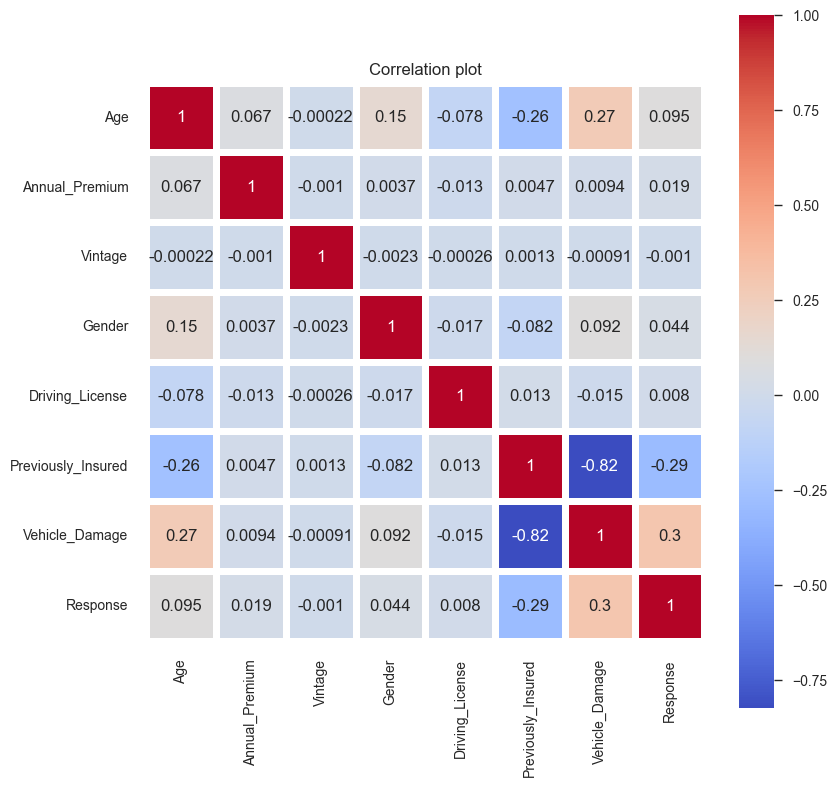

In [66]:
plt.figure(figsize=(9,9))
plt.title("Correlation plot")
sns.heatmap(train_set[num].corr(),linewidths=5, annot=True, square=True, cmap='coolwarm')
plt.show()

As can be seen from the heatmap, there is a high negative correlation between the attribute Previously_Insured and Vehicle_Damage, so one of them could be eliminated. Vehicle_Damage has slightly higher correlations with the other attributes than Previously_Insured, and this would lead me to eliminate the attribute Vehicle_Damage. Claims in insurance is a key element, especially in the calculation of the annual premium, although the dataset does not confirm this as the correlation between Vehicle_Damage and Annual_Premium is very low. However, I wait before analysing the feature importance before removing the Previously_Insured attribute. Furthermore, we have weak correlations between other attributes. A weak negative correlation between Previously_Insured and the target attribute, but also between Previously_Insured and Age. A weak positive correlation between Vehicle_Damage and the target attribute but also between Vehicle_Damage and Age. This makes one think a little bit about eliminating the Age attribute but in my opinion it is avoidable as the correlation is not high.

####  Correlation between nominal categorical attributes

*Cramer's V* is used to calculate the correlation between nominal categorical variables.

The value for Cramer's V ranges from 0 to 1, with 0 indicating no association between the variables and 1 indicating a strong association between the variables.

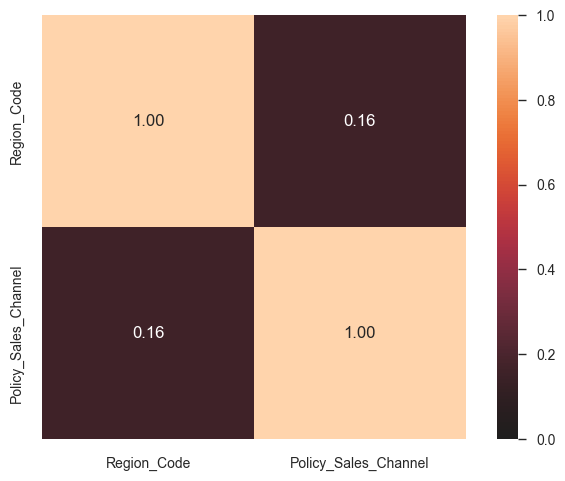

{'corr':                       Region_Code  Policy_Sales_Channel
 Region_Code              1.000000              0.157036
 Policy_Sales_Channel     0.157036              1.000000,
 'ax': <Axes: >}

In [67]:
associations(train_set[cat_nom],nom_nom_assoc = 'cramer')

The correlation between nominal categorical attributes is low.

Now just for visualisation and confirmation purposes, I analyse the relationships between the non-binary numeric attributes (which have little correlation)

### Annual Premium, Age  (corr. AnnualPremium-Age = 0.067)

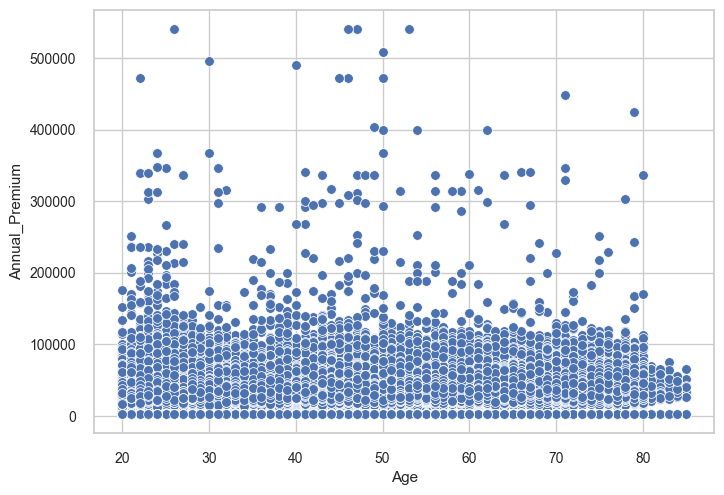

In [68]:
sns.scatterplot(data = train_set, x = "Age", y = "Annual_Premium")
plt.show()

The distribution of the Annual Premium as can also be seen from the jointplot is thickened below 100000 and let us remember that from the boxplot we had noticed a number of outliers which are reflected in the scatter plot. Therefore, I analyse the amounts that the customer has to pay as premium during the year that are below 100000. One could also add the hue option to see the relationship with the target attribute, but it requires too much computational time and so I have removed it

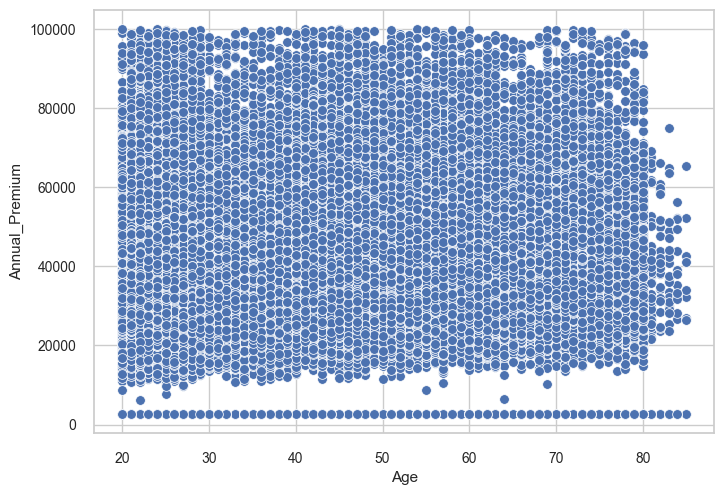

In [69]:
df=train_set.loc[train_set['Annual_Premium'] <= 100000]
sns.scatterplot(data = df, x = "Age", y = "Annual_Premium")
plt.show()

Identically with Annual Premium and Vintage.

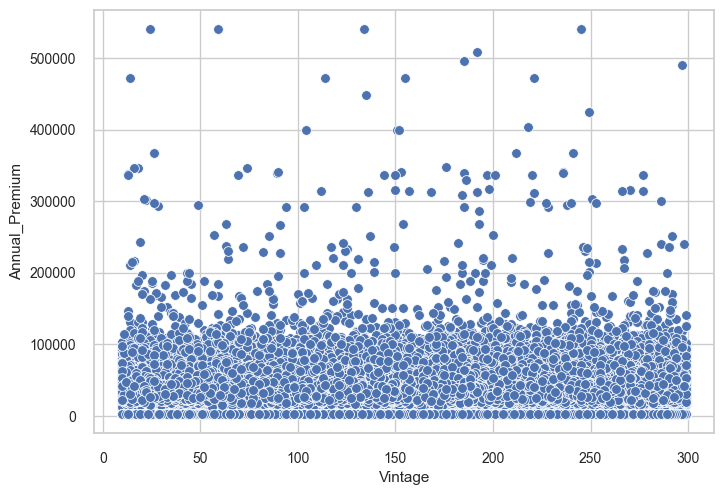

In [70]:
sns.scatterplot(data = train_set, x = "Vintage", y = "Annual_Premium")
plt.show()

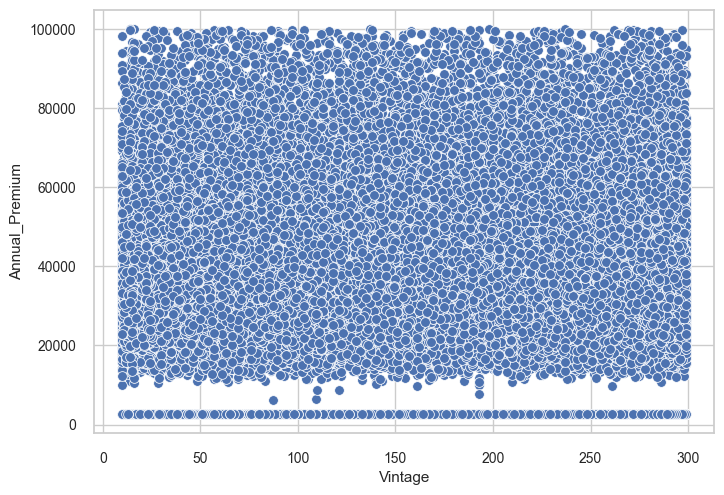

In [71]:
df=train_set.loc[train_set['Annual_Premium'] <= 100000]
sns.scatterplot(data = df, x = "Vintage", y = "Annual_Premium")
plt.show()

As a proof of the correlation matrix, there is no link between these attributes.

Now, I do not have to worry about handling missing values as there are none.
What needs to be done is:

- Data Cleaning (outliers..)
- Data Transformation
- Data Balancing (undersampling) - Imbalanced learning
- Feature Scaling (since the data do not have the same scale)
- Feature Selection

### Data Cleaning 

#### - Outliers

From the initial analysis, we have no missing values, so I reduce myself to handling outliers.

There are several methods to deal with outliers, some are:

- Eliminating outliers
- Limiting outliers
- Replacing outliers using imputation as if they were missing values
- Using transformation

In [72]:
train_set.Annual_Premium.describe()

count    457331.000000
mean      30563.447599
std       17171.238346
min        2630.000000
25%       24382.000000
50%       31668.000000
75%       39419.000000
max      540165.000000
Name: Annual_Premium, dtype: float64

Eliminating outliers is not always the right choice; they can be legitimate observations and are sometimes the most interesting. Therefore, it is important to investigate the nature of the outliers before deciding. From my initial analysis, I found the presence of outliers by plotting the box plot of the Annual Premium attribute. The data itself does not reflect the currency of the euro. However, I could think they are Indian rupees. This is because in general, the average annual car insurance premium is about 380 euros, which in rupee is 30944.50. The average Annual Premium value in our dataset is 30568.8, so there you go!

In [73]:
q1 = train_set['Annual_Premium'].quantile(0.25)
q3 = train_set['Annual_Premium'].quantile(0.75)
IQR = q3-q1
outliers_train = train_set['Annual_Premium'][((train_set['Annual_Premium']<(q1-1.5*IQR)) | (train_set['Annual_Premium']>(q3+1.5*IQR)))]
print("Number of outliers: "+ str(len(outliers_train)))

print("Max outlier value: "+ str(outliers_train.max()))

print("Min outlier value: "+ str(outliers_train.min()))

Number of outliers: 12257
Max outlier value: 540165.0
Min outlier value: 61977.0


The maximum value of an outlier is 540165 rupees, or 6633.25 euro, and an annual car insurance premium would never reach these figures. A real and consistent maximum value of the annual premium could be 180k. So I can already consider the fact that all outliers above 180k I eliminate. Now I have to think about what to do with the outliers up to 180k. One option would be to do imputation and replace them with the average value, but in my opinion this makes no sense because then the value would be 'false' and could give misleading information in learning. Since they are less than 2 % of the dataset, I make the choice of eliminating these values as well, in the absence of other considerations as to their nature.

count    457331.000000
mean      30563.447599
std       17171.238346
min        2630.000000
25%       24382.000000
50%       31668.000000
75%       39419.000000
max      540165.000000
Name: Annual_Premium, dtype: float64


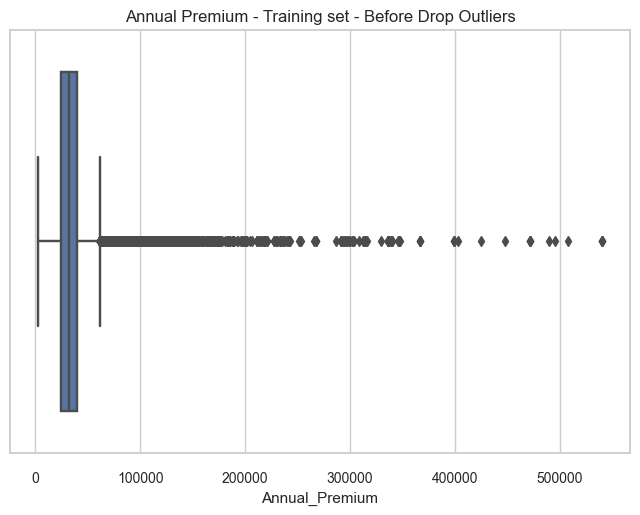

In [74]:
print(train_set.Annual_Premium.describe())
sns.boxplot(x=train_set['Annual_Premium'])
plt.title("Annual Premium - Training set - Before Drop Outliers")
plt.show()

count     50815.000000
mean      30473.502726
std       16922.937532
min        2630.000000
25%       24373.000000
50%       31607.000000
75%       39259.000000
max      402097.000000
Name: Annual_Premium, dtype: float64


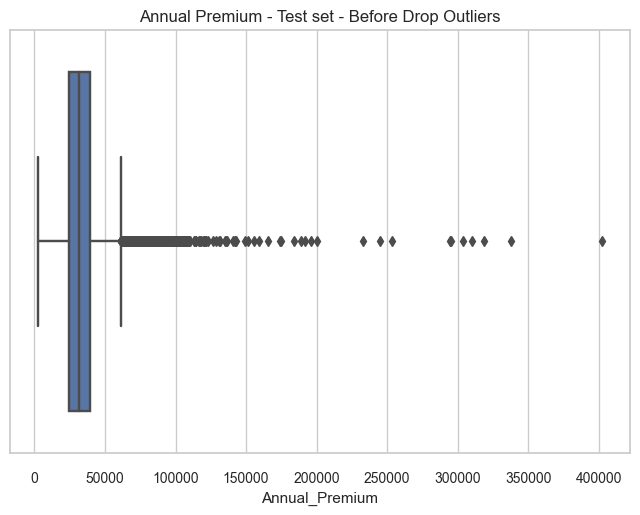

In [75]:
print(test_set.Annual_Premium.describe())
sns.boxplot(x=test_set['Annual_Premium'])
plt.title("Annual Premium - Test set - Before Drop Outliers")
plt.show()

In [76]:
train_set.shape

(457331, 11)

Annual_Premium
2630.0     77815
69856.0      173
38452.0       51
38287.0       50
45179.0       50
           ...  
61034.0        1
13665.0        1
63377.0        1
20125.0        1
55305.0        1
Name: count, Length: 50908, dtype: int64


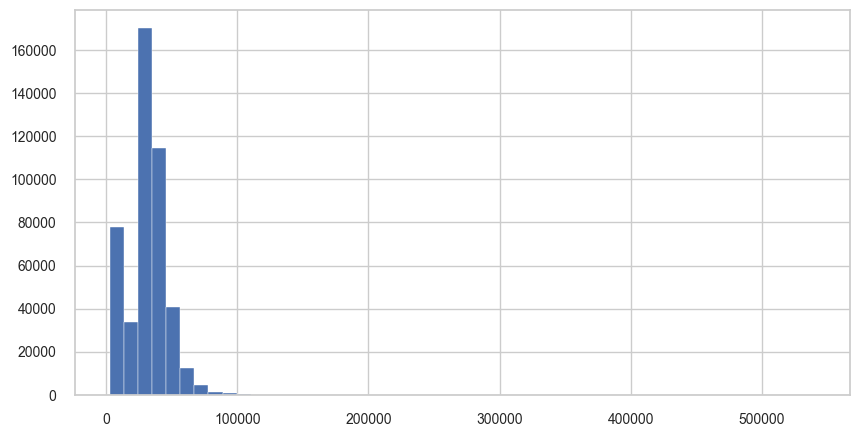

In [77]:
train_set.Annual_Premium.hist(bins = 50, figsize = (10,5) )
print((train_set.Annual_Premium).value_counts())
plt.show()

In [78]:
train_set = train_set.drop(outliersTodelete(train_set['Annual_Premium']).index)

In [79]:
train_set.shape

(445074, 11)

In [80]:
test_set.shape

(50815, 11)

In [81]:

test_set = test_set.drop(outliersTodelete(test_set['Annual_Premium']).index)

In [82]:
test_set.shape

(49397, 11)

count    445074.000000
mean      29276.350290
std       14755.682681
min        2630.000000
25%       24090.000000
50%       31320.000000
75%       38620.000000
max       61974.000000
Name: Annual_Premium, dtype: float64


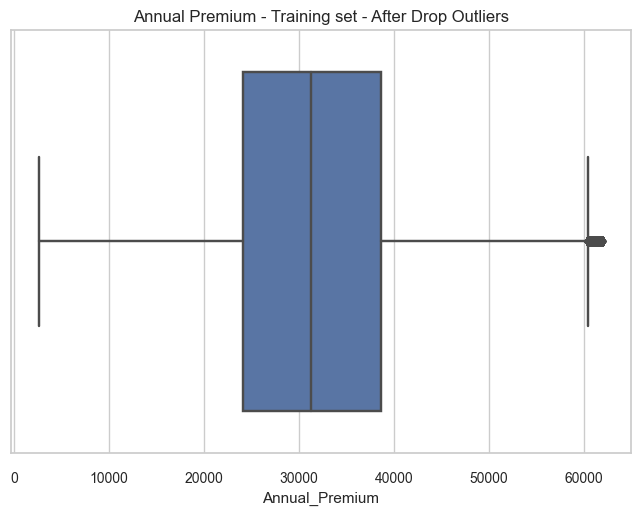

In [83]:
print(train_set.Annual_Premium.describe())
sns.boxplot(x=train_set['Annual_Premium'])
plt.title("Annual Premium - Training set - After Drop Outliers")
plt.show()

In [84]:
q1 = train_set['Annual_Premium'].quantile(0.25)
q3 = train_set['Annual_Premium'].quantile(0.75)
IQR = q3-q1
outliers_train = train_set['Annual_Premium'][((train_set['Annual_Premium']<(q1-1.5*IQR)) | (train_set['Annual_Premium']>(q3+1.5*IQR)))]
print("Number of outliers: "+ str(len(outliers_train)))

print("Max outlier value: "+ str(outliers_train.max()))

print("Min outlier value: "+ str(outliers_train.min()))

Number of outliers: 1812
Max outlier value: 61974.0
Min outlier value: 60417.0


count    49397.000000
mean     29168.252485
std      14693.009028
min       2630.000000
25%      24044.000000
50%      31268.000000
75%      38421.000000
max      61577.000000
Name: Annual_Premium, dtype: float64


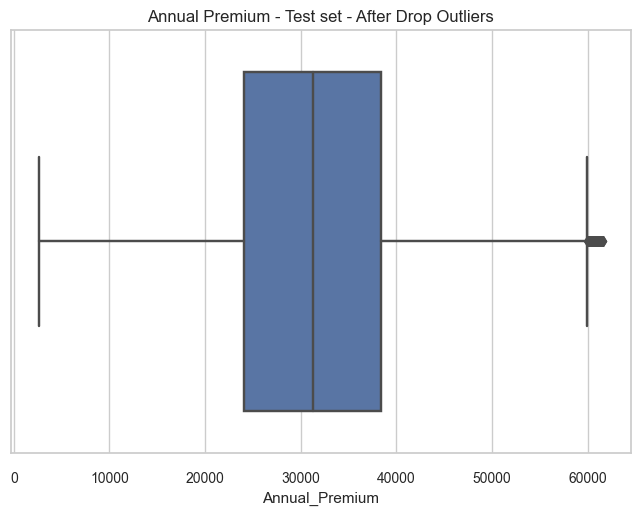

In [85]:
print(test_set.Annual_Premium.describe())
sns.boxplot(x=test_set['Annual_Premium'])
plt.title("Annual Premium - Test set - After Drop Outliers")
plt.show()

In [86]:
q1 = train_set['Annual_Premium'].quantile(0.25)
q3 = train_set['Annual_Premium'].quantile(0.75)
IQR = q3-q1
outliers_train = train_set['Annual_Premium'][((train_set['Annual_Premium']<(q1-1.5*IQR)) | (train_set['Annual_Premium']>(q3+1.5*IQR)))]
print("Number of outliers: "+ str(len(outliers_train)))

print("Max outlier value: "+ str(outliers_train.max()))

print("Min outlier value: "+ str(outliers_train.min()))

Number of outliers: 1812
Max outlier value: 61974.0
Min outlier value: 60417.0


It can be seen that the box plots still show the presence of outliers, but this is due to the fact that the quartiles have changed and it is normal that, having a not insignificant density to the left of the minimum outlier, there are some outliers in the new dataset.

In [87]:
train_set.shape

(445074, 11)

In [88]:
test_set.shape

(49397, 11)

### Data Transformation

Having carried out data cleaning, I now handle the data to be passed to the machine learning algorithms. I will carry out data encoding, discretization ...

To the data I supply to the learning algorithms, I remove the label, otherwise there is no point in learning because we would already be telling it how things are.

In [89]:
labels_train = train_set['Response'].copy()
labels_test = test_set['Response'].copy()
train_set.drop(labels='Response', axis=1, inplace = True)
test_set.drop(labels='Response', axis=1, inplace = True)

First of all, let me remind you what the categorical attributes are

In [90]:
cat = [col for col in train_set.columns if train_set[col].dtypes == 'object']
cat

['Region_Code', 'Vehicle_Age', 'Policy_Sales_Channel']

The transformation into numerical attributes of Vehicle_Damage and Gender was only done on the training set:

In [91]:
test_set['Vehicle_Damage'].replace({'Yes': 1,'No': 0},inplace=True)
test_set['Gender'].replace({'Male': 1,'Female': 0},inplace=True)
test_set.head()

Gender  Age  Driving_License Region_Code  Previously_Insured  \
299638       0   25                1          41                   1   
336405       1   33                1          11                   0   
373094       0   26                1          32                   1   
469314       1   24                1          27                   1   
91525        1   77                1           8                   1   

       Vehicle_Age  Vehicle_Damage  Annual_Premium Policy_Sales_Channel  \
299638    < 1 Year               1         25011.0                  152   
336405    1-2 Year               1         27565.0                  122   
373094    < 1 Year               0         21887.0                  152   
469314    < 1 Year               0         20957.0                  152   
91525     1-2 Year               0         54290.0                    7   

        Vintage  
299638      102  
336405      191  
373094       53  
469314      194  
91525       250

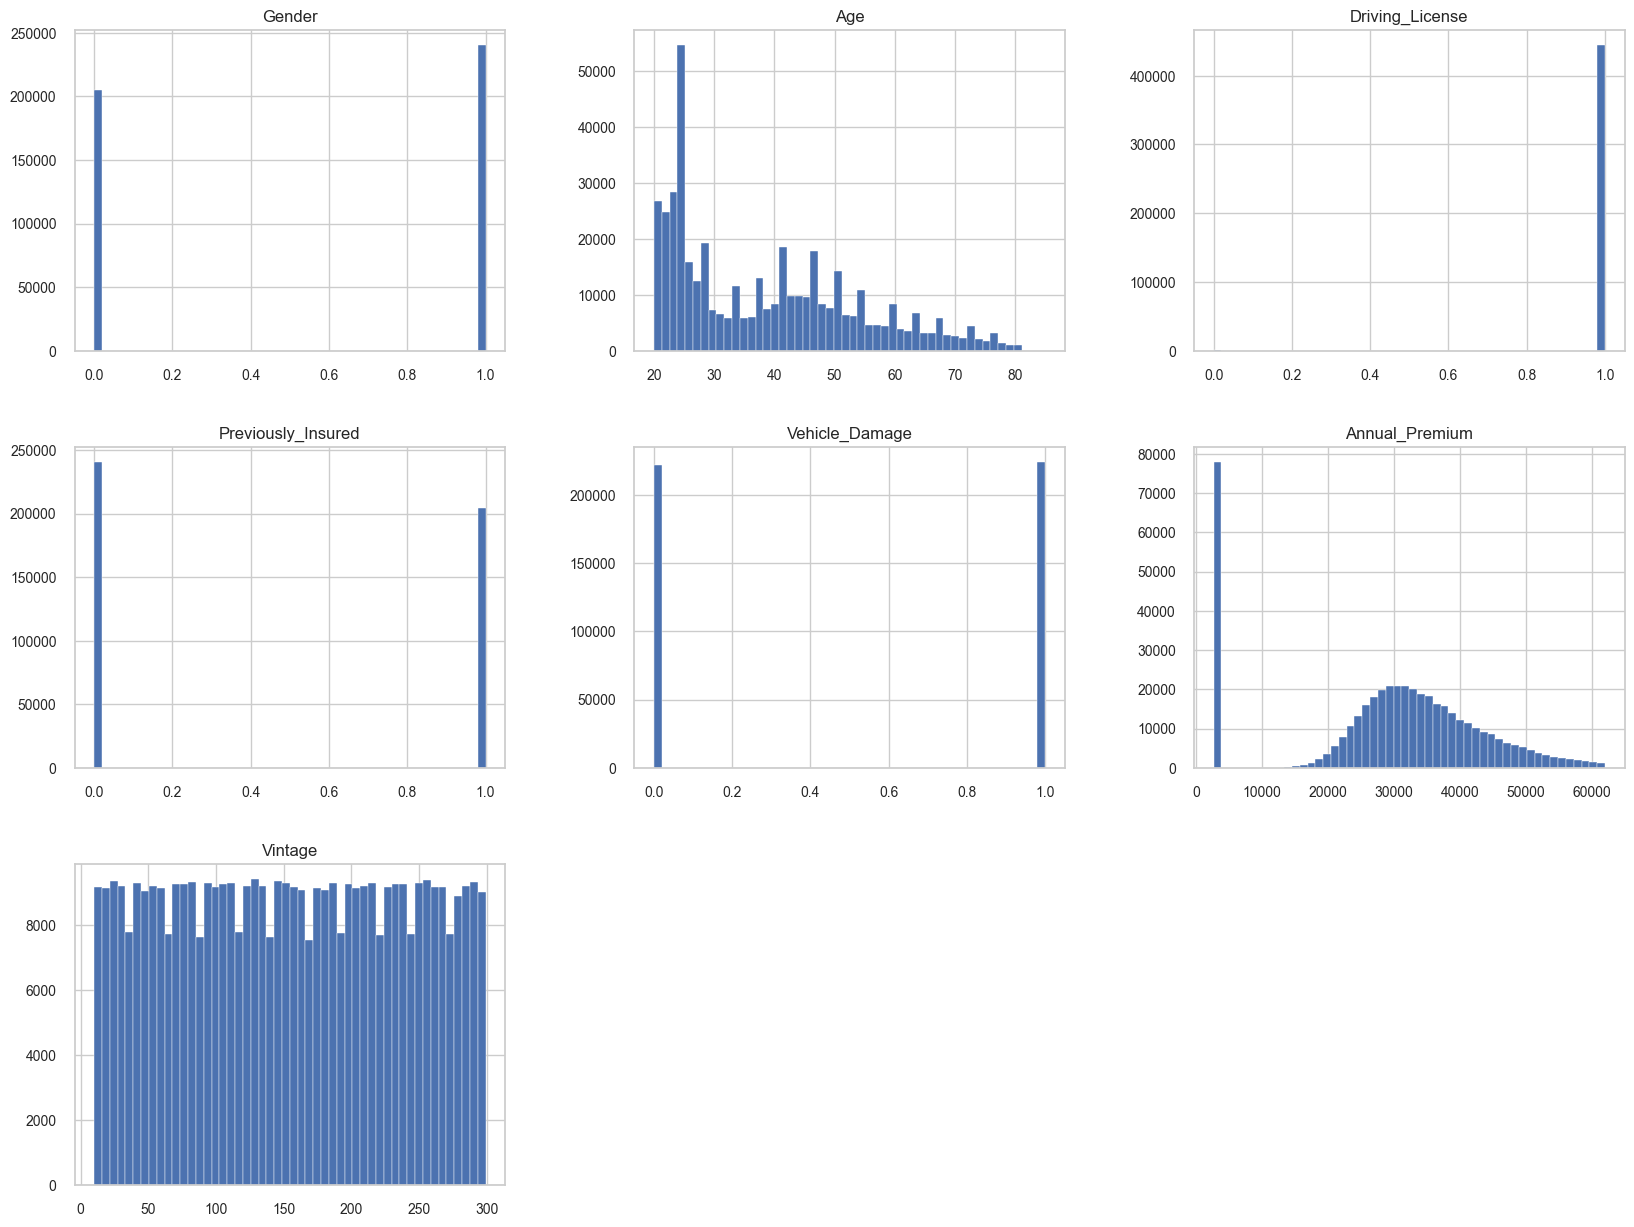

In [92]:
train_set.hist(bins = 50, figsize = (20,15) )
plt.show()

We can see an anomalous peak in the histogram for the attribute Annual_Premium

In [93]:
train_set['Annual_Premium'] = pd.cut(train_set.Annual_Premium, bins = [-0.1,15000.,30000.,45000.,60000.,75000.,np.inf], labels=[0,1,2,3,4,5])
test_set['Annual_Premium'] = pd.cut(test_set.Annual_Premium, bins = [-0.1,15000.,30000.,45000.,60000.,75000.,np.inf], labels=[0,1,2,3,4,5])

In [94]:
train_set=train_set.astype({"Annual_Premium":int})
test_set=test_set.astype({"Annual_Premium":int})

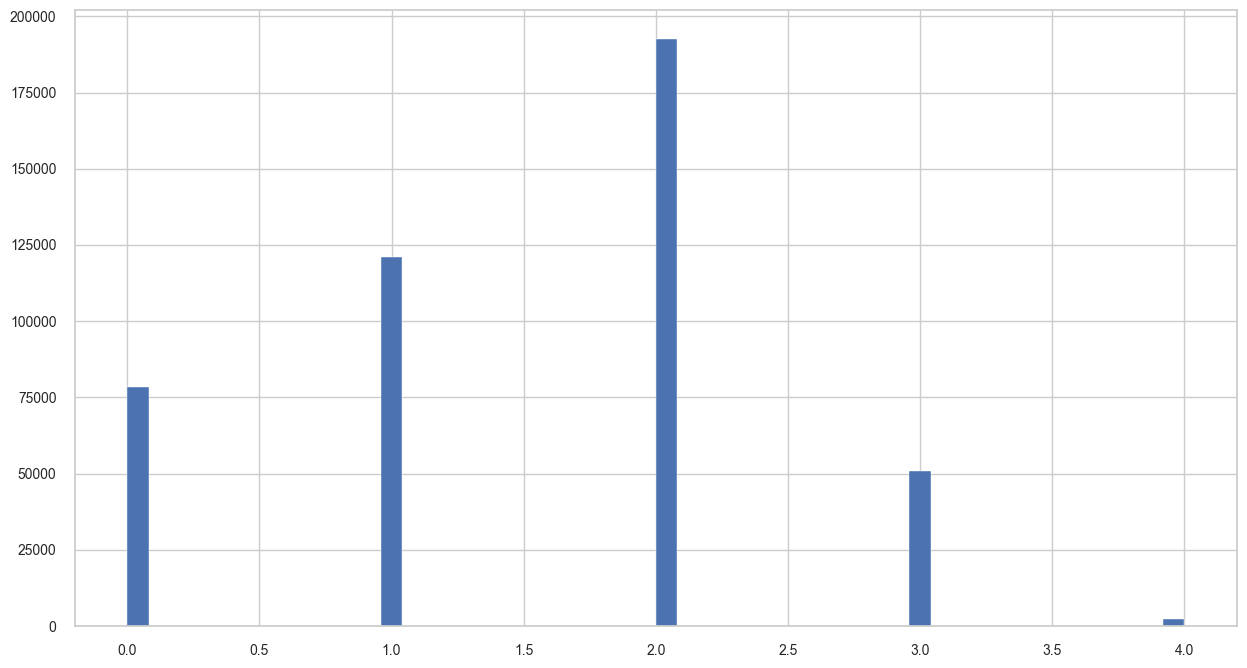

In [95]:
train_set.Annual_Premium.hist(bins = 50, figsize = (15,8) )
plt.show()

In [96]:
train_set["Annual_Premium"].value_counts()

Annual_Premium
2    192462
1    121111
0     78279
3     50907
4      2315
Name: count, dtype: int64

In [97]:
discretize = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
oneHot = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

In [98]:
cat1 = ["Region_Code","Policy_Sales_Channel","Vehicle_Age"]
val1 = ["Age","Vintage"]

pipe = Pipeline([
        ('discretize',discretize)
])

pipe2 = Pipeline([
        ('onehot',oneHot)
    ])


In [99]:
full_pipeline = ColumnTransformer([
       ("pipe", pipe, val1),
        ("pipe2", pipe2, cat1),       
],remainder='passthrough')

X_train, Y_train = pd.DataFrame(full_pipeline.fit_transform(train_set)), pd.DataFrame(labels_train.values.reshape(-1))
names = full_pipeline.get_feature_names_out()

for i in range(len(names)):
    names[i]=names[i].split("__")[1]  

X_train.columns = names
X_test, Y_test = pd.DataFrame(full_pipeline.transform(test_set)), pd.DataFrame(labels_test.values.reshape(-1))
X_test.columns = names
Y_train.columns = np.array(['Response'])
Y_test.columns = np.array(['Response'])


In [100]:
X_train = X_train.astype('int')
Y_train = Y_train.astype('int')
X_test = X_test.astype('int')
Y_test = Y_test.astype('int')

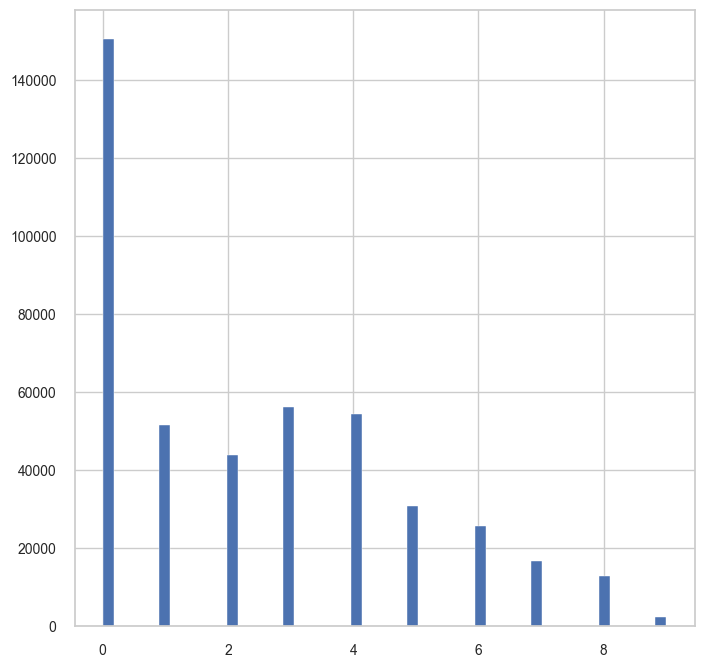

In [101]:
X_train.Age.hist(bins = 50, figsize = (8,8) )
plt.show()

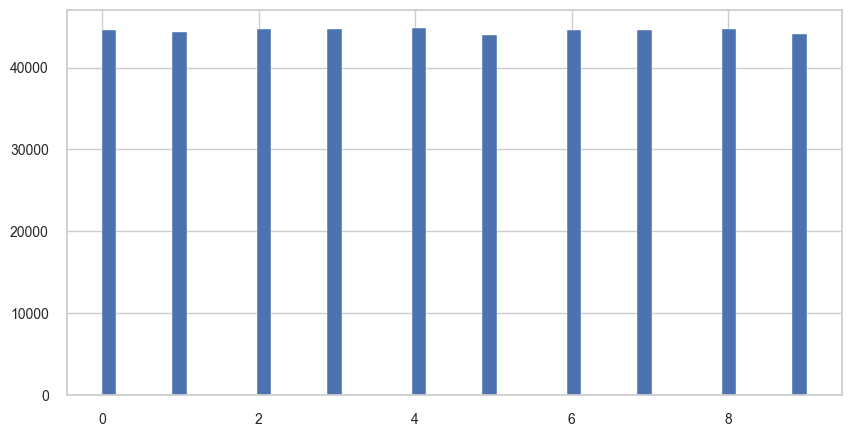

In [102]:
X_train.Vintage.hist(bins = 50, figsize = (10,5) )
plt.show()

In [103]:
X_train

Age  Vintage  Region_Code_0  Region_Code_1  Region_Code_10  \
0         0        7              0              0               0   
1         5        8              1              0               0   
2         3        4              0              0               0   
3         4        3              0              0               0   
4         0        9              0              0               0   
...     ...      ...            ...            ...             ...   
445069    0        9              0              0               0   
445070    5        9              0              0               0   
445071    0        2              0              0               0   
445072    3        1              0              0               0   
445073    1        4              0              0               0   

        Region_Code_11  Region_Code_12  Region_Code_13  Region_Code_14  \
0                    0               0               0               0   
1                    0               0               0               0   
2                    0               0               0               0   
3                    0               0               0               0   
4                    0               0               0               0   
...                ...             ...             ...             ...   
445069               0               0               0               0   
445070               0               0               0               0   
445071               0               0               0               0   
445072               0               0               0               0   
445073               0               0               0               0   

        Region_Code_15  ...  Policy_Sales_Channel_98  Policy_Sales_Channel_99  \
0                    0  ...                        0                        0   
1                    0  ...                        0                        0   
2                    0  ...                        0                        0   
3                    0  ...                        0                        0   
4                    0  ...                        0                        0   
...                ...  ...                      ...                      ...   
445069               0  ...                        0                        0   
445070               0  ...                        0                        0   
445071               0  ...                        0                        0   
445072               0  ...                        0                        0   
445073               0  ...                        0                        0   

        Vehicle_Age_1-2 Year  Vehicle_Age_< 1 Year  Vehicle_Age_> 2 Years  \
0                          0                     1                      0   
1                          1                     0                      0   
2                          1                     0                      0   
3                          1                     0                      0   
4                          1                     0                      0   
...                      ...                   ...                    ...   
445069                     0                     1                      0   
445070                     1                     0                      0   
445071                     0                     1                      0   
445072                     1                     0                      0   
445073                     0                     1                      0   

        Gender  Driving_License  Previously_Insured  Vehicle_Damage  \
0            0                1                   0               0   
1            0                1                   0               1   
2            0                1                   1               0   
3            1                1                   0               1   
4            1           

In [104]:
X_test

Age  Vintage  Region_Code_0  Region_Code_1  Region_Code_10  \
0        0        3              0              0               0   
1        2        6              0              0               0   
2        0        1              0              0               0   
3        0        6              0              0               0   
4        8        8              0              0               0   
...    ...      ...            ...            ...             ...   
49392    1        1              0              0               0   
49393    0        8              0              0               0   
49394    0        3              0              0               0   
49395    0        6              0              0               0   
49396    6        4              0              0               0   

       Region_Code_11  Region_Code_12  Region_Code_13  Region_Code_14  \
0                   0               0               0               0   
1                   1               0               0               0   
2                   0               0               0               0   
3                   0               0               0               0   
4                   0               0               0               0   
...               ...             ...             ...             ...   
49392               0               0               0               0   
49393               0               0               0               0   
49394               0               0               0               0   
49395               0               1               0               0   
49396               0               0               0               0   

       Region_Code_15  ...  Policy_Sales_Channel_98  Policy_Sales_Channel_99  \
0                   0  ...                        0                        0   
1                   0  ...                        0                        0   
2                   0  ...                        0                        0   
3                   0  ...                        0                        0   
4                   0  ...                        0                        0   
...               ...  ...                      ...                      ...   
49392               0  ...                        0                        0   
49393               0  ...                        0                        0   
49394               0  ...                        0                        0   
49395               0  ...                        0                        0   
49396               0  ...                        0                        0   

       Vehicle_Age_1-2 Year  Vehicle_Age_< 1 Year  Vehicle_Age_> 2 Years  \
0                         0                     1                      0   
1                         1                     0                      0   
2                         0                     1                      0   
3                         0                     1                      0   
4                         1                     0                      0   
...                     ...                   ...                    ...   
49392                     1                     0                      0   
49393                     0                     1                      0   
49394                     0                     1                      0   
49395                     0                     1                      0   
49396                     1                     0                      0   

       Gender  Driving_License  Previously_Insured  Vehicle_Damage  \
0           0                1                   1               1   
1           1                1                   0               1   
2           0                1                   1               0   
3           1                1                   1               0   
4           1                1                   1               0   
...    

In [105]:
Y_train

Response
0              0
1              0
2              0
3              0
4              0
...          ...
445069         0
445070         0
445071         0
445072         0
445073         1

[445074 rows x 1 columns]

In [106]:
#to display all columns (which it did not display before)
Xt_df=pd.DataFrame(X_train)
pd.set_option('display.max_columns', None)
Xt_df

Age  Vintage  Region_Code_0  Region_Code_1  Region_Code_10  \
0         0        7              0              0               0   
1         5        8              1              0               0   
2         3        4              0              0               0   
3         4        3              0              0               0   
4         0        9              0              0               0   
...     ...      ...            ...            ...             ...   
445069    0        9              0              0               0   
445070    5        9              0              0               0   
445071    0        2              0              0               0   
445072    3        1              0              0               0   
445073    1        4              0              0               0   

        Region_Code_11  Region_Code_12  Region_Code_13  Region_Code_14  \
0                    0               0               0               0   
1                    0               0               0               0   
2                    0               0               0               0   
3                    0               0               0               0   
4                    0               0               0               0   
...                ...             ...             ...             ...   
445069               0               0               0               0   
445070               0               0               0               0   
445071               0               0               0               0   
445072               0               0               0               0   
445073               0               0               0               0   

        Region_Code_15  Region_Code_16  Region_Code_17  Region_Code_18  \
0                    0               0               0               0   
1                    0               0               0               0   
2                    0               0               0               0   
3                    0               0               0               0   
4                    0               0               0               0   
...                ...             ...             ...             ...   
445069               0               0               0               0   
445070               0               0               0               0   
445071               0               0               0               0   
445072               0               0               0               0   
445073               0               0               0               0   

        Region_Code_19  Region_Code_2  Region_Code_20  Region_Code_21  \
0                    0              0               0               0   
1                    0              0               0               0   
2                    0              0               0               0   
3                    0              0               0               0   
4                    0              0               0               0   
...                ...            ...             ...             ...   
445069               0              0               0               0   
445070               0              0               0               0   
445071               0              1               0               0   
445072               0              0               0               0   
445073               0              0               0               0   

        Region_Code_22  Region_Code_23  Region_Code_24  Region_Code_25  \
0                    0               0               0               0   
1                    0               0               0               0   
2                    0               0               0               1   
3                    0               0               0               0   
4                    0               0               0               0   
...                ...             ...             ...             .

In [107]:
X_train.shape

(445074, 218)

In [108]:
X_test.shape

(49397, 218)

In [109]:
Y_train.shape

(445074, 1)

In [110]:
Y_test.shape

(49397, 1)

### Undersampling

In [111]:
rus = RandomUnderSampler(random_state=42)
X_res, Y_res = rus.fit_resample(X_train, Y_train)

In [112]:
X_res

Age  Vintage  Region_Code_0  Region_Code_1  Region_Code_10  \
0        5        4              0              0               0   
1        4        6              0              0               0   
2        4        3              0              0               0   
3        0        6              0              0               0   
4        0        8              0              0               0   
...    ...      ...            ...            ...             ...   
81307    4        7              0              0               0   
81308    4        3              0              0               0   
81309    1        1              0              0               0   
81310    3        3              0              0               0   
81311    1        4              0              0               0   

       Region_Code_11  Region_Code_12  Region_Code_13  Region_Code_14  \
0                   0               0               0               0   
1                   0               0               0               0   
2                   0               0               0               0   
3                   0               0               0               0   
4                   0               0               0               0   
...               ...             ...             ...             ...   
81307               0               0               0               0   
81308               0               0               0               0   
81309               0               0               0               0   
81310               0               0               0               0   
81311               0               0               0               0   

       Region_Code_15  Region_Code_16  Region_Code_17  Region_Code_18  \
0                   0               0               0               0   
1                   0               0               0               0   
2                   0               0               0               0   
3                   0               0               0               0   
4                   0               0               0               0   
...               ...             ...             ...             ...   
81307               0               0               0               0   
81308               0               0               0               0   
81309               0               0               0               0   
81310               0               0               0               0   
81311               0               0               0               0   

       Region_Code_19  Region_Code_2  Region_Code_20  Region_Code_21  \
0                   0              0               1               0   
1                   0              0               0               0   
2                   0              0               0               0   
3                   0              0               0               0   
4                   0              0               0               0   
...               ...            ...             ...             ...   
81307               0              0               0               1   
81308               0              0               0               0   
81309               0              0               0               0   
81310               0              0               0               0   
81311               0              0               0               0   

       Region_Code_22  Region_Code_23  Region_Code_24  Region_Code_25  \
0                   0               0               0               0   
1                   0               0               0               1   
2                   0               0               0               0   
3                   0               0               0               0   
4                   0               0               1               0   
...               ...             ...             ...             ...   
81307               0               0           

In [113]:
Y_res

Response
0             0
1             0
2             0
3             0
4             0
...         ...
81307         1
81308         1
81309         1
81310         1
81311         1

[81312 rows x 1 columns]

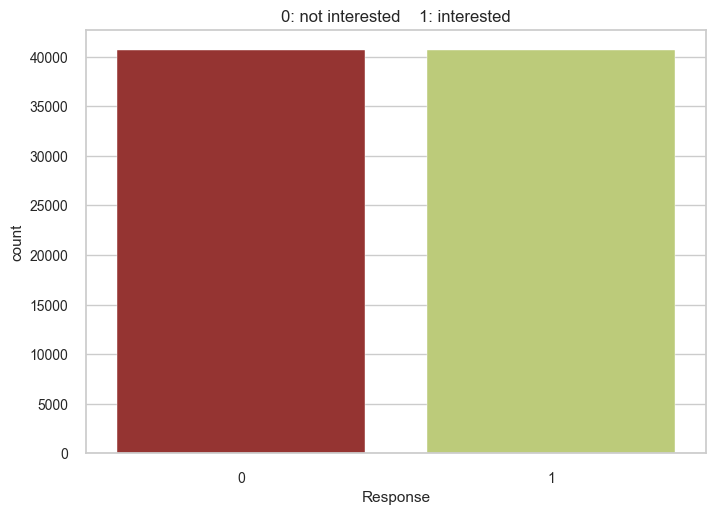

In [114]:
sns.countplot(x='Response',data=Y_res,palette=["#A52422","#C5D86D"])
plt.title("0: not interested    1: interested")
plt.show()

In [115]:
X_res.shape

(81312, 218)

In [116]:
X_test.shape

(49397, 218)

### Feature Selection

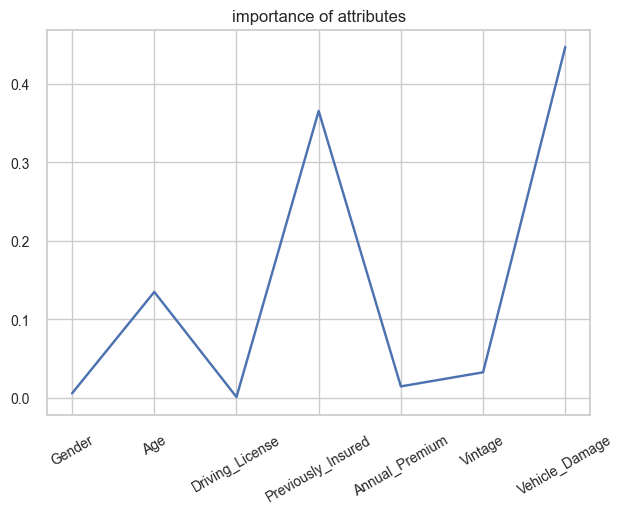

In [117]:
column = ['Gender','Age','Driving_License','Previously_Insured','Annual_Premium','Vintage','Vehicle_Damage']
#column = X_res.columns
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
train_X = X_res.copy()
train_X = train_X[column]

label=Y_res["Response"]
rnd_clf.fit(train_X,label)   
fig, ax = plt.subplots(1,1)
fig.set_size_inches(7,5)
ax.plot(rnd_clf.feature_importances_,'b-')
#print(rnd_clf.feature_importances_)
firstTen(rnd_clf.feature_importances_) 
ax.set_xticks([i for i in range(len(column))])
xlabels = ax.set_xticklabels(column,rotation=30, fontsize=10)
_=ax.set_title('importance of attributes')

It is recalled that in the correlation analysis the attributes Previously_Insured and Vehicle_Damage appear to be strongly correlated, and intuitively I had stated that insurance claims are an important element in the insurance field with respect to whether a customer is changing insurance or making a new one. Feature selection confirms this intuition, the graph of which shows that the Vehicle_Damage attribute is more important than Previously_Insured, so I proceed to delete the latter. 

In [118]:
X_res.drop(labels='Previously_Insured', axis=1, inplace = True)
X_test.drop(labels='Previously_Insured', axis=1, inplace = True)

## 5) Training classification models

### Decision Tree

In [119]:
#Decision Tree
DTree_clf = DecisionTreeClassifier(class_weight='balanced', max_depth=11, min_samples_split = 200, random_state=21).fit(X_res, Y_res)
test_score_dt = DTree_clf.score(X_test,Y_test)
training_score_dt = DTree_clf.score(X_res,Y_res)
print("Training Score : %.3f ," %training_score_dt, " Test Score : %.3f "  %test_score_dt)

Training Score : 0.782 ,  Test Score : 0.675 


              precision    recall  f1-score   support

           0       0.99      0.65      0.78     44887
           1       0.21      0.91      0.34      4510

    accuracy                           0.68     49397
   macro avg       0.60      0.78      0.56     49397
weighted avg       0.91      0.68      0.74     49397



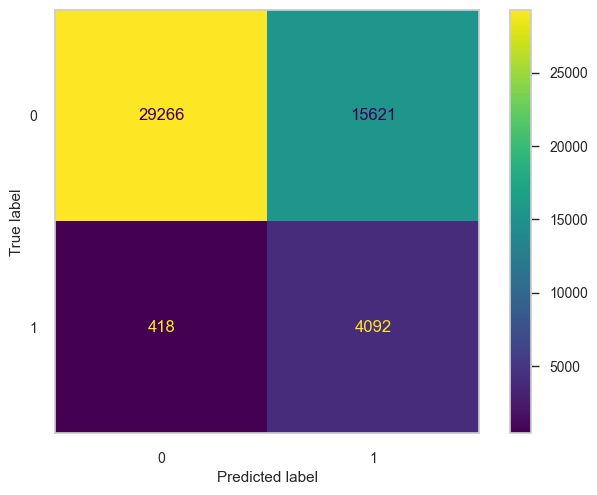

In [120]:
y_pred_test = DTree_clf.predict(X_test)
cm = confusion_matrix(Y_test, y_pred_test)
cmd=ConfusionMatrixDisplay(cm)
cmd.plot()
plt.grid(False)

precision0_dt = precision_score(Y_test, y_pred_test,pos_label=0)
precision1_dt = precision_score(Y_test, y_pred_test)
recall0_dt = recall_score(Y_test,y_pred_test,pos_label=0)
recall1_dt = recall_score(Y_test,y_pred_test)
f1score0_dt = f1_score(Y_test,y_pred_test,pos_label=0)
f1score1_dt = f1_score(Y_test,y_pred_test)

print(classification_report(Y_test, y_pred_test))

#### Please note: 
 1. a model that does not produce false positives has a "precision" of 1.0 
 2. a model that does not produce false negatives has a "recall" of 1.0

### SGD

In [121]:
# SGD {'alpha': 0.001, 'loss': 'log', 'max_iter': 100, 'penalty': 'l2'}
sgd_clf = SGDClassifier(max_iter=5, tol = 0.001, loss='log',random_state=42)
sgd_clf.fit(X_res, Y_res)

test_score_sgd = sgd_clf.score(X_test,Y_test)
training_score_sgd = sgd_clf.score(X_res,Y_res)
print("Training Score : %.3f ," %training_score_sgd, " Test Score : %.3f "  %test_score_sgd)

Training Score : 0.608 ,  Test Score : 0.841 


The accuracy on the training is lower than the accuracy on the test, meaning that the model is performing better on the test data than on the training data. This could suggest that the model is not fully learning the specific details of the training data, but is instead learning patterns that generalise better on new data. These results are not good and I will attempt to fix them with a cross-validation later. (Values, however, that do not appear unless I perform outlier elimination)

              precision    recall  f1-score   support

           0       0.93      0.89      0.91     44887
           1       0.23      0.32      0.27      4510

    accuracy                           0.84     49397
   macro avg       0.58      0.61      0.59     49397
weighted avg       0.87      0.84      0.85     49397



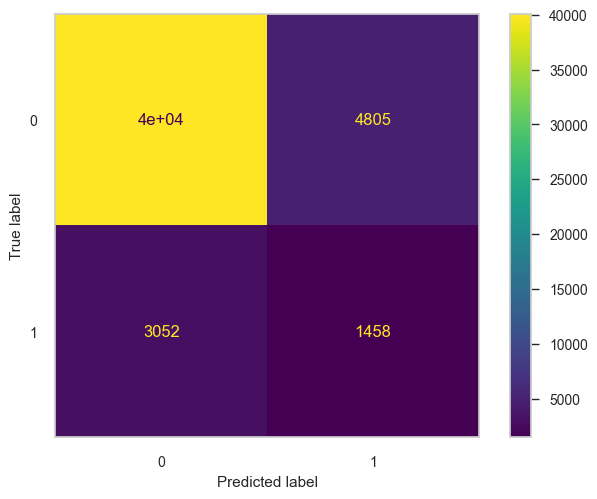

In [122]:
y_pred_test = sgd_clf.predict(X_test)
cm = confusion_matrix(Y_test, y_pred_test)
cmd=ConfusionMatrixDisplay(cm)
cmd.plot()
plt.grid(False)

precision0_sgd = precision_score(Y_test, y_pred_test,pos_label=0)
precision1_sgd = precision_score(Y_test, y_pred_test)
recall0_sgd = recall_score(Y_test,y_pred_test,pos_label=0)
recall1_sgd = recall_score(Y_test,y_pred_test)
f1score0_sgd = f1_score(Y_test,y_pred_test,pos_label=0)
f1score1_sgd = f1_score(Y_test,y_pred_test)

print(classification_report(Y_test, y_pred_test))

### LinearSVC

In [123]:
#LinearSVC
svc_clf = LinearSVC(max_iter = 600)
svc_clf.fit(X_res, Y_res)

test_score_svc = svc_clf.score(X_test,Y_test)
training_score_svc = svc_clf.score(X_res,Y_res)
print("Training Score : %.3f ," %training_score_svc, " Test Score : %.3f "  %test_score_svc)

Training Score : 0.777 ,  Test Score : 0.641 


              precision    recall  f1-score   support

           0       0.99      0.61      0.76     44887
           1       0.20      0.95      0.33      4510

    accuracy                           0.64     49397
   macro avg       0.59      0.78      0.54     49397
weighted avg       0.92      0.64      0.72     49397



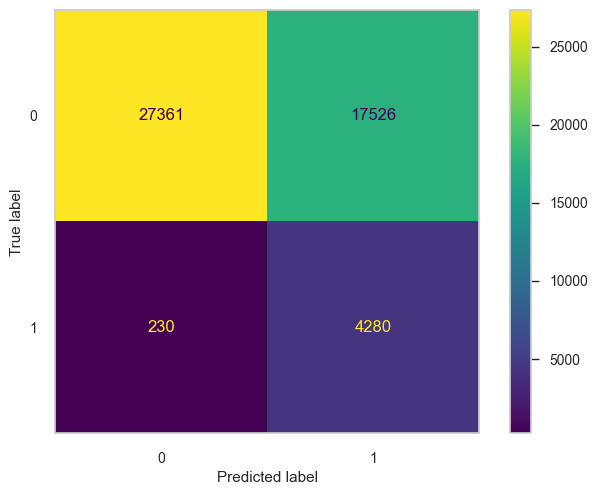

In [124]:
y_pred_test = svc_clf.predict(X_test)
cm = confusion_matrix(Y_test, y_pred_test)
cmd=ConfusionMatrixDisplay(cm)
cmd.plot()
plt.grid(False)

precision0_svc = precision_score(Y_test, y_pred_test,pos_label=0)
precision1_svc = precision_score(Y_test, y_pred_test)
recall0_svc = recall_score(Y_test,y_pred_test,pos_label=0)
recall1_svc = recall_score(Y_test,y_pred_test)
f1score0_svc = f1_score(Y_test,y_pred_test,pos_label=0)
f1score1_svc = f1_score(Y_test,y_pred_test)

print(classification_report(Y_test, y_pred_test))

### Logistic Regression

In [125]:
lr_clf = LogisticRegression(random_state=42)
lr_clf.fit(X_res, Y_res)

test_score_lr = lr_clf.score(X_test,Y_test)
training_score_lr = lr_clf.score(X_res,Y_res)
print("Training Score : %.3f ," %training_score_lr, " Test Score : %.3f "  %test_score_lr)

Training Score : 0.778 ,  Test Score : 0.668 


              precision    recall  f1-score   support

           0       0.99      0.64      0.78     44887
           1       0.21      0.92      0.34      4510

    accuracy                           0.67     49397
   macro avg       0.60      0.78      0.56     49397
weighted avg       0.92      0.67      0.74     49397



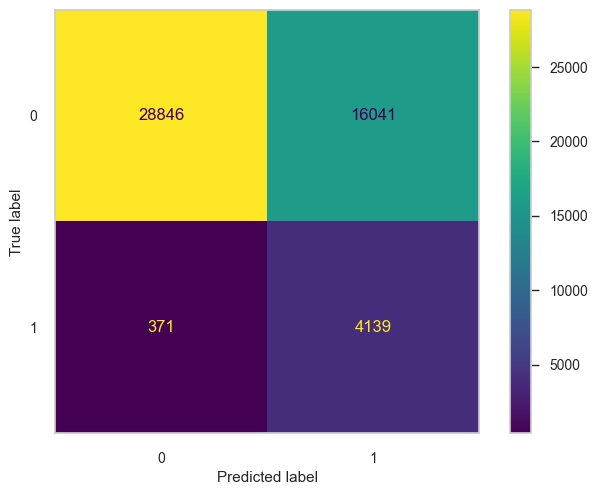

In [126]:
y_pred_test = lr_clf.predict(X_test)
cm = confusion_matrix(Y_test, y_pred_test)
cmd=ConfusionMatrixDisplay(cm)
cmd.plot()
plt.grid(False)

precision0_lr = precision_score(Y_test, y_pred_test,pos_label=0)
precision1_lr = precision_score(Y_test, y_pred_test)
recall0_lr = recall_score(Y_test,y_pred_test,pos_label=0)
recall1_lr = recall_score(Y_test,y_pred_test)
f1score0_lr = f1_score(Y_test,y_pred_test,pos_label=0)
f1score1_lr = f1_score(Y_test,y_pred_test)

print(classification_report(Y_test, y_pred_test))

### Gaussian Naive Bayes

In [127]:
nb_clf = GaussianNB(var_smoothing = 1e-3)
nb_clf = nb_clf.fit(X_res, Y_res)

test_score_nb = nb_clf.score(X_test,Y_test)
training_score_nb = nb_clf.score(X_res,Y_res)
print("Training Score : %.3f ," %training_score_nb, " Test Score : %.3f "  %test_score_nb)

Training Score : 0.758 ,  Test Score : 0.702 


              precision    recall  f1-score   support

           0       0.98      0.69      0.81     44887
           1       0.21      0.83      0.34      4510

    accuracy                           0.70     49397
   macro avg       0.59      0.76      0.57     49397
weighted avg       0.91      0.70      0.76     49397



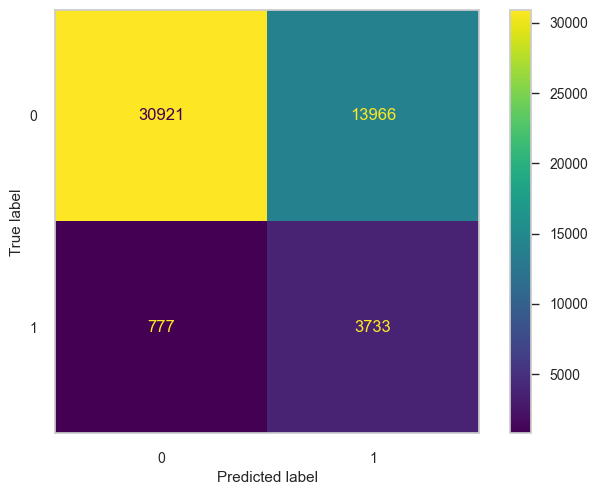

In [128]:
y_pred_test = nb_clf.predict(X_test)
cm = confusion_matrix(Y_test, y_pred_test)
cmd=ConfusionMatrixDisplay(cm)
cmd.plot()
plt.grid(False)

precision0_nb = precision_score(Y_test, y_pred_test,pos_label=0)
precision1_nb = precision_score(Y_test, y_pred_test)
recall0_nb = recall_score(Y_test,y_pred_test,pos_label=0)
recall1_nb = recall_score(Y_test,y_pred_test)
f1score0_nb = f1_score(Y_test,y_pred_test,pos_label=0)
f1score1_nb = f1_score(Y_test,y_pred_test)

print(classification_report(Y_test, y_pred_test))

In [129]:
#from sklearn.metrics import precision_recall_curve
#probabilities = lr_clf.predict_proba(X_test)
#precision, recall, thresholds = precision_recall_curve(Y_test, probabilities[:, 1])
# Vectorized operation:
#f1_scores = 2 * recall * precision / (recall + precision)
#best_f1 = np.max(f1_scores)
#best_thresh = thresholds[np.argmax(f1_scores)]
#best_predictions = (probabilities[:, 1] > best_thresh).astype(int)
#print("miglior threshold: "+ str(best_thresh))

## Model reports

#### Decision Tree

In [130]:
print("Accuracy training: " + str(training_score_dt))
print("Accuracy test: " + str(test_score_dt))
print("")
print("Precision class 0: " + str(precision0_dt))
print("Precision class 1: " + str(precision1_dt))
print("")
print("Recall class 0: " + str(recall0_dt))
print("Recall class 1: " + str(recall1_dt) + " [Important]")
print("")
print("F1 Score Class 0: " + str(f1score0_dt))
print("F1 Score Class 1: " + str(f1score1_dt))

Accuracy training: 0.7817173356946084
Accuracy test: 0.675304168269328

Precision class 0: 0.9859183398463819
Precision class 1: 0.20757875513620452

Recall class 0: 0.6519927818744848
Recall class 1: 0.9073170731707317 [Important]

F1 Score Class 0: 0.7849163884083626
F1 Score Class 1: 0.33786071089460423


#### Stochastic Gradient Descent

In [131]:
print("Accuracy training: " + str(training_score_sgd))
print("Accuracy test: " + str(test_score_sgd))
print("")
print("Precision class 0: " + str(precision0_sgd))
print("Precision class 1: " + str(precision1_sgd))
print("")
print("Recall class 0: " + str(recall0_sgd))
print("Recall class 1: " + str(recall1_sgd) + " [Important]")
print("")
print("F1 Score Class 0: " + str(f1score0_sgd))
print("F1 Score Class 1: " + str(f1score1_sgd))

Accuracy training: 0.6083603896103896
Accuracy test: 0.8409417575966152

Precision class 0: 0.9292437520285621
Precision class 1: 0.23279578476768323

Recall class 0: 0.8929534163566288
Recall class 1: 0.3232815964523282 [Important]

F1 Score Class 0: 0.9107372104384182
F1 Score Class 1: 0.27067669172932335


#### Linear Support Vector Classifier

In [132]:
print("Accuracy training: " + str(training_score_svc))
print("Accuracy test: " + str(test_score_svc))
print("")
print("Precision class 0: " + str(precision0_svc))
print("Precision class 1: " + str(precision1_svc))
print("")
print("Recall class 0: " + str(recall0_svc))
print("Recall class 1: " + str(recall1_svc) + " [Important]")
print("")
print("F1 Score Class 0: " + str(f1score0_svc))
print("F1 Score Class 1: " + str(f1score1_svc))

Accuracy training: 0.777142365210547
Accuracy test: 0.6405449723667429

Precision class 0: 0.9916639483889674
Precision class 1: 0.19627625424195175

Recall class 0: 0.6095528772250317
Recall class 1: 0.9490022172949002 [Important]

F1 Score Class 0: 0.7550153149921355
F1 Score Class 1: 0.3252773977808177


#### Logistic Regression

In [133]:
print("Accuracy training: " + str(training_score_lr))
print("Accuracy test: " + str(test_score_lr))
print("")
print("Precision class 0: " + str(precision0_lr))
print("Precision class 1: " + str(precision1_lr))
print("")
print("Recall class 0: " + str(recall0_lr))
print("Recall class 1: " + str(recall1_lr) + " [Important]")
print("")
print("F1 Score Class 0: " + str(f1score0_lr))
print("F1 Score Class 1: " + str(f1score1_lr))

Accuracy training: 0.7775728059818969
Accuracy test: 0.6677531024151264

Precision class 0: 0.9873019132696718
Precision class 1: 0.20510406342913776

Recall class 0: 0.6426359525029518
Recall class 1: 0.9177383592017738 [Important]

F1 Score Class 0: 0.7785274749001403
F1 Score Class 1: 0.33527744025921424


#### Gaussian Naive Bayes

In [134]:
print("Accuracy training: " + str(training_score_nb))
print("Accuracy test: " + str(test_score_nb))
print("")
print("Precision class 0: " + str(precision0_nb))
print("Precision class 1: " + str(precision1_nb))
print("")
print("Recall class 0: " + str(recall0_nb))
print("Recall class 1: " + str(recall1_nb) + " [Important]")
print("")
print("F1 Score Class 0: " + str(f1score0_nb))
print("F1 Score Class 1: " + str(f1score1_nb))

Accuracy training: 0.7577971271153089
Accuracy test: 0.7015405793874122

Precision class 0: 0.9754874124550444
Precision class 1: 0.2109158709531612

Recall class 0: 0.6888631452313587
Recall class 1: 0.8277161862527717 [Important]

F1 Score Class 0: 0.8074949402624535
F1 Score Class 1: 0.33617002116259176


### Accuracy in comparison

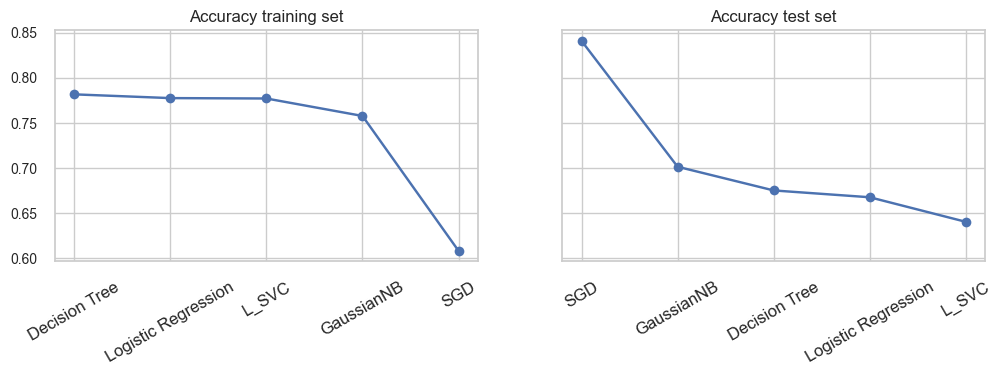

In [135]:
train_ac = [training_score_dt, training_score_sgd, training_score_svc, training_score_lr, training_score_nb]
test_ac = [test_score_dt, test_score_sgd, test_score_svc, test_score_lr, test_score_nb]
labels = ['Decision Tree', 'SGD', 'L_SVC','Logistic Regression','GaussianNB']

score_train = ordina_decrescente(labels, train_ac)
score_test = ordina_decrescente(labels, test_ac)

fig, axes = plt.subplots(1, 2, sharey = True)
fig.set_size_inches(12, 3)
axes[0].plot(score_train[1],'bo-')
axes[1].plot(score_test[1],'bo-')
axes[0].set_xticks([i for i in range(len(labels))])
axes[1].set_xticks([i for i in range(len(labels))])
axes[0].set_xticklabels(score_train[0], rotation=30, fontsize=12)
axes[1].set_xticklabels(score_test[0], rotation=30, fontsize=12)
_=axes[0].set_title('Accuracy training set')
_=axes[1].set_title('Accuracy test set')


### Precision in comparison

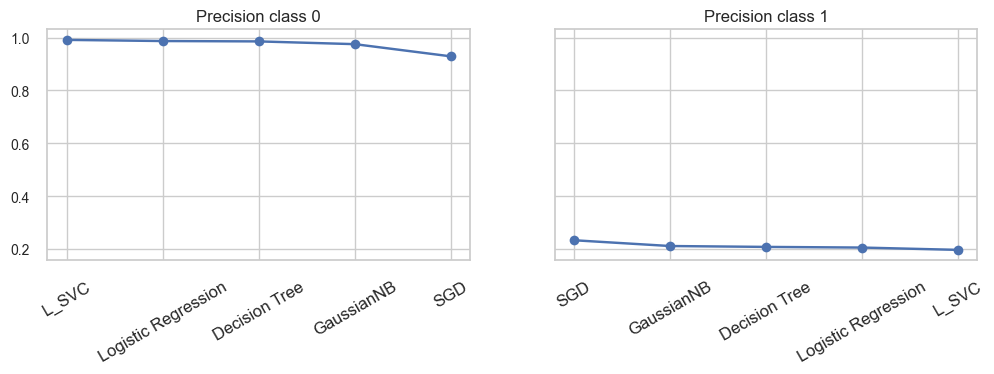

In [136]:
labels = ['Decision Tree', 'SGD', 'L_SVC','Logistic Regression','GaussianNB']
precision0 = [precision0_dt, precision0_sgd, precision0_svc, precision0_lr, precision0_nb]
precision1 = [precision1_dt, precision1_sgd, precision1_svc, precision1_lr, precision1_nb]

score_0 = ordina_decrescente(labels, precision0)
score_1 = ordina_decrescente(labels, precision1)

fig, axes = plt.subplots(1, 2, sharey = True)
fig.set_size_inches(12, 3)
axes[0].plot(score_0[1],'bo-')
axes[1].plot(score_1[1],'bo-')
axes[0].set_xticks([i for i in range(len(labels))])
axes[1].set_xticks([i for i in range(len(labels))])
axes[0].set_xticklabels(score_0[0], rotation=30, fontsize=12)
axes[1].set_xticklabels(score_1[0], rotation=30, fontsize=12)
_=axes[0].set_title('Precision class 0')
_=axes[1].set_title('Precision class 1')

### Recall in comparison

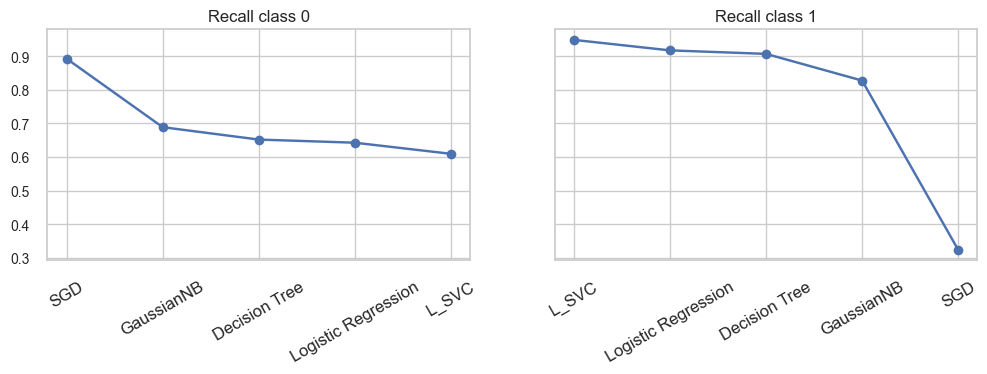

In [137]:
labels = ['Decision Tree', 'SGD', 'L_SVC','Logistic Regression','GaussianNB']
recall0 = [recall0_dt, recall0_sgd, recall0_svc, recall0_lr, recall0_nb]
recall1 = [recall1_dt, recall1_sgd, recall1_svc, recall1_lr, recall1_nb]

score_0 = ordina_decrescente(labels, recall0)
score_1 = ordina_decrescente(labels, recall1)

fig, axes = plt.subplots(1, 2, sharey = True)
fig.set_size_inches(12, 3)
axes[0].plot(score_0[1],'bo-')
axes[1].plot(score_1[1],'bo-')
axes[0].set_xticks([i for i in range(len(labels))])
axes[1].set_xticks([i for i in range(len(labels))])
axes[0].set_xticklabels(score_0[0], rotation=30, fontsize=12)
axes[1].set_xticklabels(score_1[0], rotation=30, fontsize=12)
_=axes[0].set_title('Recall class 0')
_=axes[1].set_title('Recall class 1')

### F1 Score in comparison

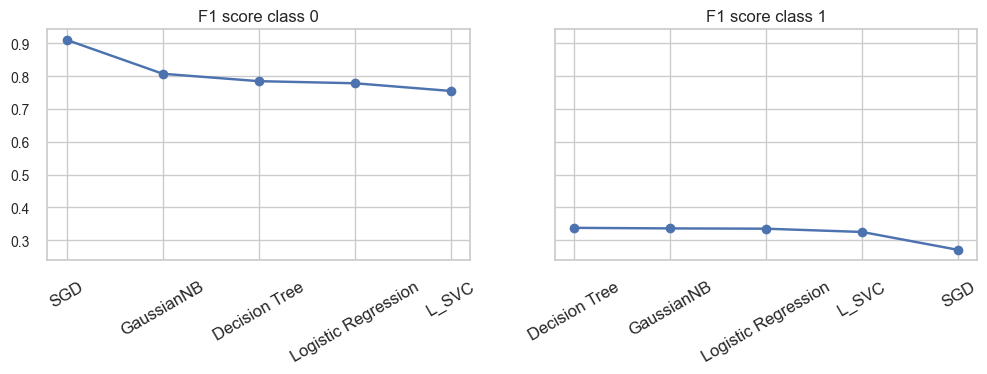

In [138]:
labels = ['Decision Tree', 'SGD', 'L_SVC','Logistic Regression','GaussianNB']
f1score0 = [f1score0_dt, f1score0_sgd, f1score0_svc, f1score0_lr, f1score0_nb]
f1score1 = [f1score1_dt, f1score1_sgd, f1score1_svc, f1score1_lr, f1score1_nb]

score_0 = ordina_decrescente(labels, f1score0)
score_1 = ordina_decrescente(labels, f1score1)

fig, axes = plt.subplots(1, 2, sharey = True)
fig.set_size_inches(12, 3)
axes[0].plot(score_0[1],'bo-')
axes[1].plot(score_1[1],'bo-')
axes[0].set_xticks([i for i in range(len(labels))])
axes[1].set_xticks([i for i in range(len(labels))])
axes[0].set_xticklabels(score_0[0], rotation=30, fontsize=12)
axes[1].set_xticklabels(score_1[0], rotation=30, fontsize=12)
_=axes[0].set_title('F1 score class 0')
_=axes[1].set_title('F1 score class 1')

I obtained very low f1score values due to the unbalanced test set, which led to a decrease in the precision values and thus to the f1score. We will note that in an ideal case of a balanced test set, the results will, on the contrary, be very satisfactory. 

### ROC Curve

To plot the ROC curve, one must first calculate the TPR and FPR for various threshold values using the function roc_curve

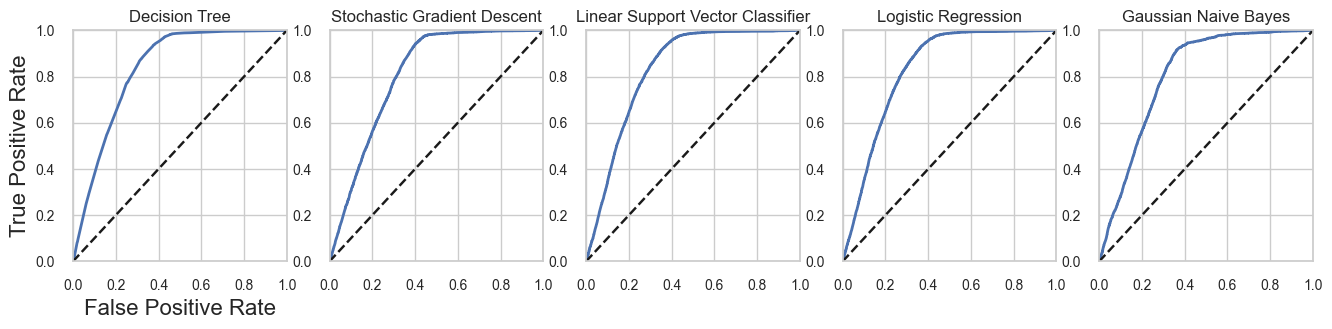

In [139]:
fig, axes = plt.subplots(1, 5)
fig.set_size_inches(16, 3)
_=axes[0].set_title('Decision Tree')
_=axes[1].set_title('Stochastic Gradient Descent')
_=axes[2].set_title('Linear Support Vector Classifier')
_=axes[3].set_title('Logistic Regression')
_=axes[4].set_title('Gaussian Naive Bayes')

#Y_res_1 = (Y_res == 1) 
## Decision tree
y_scores_dt = DTree_clf.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, thresholds_dt = roc_curve(Y_test, y_scores_dt)

plot_roc_curve(fpr_dt, tpr_dt, axes, 0)

## SGD
#y_scores_sgd = cross_val_predict(sgd_clf, X_test, Y_test.iloc[:, 0], cv = 3, method="decision_function")
#fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(Y_test, y_scores_sgd)

y_scores_sgd = sgd_clf.predict_proba(X_test)[:, 1]
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(Y_test, y_scores_sgd)

plot_roc_curve(fpr_sgd, tpr_sgd, axes, 1)

##LSVC
#y_scores_svc = cross_val_predict(svc_clf, X_test, Y_test.iloc[:, 0], cv = 3, method="decision_function")
#fpr_svc, tpr_svc, thresholds_svc = roc_curve(Y_test, y_scores_svc)

y_scores_svc = svc_clf._predict_proba_lr(X_test)[:, 1]
fpr_svc, tpr_svc, thresholds_svc = roc_curve(Y_test, y_scores_svc)

plot_roc_curve(fpr_svc, tpr_svc, axes, 2)

##Logistic regression
#y_scores_lr = cross_val_predict(lr_clf, X_test, Y_test.iloc[:, 0], cv = 3, method="decision_function")
#fpr_lr, tpr_lr, thresholds = roc_curve(Y_test, y_scores_lr)

y_scores_lr = lr_clf.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(Y_test, y_scores_lr)

plot_roc_curve(fpr_lr, tpr_lr, axes, 3)

##GaussianNB
y_scores_nb = nb_clf.predict_proba(X_test)[:, 1]
fpr_nb, tpr_nb, thresholds_nb = roc_curve(Y_test, y_scores_nb)

plot_roc_curve(fpr_nb, tpr_nb, axes, 4)

In [140]:
auc_score_dt = roc_auc_score(Y_test, y_scores_dt)
print("AUC score Decision Tree: " + str(auc_score_dt))
print()
rocaucscore_sgd = roc_auc_score(Y_test, y_scores_sgd)
print("AUC score Stochastic Gradient Descent: " + str(rocaucscore_sgd))
print()
auc_score_svc = roc_auc_score(Y_test, y_scores_svc)
print("AUC score LinearSVC: " + str(auc_score_svc))
print()
auc_score_lr = roc_auc_score(Y_test, y_scores_lr)
print("AUC score Logistic Regression: " + str(auc_score_lr))
print()
auc_score_nb = roc_auc_score(Y_test, y_scores_nb)
print("AUC score GaussianNB: " + str(auc_score_nb))

AUC score Decision Tree: 0.8335644787647841

AUC score Stochastic Gradient Descent: 0.8068910909419895

AUC score LinearSVC: 0.8295539150615068

AUC score Logistic Regression: 0.8300560135312931

AUC score GaussianNB: 0.8049615869601503


## Ideal case: balancing the test set

Since we have obtained some unsatisfactory results due to the unbalanced test set, let us now see what the model evaluations would have been in an ideal case. Obviously this is purely for teaching purposes as it is a technique that is not adopted.

Response
0    44887
1     4510
Name: count, dtype: int64


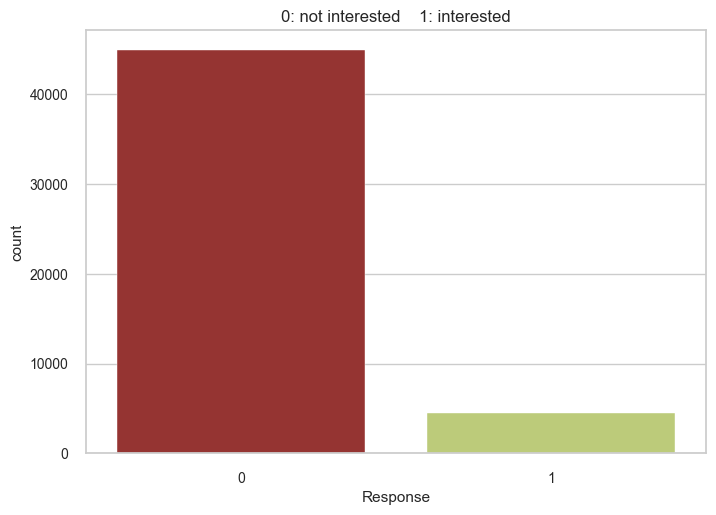

In [141]:
sns.countplot(x='Response',data=Y_test,palette=["#A52422","#C5D86D"])
plt.title("0: not interested    1: interested")
print(Y_test.Response.value_counts())
plt.show()

In this case I will use oversampling of the data, which is a very risky technique and should be used with more caution than undersampling. I use this technique primarily for exercise, but also for the fact that by undersampling I will have a test set with few records (4k). 

p.s. I've tried undersampling here too and don't notice any substantial change in performance

In [142]:
ros = RandomOverSampler(random_state=42)
X_test2, Y_test2 = ros.fit_resample(X_test, Y_test)

Response
0    44887
1    44887
Name: count, dtype: int64


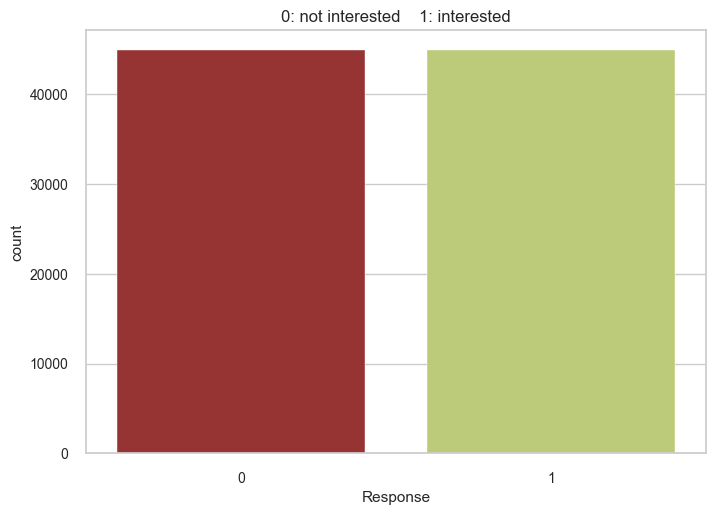

In [143]:
sns.countplot(x='Response',data=Y_test2,palette=["#A52422","#C5D86D"])
plt.title("0: not interested    1: interested")
print(Y_test2.Response.value_counts())
plt.show()

### Training Models with Balanced Test Set

#### Decision Tree

In [144]:
#Decision Tree
DTree_clf2 = DecisionTreeClassifier(class_weight='balanced',max_depth=11, min_samples_split = 200, random_state=21).fit(X_res, Y_res)

In [145]:
test_score_dt2 = DTree_clf2.score(X_test2,Y_test2)
training_score_dt2 = DTree_clf2.score(X_res,Y_res)
print("Training Score : %.3f ," %training_score_dt2, " Test Score : %.3f "  %test_score_dt2)

Training Score : 0.782 ,  Test Score : 0.780 


              precision    recall  f1-score   support

           0       0.88      0.65      0.75     44887
           1       0.72      0.91      0.80     44887

    accuracy                           0.78     89774
   macro avg       0.80      0.78      0.78     89774
weighted avg       0.80      0.78      0.78     89774



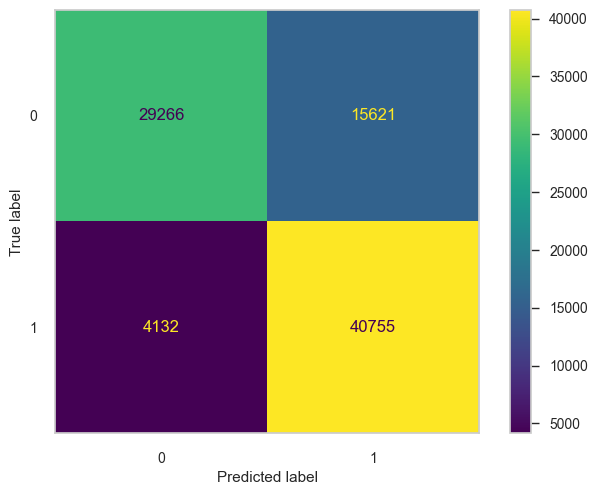

In [146]:
y_pred_test = DTree_clf2.predict(X_test2)
cm = confusion_matrix(Y_test2, y_pred_test)
cmd=ConfusionMatrixDisplay(cm)
cmd.plot()
plt.grid(False)

precision0_dt2 = precision_score(Y_test2, y_pred_test,pos_label=0)
precision1_dt2 = precision_score(Y_test2, y_pred_test)
recall0_dt2 = recall_score(Y_test2,y_pred_test,pos_label=0)
recall1_dt2 = recall_score(Y_test2,y_pred_test)
f1score0_dt2 = f1_score(Y_test2,y_pred_test,pos_label=0)
f1score1_dt2 = f1_score(Y_test2,y_pred_test)

print(classification_report(Y_test2, y_pred_test))

#### SGD

In [147]:
# SGD
sgd_clf2 = SGDClassifier(tol = 0.001, loss='log',random_state=42)
sgd_clf2.fit(X_res, Y_res)

test_score_sgd3 = sgd_clf2.score(X_test2,Y_test2)
training_score_sgd2 = sgd_clf2.score(X_res,Y_res)
print("Training Score : %.3f ," %training_score_sgd2, " Test Score : %.3f "  %test_score_sgd3)

Training Score : 0.776 ,  Test Score : 0.778 


              precision    recall  f1-score   support

           0       0.88      0.65      0.75     44887
           1       0.72      0.91      0.80     44887

    accuracy                           0.78     89774
   macro avg       0.80      0.78      0.77     89774
weighted avg       0.80      0.78      0.77     89774



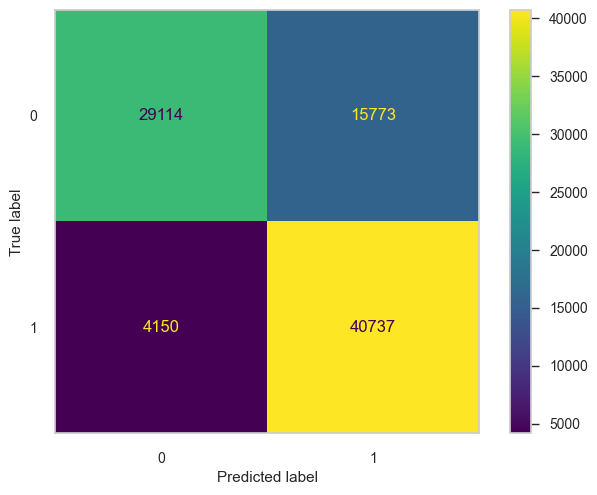

In [148]:
y_pred_test = sgd_clf2.predict(X_test2)
cm = confusion_matrix(Y_test2, y_pred_test)
cmd=ConfusionMatrixDisplay(cm)
cmd.plot()
plt.grid(False)

precision0_sgd2 = precision_score(Y_test2, y_pred_test,pos_label=0)
precision1_sgd2 = precision_score(Y_test2, y_pred_test)
recall0_sgd2 = recall_score(Y_test2,y_pred_test,pos_label=0)
recall1_sgd2 = recall_score(Y_test2,y_pred_test)
f1score0_sgd2 = f1_score(Y_test2,y_pred_test,pos_label=0)
f1score1_sgd2 = f1_score(Y_test2,y_pred_test)

print(classification_report(Y_test2, y_pred_test))

#### LinearSVC

In [149]:
#LinearSVC
svc_clf2 = LinearSVC(max_iter = 600)
svc_clf2.fit(X_res, Y_res)

test_score_svc2 = svc_clf2.score(X_test2,Y_test2)
training_score_svc2 = svc_clf2.score(X_res,Y_res)
print("Training Score : %.3f ," %training_score_svc2, " Test Score : %.3f "  %test_score_svc2)

Training Score : 0.777 ,  Test Score : 0.780 


              precision    recall  f1-score   support

           0       0.92      0.61      0.73     44887
           1       0.71      0.95      0.81     44887

    accuracy                           0.78     89774
   macro avg       0.82      0.78      0.77     89774
weighted avg       0.82      0.78      0.77     89774



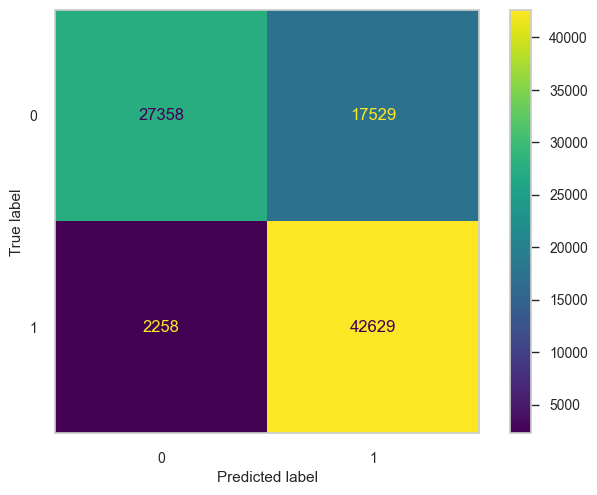

In [150]:
y_pred_test = svc_clf2.predict(X_test2)
cm = confusion_matrix(Y_test2, y_pred_test)
cmd=ConfusionMatrixDisplay(cm)
cmd.plot()
plt.grid(False)

precision0_svc2 = precision_score(Y_test2, y_pred_test,pos_label=0)
precision1_svc2 = precision_score(Y_test2, y_pred_test)
recall0_svc2 = recall_score(Y_test2,y_pred_test,pos_label=0)
recall1_svc2 = recall_score(Y_test2,y_pred_test)
f1score0_svc2 = f1_score(Y_test2,y_pred_test,pos_label=0)
f1score1_svc2 = f1_score(Y_test2,y_pred_test)

print(classification_report(Y_test2, y_pred_test))

#### Logistic Regression

In [151]:
lr_clf2 = LogisticRegression(random_state=42)
lr_clf2.fit(X_res, Y_res)

test_score_lr2 = lr_clf2.score(X_test2,Y_test2)
training_score_lr2 = lr_clf2.score(X_res,Y_res)
print("Training Score : %.3f ," %training_score_lr2, " Test Score : %.3f "  %test_score_lr2)

Training Score : 0.778 ,  Test Score : 0.781 


              precision    recall  f1-score   support

           0       0.89      0.64      0.75     44887
           1       0.72      0.92      0.81     44887

    accuracy                           0.78     89774
   macro avg       0.80      0.78      0.78     89774
weighted avg       0.80      0.78      0.78     89774



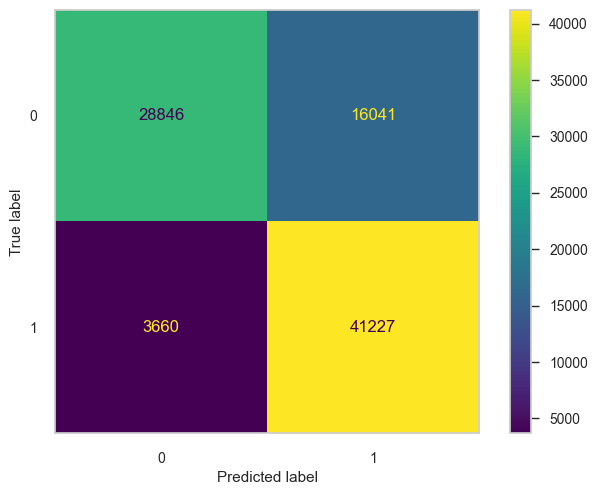

In [152]:
y_pred_test = lr_clf2.predict(X_test2)
cm = confusion_matrix(Y_test2, y_pred_test)
cmd=ConfusionMatrixDisplay(cm)
cmd.plot()
plt.grid(False)

precision0_lr2 = precision_score(Y_test2, y_pred_test,pos_label=0)
precision1_lr2 = precision_score(Y_test2, y_pred_test)
recall0_lr2 = recall_score(Y_test2,y_pred_test,pos_label=0)
recall1_lr2 = recall_score(Y_test2,y_pred_test)
f1score0_lr2 = f1_score(Y_test2,y_pred_test,pos_label=0)
f1score1_lr2 = f1_score(Y_test2,y_pred_test)

print(classification_report(Y_test2, y_pred_test))

#### Gaussian Naive Bayes

In [153]:
nb_clf2 = GaussianNB(var_smoothing = 1e-3)
nb_clf2 = nb_clf2.fit(X_res, Y_res)

test_score_nb2 = nb_clf2.score(X_test2,Y_test2)
training_score_nb2 = nb_clf2.score(X_res,Y_res)
print("Training Score : %.3f ," %training_score_nb2, " Test Score : %.3f "  %test_score_nb2)

Training Score : 0.758 ,  Test Score : 0.758 


              precision    recall  f1-score   support

           0       0.80      0.69      0.74     44887
           1       0.73      0.83      0.77     44887

    accuracy                           0.76     89774
   macro avg       0.76      0.76      0.76     89774
weighted avg       0.76      0.76      0.76     89774



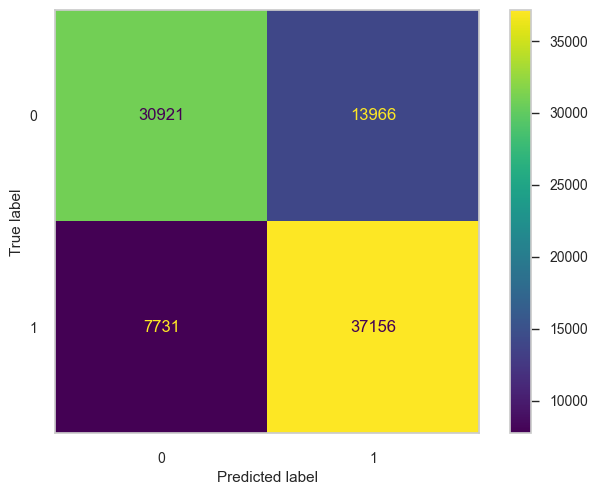

In [154]:
y_pred_test = nb_clf2.predict(X_test2)
cm = confusion_matrix(Y_test2, y_pred_test)
cmd=ConfusionMatrixDisplay(cm)
cmd.plot()
plt.grid(False)

precision0_nb2 = precision_score(Y_test2, y_pred_test,pos_label=0)
precision1_nb2 = precision_score(Y_test2, y_pred_test)
recall0_nb2 = recall_score(Y_test2,y_pred_test,pos_label=0)
recall1_nb2 = recall_score(Y_test2,y_pred_test)
f1score0_nb2 = f1_score(Y_test2,y_pred_test,pos_label=0)
f1score1_nb2 = f1_score(Y_test2,y_pred_test)

print(classification_report(Y_test2, y_pred_test))

In [155]:
#from sklearn.metrics import precision_recall_curve
#probabilities = lr_clf2.predict_proba(X_test2)
#precision, recall, thresholds = precision_recall_curve(Y_test2, probabilities[:, 1])
# Vectorized operation:
#f1_scores = 2 * recall * precision / (recall + precision)
#best_f1 = np.max(f1_scores)
#best_thresh = thresholds[np.argmax(f1_scores)]
#best_predictions = (probabilities[:, 1] > best_thresh).astype(int)
#print("miglior threshold: "+ str(best_thresh))

## Model Report - Balanced Test Set

#### Decision Tree

In [156]:
print("Accuracy training: " + str(training_score_dt2))
print("Accuracy test: " + str(test_score_dt2))
print("")
print("Precision class 0: " + str(precision0_dt2))
print("Precision class 1: " + str(precision1_dt2))
print("")
print("Recall class 0: " + str(recall0_dt2))
print("Recall class 1: " + str(recall1_dt2) + " [Important]")
print("")
print("F1 Score Class 0: " + str(f1score0_dt2))
print("F1 Score Class 1: " + str(f1score1_dt2))

Accuracy training: 0.7817173356946084
Accuracy test: 0.7799697016953684

Precision class 0: 0.8762800167674711
Precision class 1: 0.722914005959983

Recall class 0: 0.6519927818744848
Recall class 1: 0.9079466215162519 [Important]

F1 Score Class 0: 0.7476783547295139
F1 Score Class 1: 0.8049336875265399


#### Stochastic Gradient Descent

In [157]:
print("Accuracy training: " + str(training_score_sgd2))
print("Accuracy test: " + str(test_score_sgd3))
print("")
print("Precision class 0: " + str(precision0_sgd2))
print("Precision class 1: " + str(precision1_sgd2))
print("")
print("Recall class 0: " + str(recall0_sgd2))
print("Recall class 1: " + str(recall1_sgd2) + " [Important]")
print("")
print("F1 Score Class 0: " + str(f1score0_sgd2))
print("F1 Score Class 1: " + str(f1score1_sgd2))

Accuracy training: 0.7761830972058245
Accuracy test: 0.7780760576558915

Precision class 0: 0.8752405002405003
Precision class 1: 0.7208812599539904

Recall class 0: 0.6486065007685967
Recall class 1: 0.9075456145431863 [Important]

F1 Score Class 0: 0.7450704405573825
F1 Score Class 1: 0.8035148968904406


#### Linear Support Vector Classifier

In [158]:
print("Accuracy training: " + str(training_score_svc2))
print("Accuracy test: " + str(test_score_svc2))
print("")
print("Precision class 0: " + str(precision0_svc2))
print("Precision class 1: " + str(precision1_svc2))
print("")
print("Recall class 0: " + str(recall0_svc2))
print("Recall class 1: " + str(recall1_svc2) + " [Important]")
print("")
print("F1 Score Class 0: " + str(f1score0_svc2))
print("F1 Score Class 1: " + str(f1score1_svc2))

Accuracy training: 0.7770193821330185
Accuracy test: 0.779590972887473

Precision class 0: 0.9237574284170719
Precision class 1: 0.7086173077562419

Recall class 0: 0.6094860427295208
Recall class 1: 0.9496959030454252 [Important]

F1 Score Class 0: 0.734413379327007
F1 Score Class 1: 0.8116331096196868


#### Logistic Regression

In [159]:
print("Accuracy training: " + str(training_score_lr2))
print("Accuracy test: " + str(test_score_lr2))
print("")
print("Precision class 0: " + str(precision0_lr2))
print("Precision class 1: " + str(precision1_lr2))
print("")
print("Recall class 0: " + str(recall0_lr2))
print("Recall class 1: " + str(recall1_lr2) + " [Important]")
print("")
print("F1 Score Class 0: " + str(f1score0_lr2))
print("F1 Score Class 1: " + str(f1score1_lr2))

Accuracy training: 0.7775728059818969
Accuracy test: 0.7805489339897966

Precision class 0: 0.887405402079616
Precision class 1: 0.7198959279178598

Recall class 0: 0.6426359525029518
Recall class 1: 0.9184619154766414 [Important]

F1 Score Class 0: 0.7454420942462496
F1 Score Class 1: 0.807146003621947


#### Gaussian Naive Bayes

In [160]:
print("Accuracy training: " + str(training_score_nb2))
print("Accuracy test: " + str(test_score_nb2))
print("")
print("Precision class 0: " + str(precision0_nb2))
print("Precision class 1: " + str(precision1_nb2))
print("")
print("Recall class 0: " + str(recall0_nb2))
print("Recall class 1: " + str(recall1_nb2) + " [Important]")
print("")
print("F1 Score Class 0: " + str(f1score0_nb2))
print("F1 Score Class 1: " + str(f1score1_nb2))

Accuracy training: 0.7577971271153089
Accuracy test: 0.7583153251498207

Precision class 0: 0.7999844768705371
Precision class 1: 0.7268103751809397

Recall class 0: 0.6888631452313587
Recall class 1: 0.8277675050682826 [Important]

F1 Score Class 0: 0.7402769963729516
F1 Score Class 1: 0.7740107698236623


### Accuracy in comparison

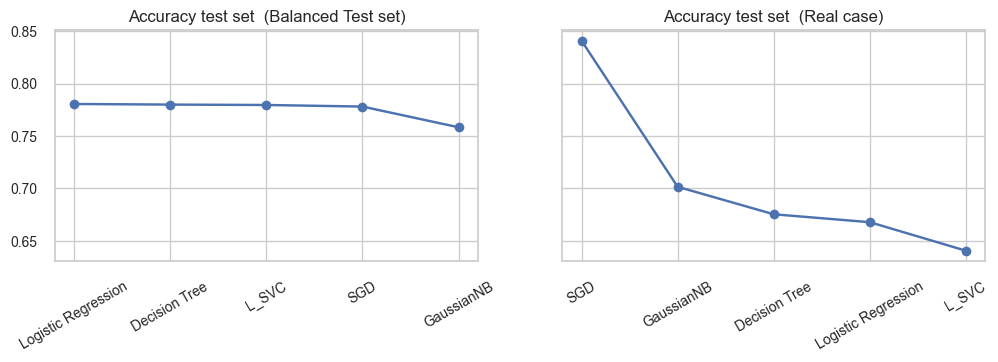

In [161]:
train_ac2 = [training_score_dt2, training_score_sgd2, training_score_svc2, training_score_lr2, training_score_nb2]
test_ac2 = [test_score_dt2, test_score_sgd3, test_score_svc2, test_score_lr2, test_score_nb2]
labels = ['Decision Tree', 'SGD', 'L_SVC','Logistic Regression','GaussianNB']

score_train2 = ordina_decrescente(labels, train_ac2)
score_test2 = ordina_decrescente(labels, test_ac2)

fig, axes = plt.subplots(1, 2, sharey = True)
fig.set_size_inches(12, 3)

#caso ideale

axes[0].plot(score_test2[1],'bo-') 
axes[0].set_xticks([i for i in range(len(labels))]) 
axes[0].set_xticklabels(score_test2[0], rotation=30, fontsize=10)

#caso reale

axes[1].plot(score_test[1],'bo-') 
axes[1].set_xticks([i for i in range(len(labels))]) 
axes[1].set_xticklabels(score_test[0], rotation=30, fontsize=10)


_=axes[0].set_title('Accuracy test set  (Balanced Test set)', fontsize=12)
_=axes[1].set_title('Accuracy test set  (Real case)', fontsize=12)



### Precision a confronto

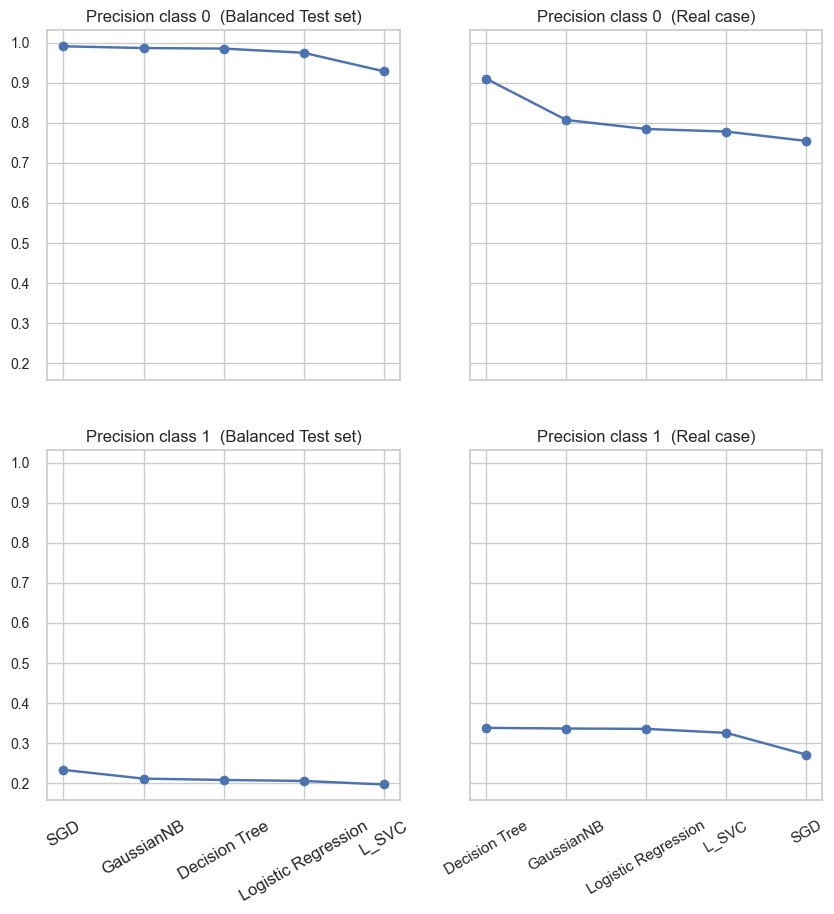

In [162]:
labels = ['Decision Tree', 'SGD', 'L_SVC','Logistic Regression','GaussianNB']
precision02 = [precision0_dt2, precision0_sgd2, precision0_svc2, precision0_lr2, precision0_nb2]
precision12 = [precision1_dt2, precision1_sgd2, precision1_svc2, precision1_lr2, precision1_nb2]

score_02 = ordina_decrescente(labels, precision0)
score_12 = ordina_decrescente(labels, precision1)

fig, axes = plt.subplots(2, 2, sharey = True)
fig.set_size_inches(10, 10)

#caso ideale

axes[0][0].plot(score_02[1],'bo-')
axes[1][0].plot(score_12[1],'bo-')
axes[0][0].set_xticks([i for i in range(len(labels))])
axes[1][0].set_xticks([i for i in range(len(labels))])
axes[0][0].set_xticklabels([], rotation=30, fontsize=12)
axes[1][0].set_xticklabels(score_12[0], rotation=30, fontsize=12)

#caso reale

axes[0][1].plot(score_0[1],'bo-')
axes[1][1].plot(score_1[1],'bo-')
axes[0][1].set_xticks([i for i in range(len(labels))])
axes[1][1].set_xticks([i for i in range(len(labels))])
axes[0][1].set_xticklabels([], rotation=30, fontsize=11)
axes[1][1].set_xticklabels(score_1[0], rotation=30, fontsize=11)

_=axes[0][0].set_title('Precision class 0  (Balanced Test set)')
_=axes[1][0].set_title('Precision class 1  (Balanced Test set)')
_=axes[0][1].set_title('Precision class 0  (Real case)')
_=axes[1][1].set_title('Precision class 1  (Real case)')

### Recall a confronto

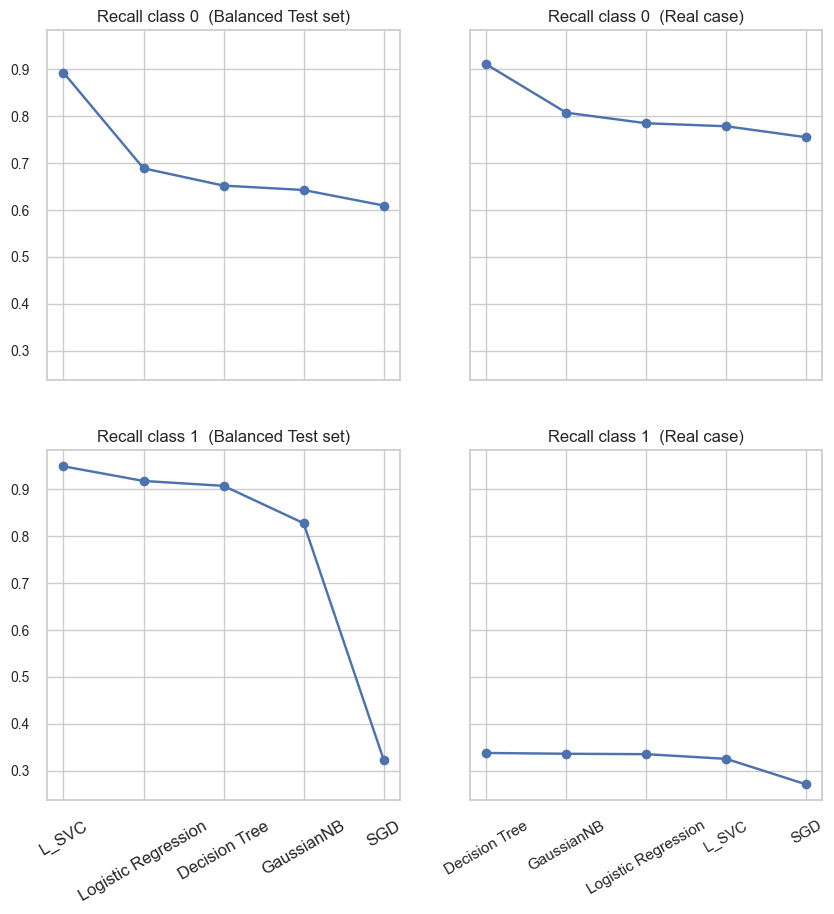

In [163]:
labels = ['Decision Tree', 'SGD', 'L_SVC','Logistic Regression','GaussianNB']
recall02 = [recall0_dt2, recall0_sgd2, recall0_svc2, recall0_lr2, recall0_nb2]
recall12 = [recall1_dt2, recall1_sgd2, recall1_svc2, recall1_lr2, recall1_nb2]

score_02 = ordina_decrescente(labels, recall0)
score_12 = ordina_decrescente(labels, recall1)

fig, axes = plt.subplots(2, 2, sharey = True)
fig.set_size_inches(10, 10)

#caso ideale

axes[0][0].plot(score_02[1],'bo-')
axes[1][0].plot(score_12[1],'bo-')
axes[0][0].set_xticks([i for i in range(len(labels))])
axes[1][0].set_xticks([i for i in range(len(labels))])
axes[0][0].set_xticklabels([], rotation=30, fontsize=12)
axes[1][0].set_xticklabels(score_12[0], rotation=30, fontsize=12)

#caso reale

axes[0][1].plot(score_0[1],'bo-')
axes[1][1].plot(score_1[1],'bo-')
axes[0][1].set_xticks([i for i in range(len(labels))])
axes[1][1].set_xticks([i for i in range(len(labels))])
axes[0][1].set_xticklabels([], rotation=30, fontsize=11)
axes[1][1].set_xticklabels(score_1[0], rotation=30, fontsize=11)

_=axes[0][0].set_title('Recall class 0  (Balanced Test set)')
_=axes[1][0].set_title('Recall class 1  (Balanced Test set)')
_=axes[0][1].set_title('Recall class 0  (Real case)')
_=axes[1][1].set_title('Recall class 1  (Real case)')

### F1 Score a confronto

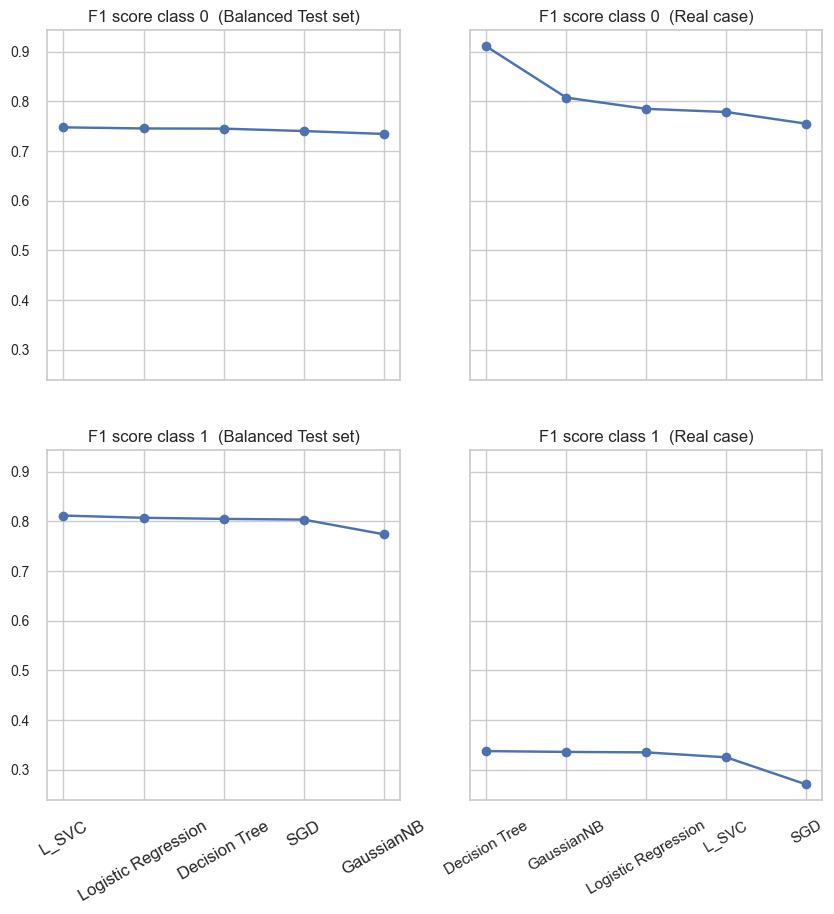

In [164]:
labels = ['Decision Tree', 'SGD', 'L_SVC','Logistic Regression','GaussianNB']
f1score02 = [f1score0_dt2, f1score0_sgd2, f1score0_svc2, f1score0_lr2, f1score0_nb2]
f1score12 = [f1score1_dt2, f1score1_sgd2, f1score1_svc2, f1score1_lr2, f1score1_nb2]

score_02 = ordina_decrescente(labels, f1score02)
score_12 = ordina_decrescente(labels, f1score12)

fig, axes = plt.subplots(2, 2, sharey = True)
fig.set_size_inches(10, 10)

#caso ideale

axes[0][0].plot(score_02[1],'bo-')
axes[1][0].plot(score_12[1],'bo-')
axes[0][0].set_xticks([i for i in range(len(labels))])
axes[1][0].set_xticks([i for i in range(len(labels))])
axes[0][0].set_xticklabels([], rotation=30, fontsize=12)
axes[1][0].set_xticklabels(score_12[0], rotation=30, fontsize=12)

#caso reale

axes[0][1].plot(score_0[1],'bo-')
axes[1][1].plot(score_1[1],'bo-')
axes[0][1].set_xticks([i for i in range(len(labels))])
axes[1][1].set_xticks([i for i in range(len(labels))])
axes[0][1].set_xticklabels([], rotation=30, fontsize=11)
axes[1][1].set_xticklabels(score_1[0], rotation=30, fontsize=11)

_=axes[0][0].set_title('F1 score class 0  (Balanced Test set)')
_=axes[1][0].set_title('F1 score class 1  (Balanced Test set)')
_=axes[0][1].set_title('F1 score class 0  (Real case)')
_=axes[1][1].set_title('F1 score class 1  (Real case)')

significantly higher performance!

### ROC Curve

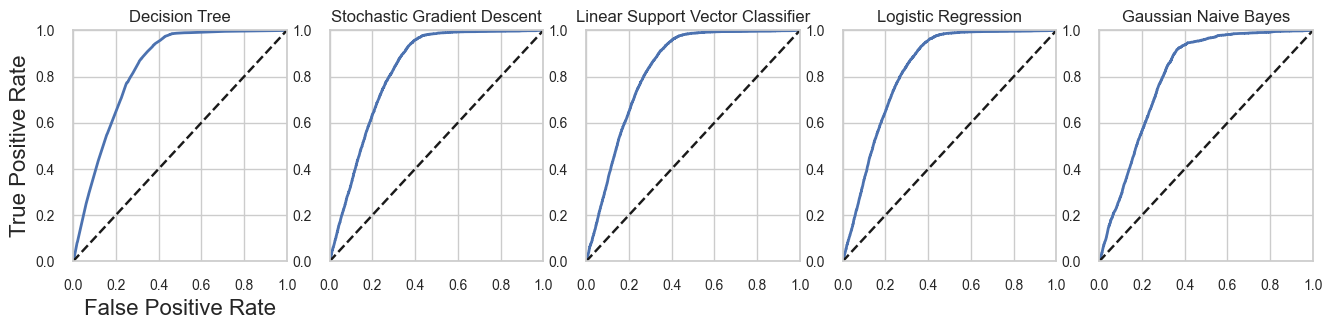

In [165]:
fig, axes = plt.subplots(1, 5)
fig.set_size_inches(16, 3)
_=axes[0].set_title('Decision Tree')
_=axes[1].set_title('Stochastic Gradient Descent')
_=axes[2].set_title('Linear Support Vector Classifier')
_=axes[3].set_title('Logistic Regression')
_=axes[4].set_title('Gaussian Naive Bayes')

#Y_res_1 = (Y_res == 1) 
## Decision tree
y_scores_dt = DTree_clf2.predict_proba(X_test2)[:, 1]
fpr_dt2, tpr_dt2, thresholds_dt2 = roc_curve(Y_test2, y_scores_dt)

plot_roc_curve(fpr_dt2, tpr_dt2, axes, 0)

## SGD
#y_scores_sgd = cross_val_predict(sgd_clf2, X_test2, Y_test2.iloc[:, 0], cv = 3, method="decision_function")
#fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(Y_test2, y_scores_sgd)

y_scores_sgd = sgd_clf2.predict_proba(X_test2)[:, 1]
fpr_sgd2, tpr_sgd2, thresholds_sgd2 = roc_curve(Y_test2, y_scores_sgd)

plot_roc_curve(fpr_sgd2, tpr_sgd2, axes, 1)

##LSVC
#y_scores_svc = cross_val_predict(svc_clf2, X_test2, Y_test2.iloc[:, 0], cv = 3, method="decision_function")
#fpr_svc, tpr_svc, thresholds_svc = roc_curve(Y_test2, y_scores_svc)

y_scores_svc = svc_clf2._predict_proba_lr(X_test2)[:, 1]
fpr_svc2, tpr_svc2, thresholds_svc2 = roc_curve(Y_test2, y_scores_svc)

plot_roc_curve(fpr_svc2, tpr_svc2, axes, 2)

##Logistic regression
#y_scores_lr = cross_val_predict(lr_clf2, X_test2, Y_test2.iloc[:, 0], cv = 3, method="decision_function")
#fpr_lr, tpr_lr, thresholds = roc_curve(Y_test2, y_scores_lr)

y_scores_lr = lr_clf2.predict_proba(X_test2)[:, 1]
fpr_lr2, tpr_lr2, thresholds_lr2 = roc_curve(Y_test2, y_scores_lr)

plot_roc_curve(fpr_lr2, tpr_lr2, axes, 3)

##GaussianNB
y_scores_nb = nb_clf2.predict_proba(X_test2)[:, 1]
fpr_nb2, tpr_nb2, thresholds_nb2 = roc_curve(Y_test2, y_scores_nb)

plot_roc_curve(fpr_nb2, tpr_nb2, axes, 4)

In [166]:
auc_score_dt2 = roc_auc_score(Y_test2, y_scores_dt)
print("AUC score Decision Tree: " + str(auc_score_dt2))
print()
auc_score_sgd2 = roc_auc_score(Y_test2, y_scores_sgd)
print("AUC score Stochastic Gradient Descent: " + str(auc_score_sgd2))
print()
auc_score_svc2 = roc_auc_score(Y_test2, y_scores_svc)
print("AUC score LinearSVC: " + str(auc_score_svc2))
print()
auc_score_lr2 = roc_auc_score(Y_test2, y_scores_lr)
print("AUC score Logistic Regression: " + str(auc_score_lr2))
print()
auc_score_nb2 = roc_auc_score(Y_test2, y_scores_nb)
print("AUC score GaussianNB: " + str(auc_score_nb2))

AUC score Decision Tree: 0.8337495271820885

AUC score Stochastic Gradient Descent: 0.8262647168375647

AUC score LinearSVC: 0.8302712294668387

AUC score Logistic Regression: 0.8308395705888452

AUC score GaussianNB: 0.8048318158864733


As far as the AUC score is concerned, there is no substantial improvement compared to when the test set was unbalanced

## 6) Post processing

### Grid Search application for finding the best model and parameters

On models that are promising, I perform grid searches in order to obtain the best parameters

#### SGD Classifier [GridSearch]

Training Score : 0.776 ,  Test Score : 0.673 
              precision    recall  f1-score   support

           0       0.99      0.65      0.78     44887
           1       0.21      0.91      0.34      4510

    accuracy                           0.67     49397
   macro avg       0.60      0.78      0.56     49397
weighted avg       0.91      0.67      0.74     49397



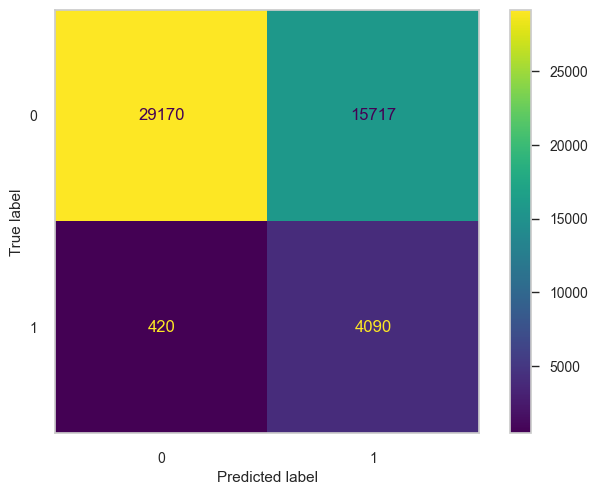

In [167]:

parameters = {
    'loss': ['hinge', 'log'],
    'penalty': ['l2', 'l1', 'elasticnet'], #l1 lasso l2 ridge
    'alpha': [0.001, 0.01],
    'max_iter': [5,10,50],
}

sgd = SGDClassifier(random_state = 42)
sgd_gs = GridSearchCV(sgd, parameters, scoring = "accuracy", cv=5) 


sgd_gs.fit(X_res, Y_res)  

best_params = sgd_gs.best_params_
best_model = sgd_gs.best_estimator_

accuracy = best_model.score(X_test, Y_test)

test_score_sgd2 = sgd_gs.score(X_test,Y_test)
training_score_sgd2 = sgd_gs.score(X_res,Y_res)
print("Training Score : %.3f ," %training_score_sgd2, " Test Score : %.3f "  %test_score_sgd2)

y_pred_test = sgd_gs.predict(X_test)
cm = confusion_matrix(Y_test, y_pred_test)
cmd=ConfusionMatrixDisplay(cm)
cmd.plot()
plt.grid(False)

precision0_sgdgs = precision_score(Y_test, y_pred_test,pos_label=0)
precision1_sgdgs = precision_score(Y_test, y_pred_test)
recall0_sgdgs = recall_score(Y_test,y_pred_test,pos_label=0)
recall1_sgdgs = recall_score(Y_test,y_pred_test)
f1score0_sgdgs = f1_score(Y_test,y_pred_test,pos_label=0)
f1score1_sgdgs = f1_score(Y_test,y_pred_test)

print(classification_report(Y_test, y_pred_test))

In [168]:
y_scores_sgdgs = sgd_gs.predict_proba(X_test)[:, 1]
rocaucscoregs_sgd = roc_auc_score(Y_test, y_scores_sgdgs)
print("AUC score Stochastic Gradient Descent: " + str(rocaucscoregs_sgd))

AUC score Stochastic Gradient Descent: 0.8298328416412202


In [169]:
print(best_params) # log, l2, 0.001, 100

{'alpha': 0.001, 'loss': 'log', 'max_iter': 10, 'penalty': 'elasticnet'}


We achieved very satisfactory results!

<BarContainer object of 2 artists>

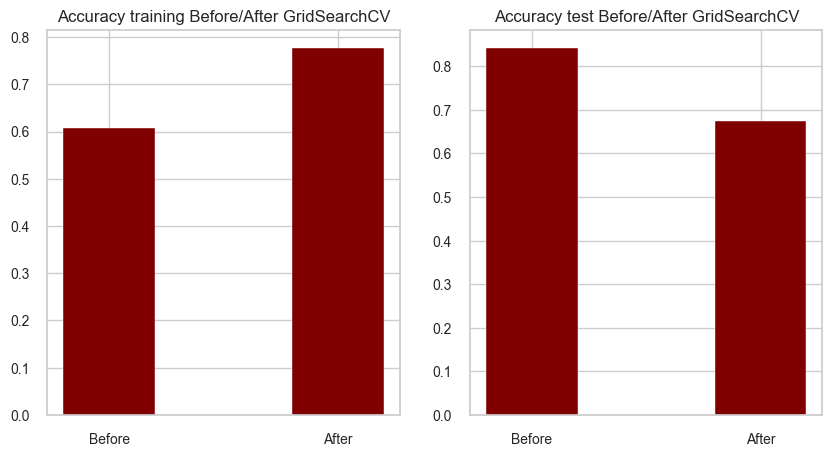

In [170]:
fig, ax =plt.subplots(1,2,figsize = (10,5))
ax[0].set_title('Accuracy training Before/After GridSearchCV')
ax[1].set_title('Accuracy test Before/After GridSearchCV')
labels = ["Before", "After"]
values_train = [training_score_sgd, training_score_sgd2]
values_test = [test_score_sgd, test_score_sgd2]
ax[0].bar(labels, values_train, color ='maroon', width = 0.4)
ax[1].bar(labels, values_test, color ='maroon', width = 0.4)

It may be misleading that the accuracy of the test has gone down as we previously had a lower training accuracy than the test accuracy and that is what one would not want to have. This may have been solved by the fact that GridSearchCV performs cross-validation.

<BarContainer object of 2 artists>

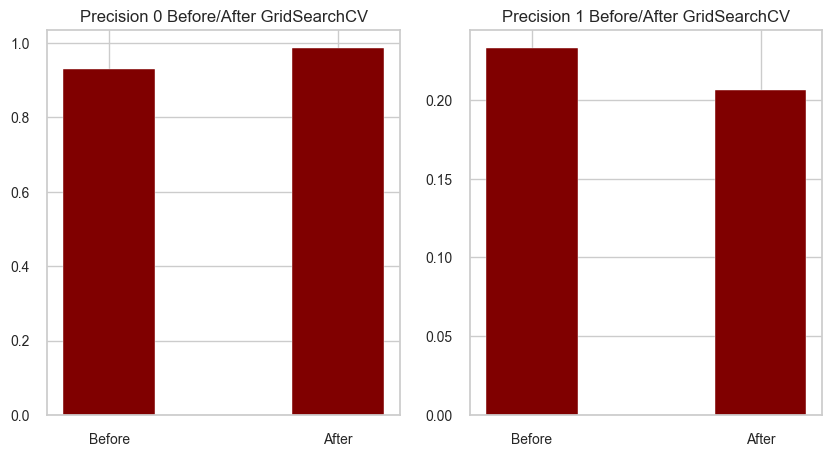

In [171]:
fig, ax =plt.subplots(1,2,figsize = (10,5))
ax[0].set_title('Precision 0 Before/After GridSearchCV')
ax[1].set_title('Precision 1 Before/After GridSearchCV')
labels = ["Before", "After"]
values_train = [precision0_sgd, precision0_sgdgs]
values_test = [precision1_sgd, precision1_sgdgs]
ax[0].bar(labels, values_train, color ='maroon', width = 0.4)
ax[1].bar(labels, values_test, color ='maroon', width = 0.4)

<BarContainer object of 2 artists>

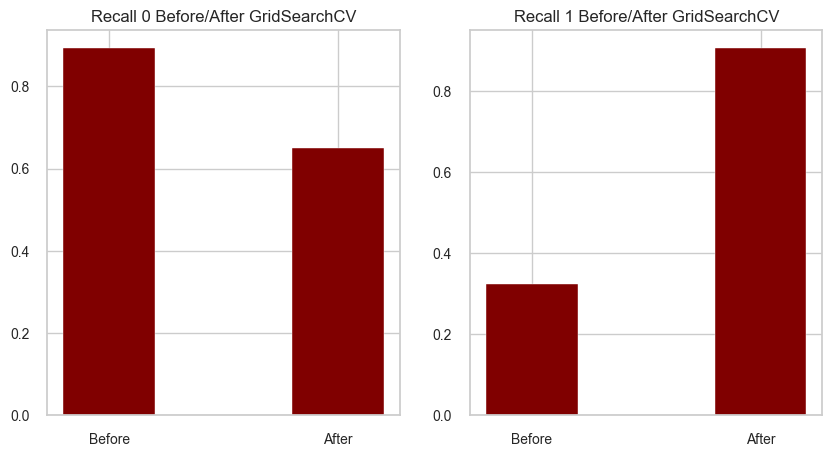

In [172]:
fig, ax =plt.subplots(1,2,figsize = (10,5))
ax[0].set_title('Recall 0 Before/After GridSearchCV')
ax[1].set_title('Recall 1 Before/After GridSearchCV')
labels = ["Before", "After"]
values_train = [recall0_sgd, recall0_sgdgs]
values_test = [recall1_sgd, recall1_sgdgs]
ax[0].bar(labels, values_train, color ='maroon', width = 0.4)
ax[1].bar(labels, values_test, color ='maroon', width = 0.4)

Here the results are very promising, it is true that we have a slight decrease in recall on class 0, but the task under study needs to have a good recall on class 1, which has had a considerable increase!

<BarContainer object of 2 artists>

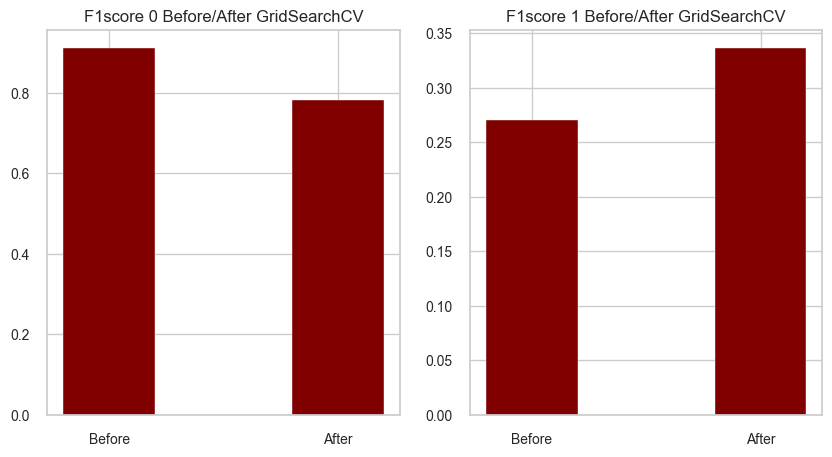

In [173]:
fig, ax =plt.subplots(1,2,figsize = (10,5))
ax[0].set_title('F1score 0 Before/After GridSearchCV')
ax[1].set_title('F1score 1 Before/After GridSearchCV')
labels = ["Before", "After"]
values_train = [f1score0_sgd, f1score0_sgdgs]
values_test = [f1score1_sgd, f1score1_sgdgs]
ax[0].bar(labels, values_train, color ='maroon', width = 0.4)
ax[1].bar(labels, values_test, color ='maroon', width = 0.4)

<BarContainer object of 2 artists>

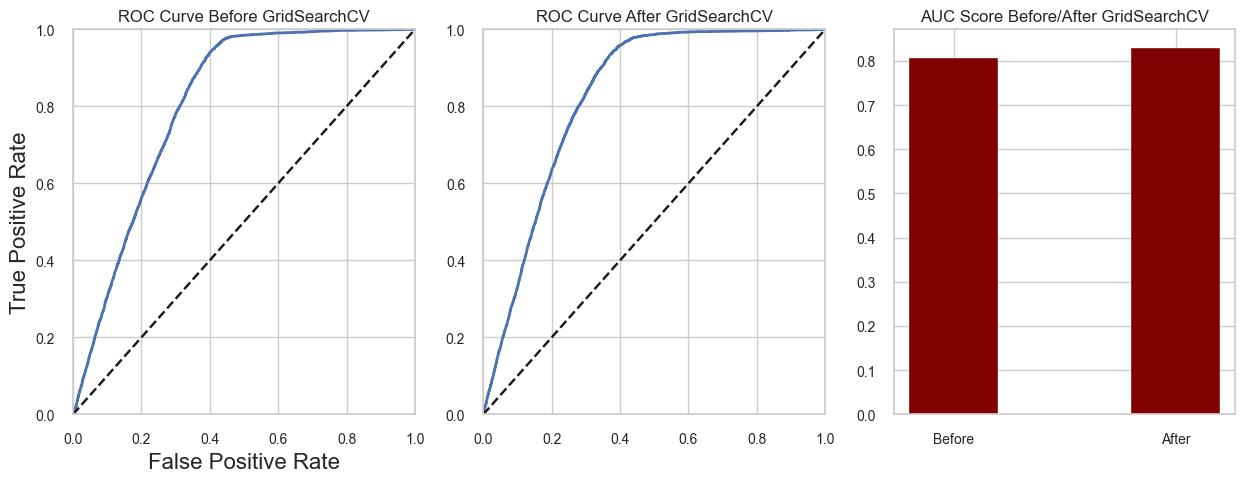

In [174]:
fig, ax =plt.subplots(1,3,figsize = (15,5))
ax[0].set_title('ROC Curve Before GridSearchCV')
ax[1].set_title('ROC Curve After GridSearchCV')
ax[2].set_title('AUC Score Before/After GridSearchCV')
labels = ["Before", "After"]
values_auc = [rocaucscore_sgd, rocaucscoregs_sgd]

y_scores_sgd2 = sgd_gs.predict_proba(X_test)[:, 1]
fpr_sgd3, tpr_sgd3, thresholds_sgd3 = roc_curve(Y_test, y_scores_sgd2)

plot_roc_curve(fpr_sgd, tpr_sgd, ax, 0)
plot_roc_curve(fpr_sgd2, tpr_sgd2, ax, 1)

ax[2].bar(labels, values_auc, color ='maroon', width = 0.4)

We also have an increase in the AUC score!

#### Linear SVC [GridSearch]

In [175]:

#parameters = {
#    'C': [0.1, 1.0, 10.0, 100.0],
#    'penalty': ['l1', 'l2'],
#}

#svc = LinearSVC(random_state=42)
#svc_gs = GridSearchCV(svc, parameters, scoring = "accuracy", cv=5) 


#svc_gs.fit(X_res, Y_res)  

#best_params = svc_gs.best_params_
#best_model = svc_gs.best_estimator_

#accuracy = best_model.score(X_test, Y_test)

#test_score_svc2 = svc_gs.score(X_test,Y_test)
#training_score_svc2 = svc_gs.score(X_res,Y_res)
#print("Training Score : %.3f ," %training_score_svc2, " Test Score : %.3f "  %test_score_svc2)

#y_pred_test = svc_gs.predict(X_test)
#cm = confusion_matrix(Y_test, y_pred_test)
#cmd=ConfusionMatrixDisplay(cm)
#cmd.plot()
#plt.grid(False)

#precision0_svcgs = precision_score(Y_test, y_pred_test,pos_label=0)
#precision1_svcgs = precision_score(Y_test, y_pred_test)
#recall0_svcgs = recall_score(Y_test,y_pred_test,pos_label=0)
#recall1_svcgs = recall_score(Y_test,y_pred_test)
#f1score0_svcgs = f1_score(Y_test,y_pred_test,pos_label=0)
#f1score1_svcgs = f1_score(Y_test,y_pred_test)

#print(classification_report(Y_test, y_pred_test))

In [176]:
#print(best_params) #C = 0.1 penality = l2

No significant improvement

#### Logistic Regression [GridSearch]

In [177]:
#parameters = {
#    'C': [0.1, 1.0, 10.0],
#    'penalty': ['l1', 'l2'],
#    'solver': ['liblinear'],
#}

#lr = LogisticRegression(random_state=42)
#lr_gs = GridSearchCV(lr, parameters, scoring = "accuracy", cv=5) 

#lr_gs.fit(X_res, Y_res)  

#best_params = lr_gs.best_params_
#best_model = lr_gs.best_estimator_

#accuracy = best_model.score(X_test, Y_test)

#test_score_lr2 = lr_gs.score(X_test,Y_test)
#training_score_lr2 = lr_gs.score(X_res,Y_res)
#print("Training Score : %.3f ," %training_score_lr2, " Test Score : %.3f "  %test_score_lr2)

#y_pred_test = lr_gs.predict(X_test)
#cm = confusion_matrix(Y_test, y_pred_test)
#cmd=ConfusionMatrixDisplay(cm)
#cmd.plot()
#plt.grid(False)

#precision0_lrgs = precision_score(Y_test, y_pred_test,pos_label=0)
#precision1_lrgs = precision_score(Y_test, y_pred_test)
#recall0_lrgs = recall_score(Y_test,y_pred_test,pos_label=0)
#recall1_lrgs = recall_score(Y_test,y_pred_test)
#f1score0_lrgs = f1_score(Y_test,y_pred_test,pos_label=0)
#f1score1_lrgs = f1_score(Y_test,y_pred_test)

#print(classification_report(Y_test, y_pred_test))

In [178]:
#y_scores_lrgs = lr_gs.predict_proba(X_test)[:, 1]
#print("AUC score Logistic Regression: " + str(roc_auc_score(Y_test, y_scores_lrgs)))

In [179]:
#print(best_params) # C = 0.1 penalty = l1 solver = libnear

No significant improvement

## Ensemble Learning (Real case)

Ensemble learning is a technique based on the use of several models in order to achieve higher performance than classifiers (in our case) used individually.

Having trained the classifiers seen so far, one way to aggregate them is to use a voting system.
There are two possible approaches

1. Hard Voting: one calculates the argmax of the votes, only in this case one would also take the classification made on a classifier with low accuracy and then weigh it in the same way as a classifier with higher accuracy.

2. Soft Voting: A weighted argmax is calculated (weights each classification against the classifier's confidence).

An important requirement for this approach is independence. We therefore simulate independence by selecting very different classifiers for the voting system.

### Random Forest

In [180]:
# Random forest.
rf = RandomForestClassifier(n_jobs=-1, random_state=42, max_depth=11, min_samples_split = 200, n_estimators = 500)

rf.fit(X_res, Y_res)

y_pred_test = rf.predict(X_test)

test_score_rf = rf.score(X_test,Y_test)
training_score_rf = rf.score(X_res,Y_res)
print("Training Score : %.3f ," %training_score_rf, " Test Score : %.3f "  %test_score_rf)

Training Score : 0.774 ,  Test Score : 0.683 


In [181]:
cm = confusion_matrix(Y_test, y_pred_test)
print(cm)

[[29698 15189]
 [  487  4023]]


precision: 0.2094003747657714
recall: 0.8920177383592017
f1_score: 0.33917882134727256


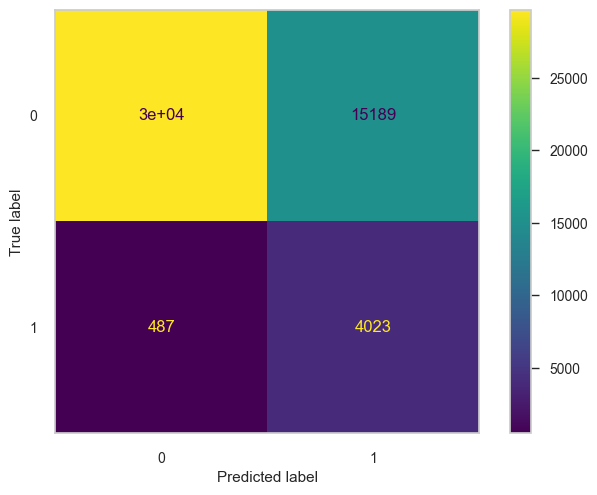

In [182]:
cmd=ConfusionMatrixDisplay(cm)
cmd.plot()
plt.grid(False)

precision_rf = precision_score(Y_test, y_pred_test)
recall_rf = recall_score(Y_test,y_pred_test)
f1score_rf = f1_score(Y_test,y_pred_test)

print("precision: " + str(precision_rf))
print("recall: " + str(recall_rf))
print("f1_score: " + str(f1score_rf))

In [183]:
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.66      0.79     44887
           1       0.21      0.89      0.34      4510

    accuracy                           0.68     49397
   macro avg       0.60      0.78      0.57     49397
weighted avg       0.91      0.68      0.75     49397



In [184]:
y_scores_rf = rf.predict_proba(X_test)[:, 1]
auc_score_rf = roc_auc_score(Y_test, y_scores_rf)
print("AUC score Random Forest: " + str(auc_score_rf))

AUC score Random Forest: 0.8296084323497335


In [185]:
#parameters = {
#    'n_estimators': [100, 200, 500],
#    'max_depth': [None, 5, 10],
#    'min_samples_split': [2, 5, 10],
#}


#rf = RandomForestClassifier(random_state = 42)
#rf_gs = GridSearchCV(rf, parameters, scoring = "accuracy", cv=5) 


#rf_gs.fit(X_res, Y_res)  

#best_params = rf_gs.best_params_
#best_model = rf_gs.best_estimator_

#accuracy = best_model.score(X_test, Y_test)

#test_score_rf2 = rf_gs.score(X_test,Y_test)
#training_score_rf2 = rf_gs.score(X_res,Y_res)
#print("Training Score : %.3f ," %training_score_rf2, " Test Score : %.3f "  %test_score_rf2)

#acctrain 0.775 acctest 0.678

#y_pred_test = rf_gs.predict(X_test)
#cm = confusion_matrix(Y_test, y_pred_test)
#cmd=ConfusionMatrixDisplay(cm)
#cmd.plot()
#plt.grid(False)

#precision0_rfgs = precision_score(Y_test, y_pred_test,pos_label=0)
#precision1_rfgs = precision_score(Y_test, y_pred_test)
#recall0_rfgs = recall_score(Y_test,y_pred_test,pos_label=0)
#recall1_rfgs = recall_score(Y_test,y_pred_test)
#f1score0_rfgs = f1_score(Y_test,y_pred_test,pos_label=0)
#f1score1_rfgs = f1_score(Y_test,y_pred_test)

#print(classification_report(Y_test, y_pred_test))

In [186]:
#print(best_params) # max_depth 10, minss 2, n_est = 500
#y_scores_rf2 = rf_gs.predict_proba(X_test)[:, 1]
#print("AUC score Random Forest: " + str(roc_auc_score(Y_test, y_scores_rf2))) #0.8281

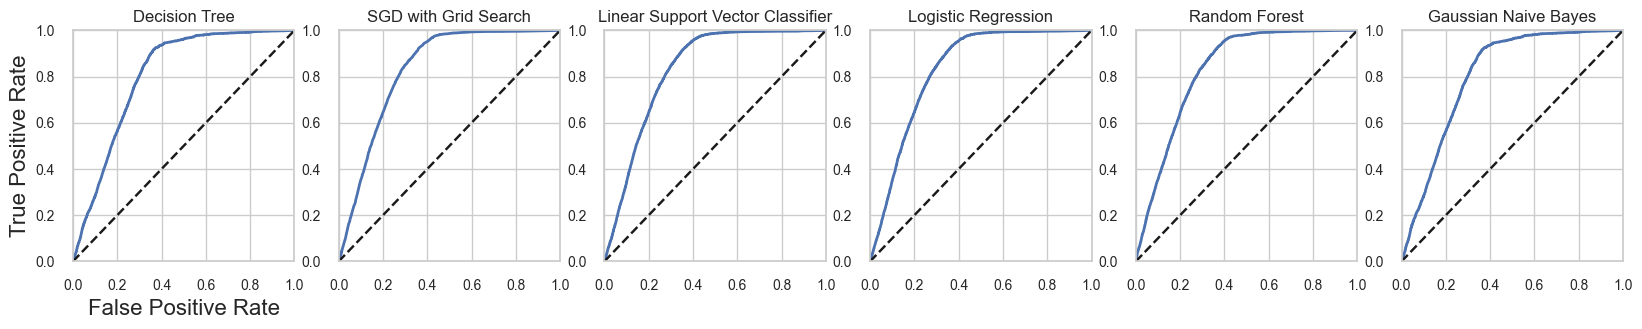

In [187]:
fig, axes = plt.subplots(1, 6)
fig.set_size_inches(20, 3)
_=axes[0].set_title('Decision Tree')
_=axes[1].set_title('SGD with Grid Search')
_=axes[2].set_title('Linear Support Vector Classifier')
_=axes[3].set_title('Logistic Regression')
_=axes[4].set_title('Random Forest')
_=axes[5].set_title('Gaussian Naive Bayes')


y_scores_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_dt = roc_curve(Y_test, y_scores_rf)

plot_roc_curve(fpr_nb, tpr_nb, axes, 0)
plot_roc_curve(fpr_sgd3, tpr_sgd3, axes, 1)
plot_roc_curve(fpr_svc, tpr_svc, axes, 2)
plot_roc_curve(fpr_lr, tpr_lr, axes, 3)
plot_roc_curve(fpr_rf, tpr_rf, axes, 4)
plot_roc_curve(fpr_nb, tpr_nb, axes, 5)

#axes.plot(fpr_rf, tpr_rf, linewidth=2)
#axes.plot([0, 1], [0, 1], 'k--')
#axes.axis([0, 1, 0, 1])
#axes.set_xlabel('False Positive Rate', fontsize=16)
#axes.set_ylabel('True Positive Rate', fontsize=16)


### Random Forest (balanced test set)

For exercise, I also train the Random Forest model with the balanced test set

In [188]:
# Random forest.
rf2 = RandomForestClassifier(n_jobs=-1, random_state=0, max_depth=10, min_samples_split = 2, n_estimators = 500)

rf2.fit(X_res, Y_res)

y_pred_test = rf2.predict(X_test2)

test_score_rf2 = rf2.score(X_test2,Y_test2)
training_score = rf2.score(X_res,Y_res)
print("Training Score : %.3f ," %training_score, " Test Score : %.3f "  %test_score_rf2)

Training Score : 0.775 ,  Test Score : 0.777 


In [189]:
# View confusion matrix for test data and predictions
cm = confusion_matrix(Y_test2, y_pred_test)
print(cm)

[[29693 15194]
 [ 4826 40061]]


precision: 0.7250203601484029
recall: 0.8924855748880522
f1_score: 0.8000838808891375


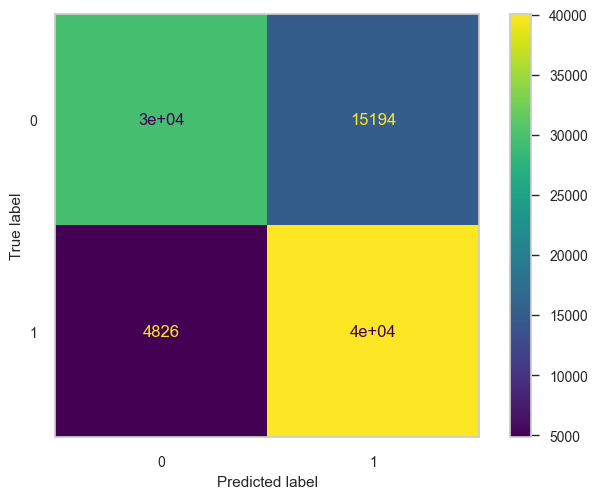

In [190]:
cmd=ConfusionMatrixDisplay(cm)
cmd.plot()
plt.grid(False)

precision2 = precision_score(Y_test2, y_pred_test)
recall2 = recall_score(Y_test2,y_pred_test)
f1score2 = f1_score(Y_test2,y_pred_test)

print("precision: " + str(precision2))
print("recall: " + str(recall2))
print("f1_score: " + str(f1score2))

In [191]:
print(classification_report(Y_test2, y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.66      0.75     44887
           1       0.73      0.89      0.80     44887

    accuracy                           0.78     89774
   macro avg       0.79      0.78      0.77     89774
weighted avg       0.79      0.78      0.77     89774



In [192]:
y_scores_rf2 = rf2.predict_proba(X_test2)[:, 1]
auc_score_rf2 = roc_auc_score(Y_test2, y_scores_rf2)
print("AUC score Random Forest: " + str(auc_score_rf2))

AUC score Random Forest: 0.8287020576442807


### Voting Classifier

In [193]:
voting_clf = VotingClassifier(estimators=[('rf', rf),('sgd',sgd_gs), ('linearsvc',svc_clf)], 
                              voting = 'hard')

voting_clf.fit(X_res,Y_res)

test_score_hard = voting_clf.score(X_test,Y_test)
training_score_hard = voting_clf.score(X_res,Y_res)
print("Training Score : %.3f ," %training_score_hard, " Test Score : %.3f "  %test_score_hard)

y_pred_test = voting_clf.predict(X_test)

precision_hard = precision_score(Y_test, y_pred_test)
recall_hard = recall_score(Y_test,y_pred_test)
f1score_hard = f1_score(Y_test,y_pred_test)

print("precision: " + str(precision_hard))
print("recall: " + str(recall_hard))
print("f1_score: " + str(f1score_hard))

print(classification_report(Y_test, y_pred_test))

Training Score : 0.777 ,  Test Score : 0.674 
precision: 0.20722269991401548
recall: 0.9084257206208426
f1_score: 0.3374655080103785
              precision    recall  f1-score   support

           0       0.99      0.65      0.78     44887
           1       0.21      0.91      0.34      4510

    accuracy                           0.67     49397
   macro avg       0.60      0.78      0.56     49397
weighted avg       0.91      0.67      0.74     49397



In [194]:
auc_score_hard = roc_auc_score(Y_test, y_pred_test)
print("AUC score Voting Classifier (Hard): " + str(auc_score_hard))

AUC score Voting Classifier (Hard): 0.7796188798706503


In [195]:
voting_clf2 = VotingClassifier(estimators=[('lr', lr_clf),('nb',nb_clf),('dt',DTree_clf)], 
                               voting = 'soft')

voting_clf2.fit(X_res,Y_res)

test_score_soft = voting_clf2.score(X_test,Y_test)
training_score_soft = voting_clf2.score(X_res,Y_res)
print("Training Score : %.3f ," %training_score_soft, " Test Score : %.3f "  %test_score_soft)

y_pred_test = voting_clf2.predict(X_test)

precision_soft = precision_score(Y_test, y_pred_test)
recall_soft = recall_score(Y_test,y_pred_test)
f1score_soft = f1_score(Y_test,y_pred_test)

print("precision: " + str(precision_soft))
print("recall: " + str(recall_soft))
print("f1_score: " + str(f1score_soft))

print(classification_report(Y_test, y_pred_test))

Training Score : 0.771 ,  Test Score : 0.695 
precision: 0.21277408094251118
recall: 0.8649667405764967
f1_score: 0.34153388198213974
              precision    recall  f1-score   support

           0       0.98      0.68      0.80     44887
           1       0.21      0.86      0.34      4510

    accuracy                           0.70     49397
   macro avg       0.60      0.77      0.57     49397
weighted avg       0.91      0.70      0.76     49397



In [196]:
auc_score_soft = roc_auc_score(Y_test, y_pred_test)
print("AUC score Voting Classifier (Soft): " + str(auc_score_soft))

AUC score Voting Classifier (Soft): 0.7717129913366589


### Boosting

Boosting is another ensamble method that works iteratively and incrementally. With each iteration, a weak learner is trained and tries to correct the mistakes made by the previous learner.

In [197]:
#from sklearn.ensemble import AdaBoostClassifier

#ada_clf = AdaBoostClassifier(rf, n_estimators=50, learning_rate=0.5, random_state = 42)
#ada_clf.fit(X_res,Y_res)

#test_score = ada_clf.score(X_test,Y_test)
#training_score = ada_clf.score(X_res,Y_res)
#print("Training Score : %.3f ," %training_score, " Test Score : %.3f "  %test_score)

#y_pred_test = ada_clf.predict(X_test)

#precision = precision_score(Y_test, y_pred_test)
#recall = recall_score(Y_test,y_pred_test)
#f1score = f1_score(Y_test,y_pred_test)

#print("precision: " + str(precision))
#print("recall: " + str(recall))
#print("f1_score: " + str(f1score))

#print(classification_report(Y_test, y_pred_test))

In [198]:
gb_clf = GradientBoostingClassifier(n_estimators=15, max_depth=40, random_state=0, min_samples_split=500)
y_pred = gb_clf.fit(X_res, Y_res).predict(X_test)
test_score_gb = gb_clf.score(X_test,Y_test)
training_score_gb = gb_clf.score(X_res,Y_res)
print("Training Score : %.3f ," %training_score_gb, " Test Score : %.3f "  %test_score_gb)

precision_gb = precision_score(Y_test, y_pred)
recall_gb = recall_score(Y_test,y_pred)
f1score_gb = f1_score(Y_test,y_pred)

print("precision: " + str(precision_gb))
print("recall: " + str(recall_gb))
print("f1_score: " + str(f1score_gb))

print(classification_report(Y_test, y_pred))

Training Score : 0.797 ,  Test Score : 0.675 
precision: 0.20782247441483434
recall: 0.9095343680709534
f1_score: 0.33833718244803695
              precision    recall  f1-score   support

           0       0.99      0.65      0.78     44887
           1       0.21      0.91      0.34      4510

    accuracy                           0.68     49397
   macro avg       0.60      0.78      0.56     49397
weighted avg       0.92      0.68      0.74     49397



In [199]:
y_scores_gb = gb_clf.predict_proba(X_test)[:, 1]
auc_score_gb = roc_auc_score(Y_test, y_scores_gb)
print("AUC score Gradient Boosting: " + str(auc_score_gb))

AUC score Gradient Boosting: 0.8336001806359077


In [200]:
# Calculating the ratio between the number of negative and positive samples
neg_samples = len(Y_res) - Y_res.sum().values[0]
pos_samples = Y_res.sum().values[0]
scale_pos_weight = neg_samples / pos_samples

xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight,random_state=42, max_depth=10, n_estimators=40)

X_res3 = X_res.rename(columns={'Vehicle_Age_< 1 Year':'Vehicle_Age_ less than 1 Year' , 'Vehicle_Age_> 2 Years' : 'Vehicle_Age_ greater then 2 Year' })
X_test3 = X_test.rename(columns={'Vehicle_Age_< 1 Year':'Vehicle_Age_ less than 1 Year' , 'Vehicle_Age_> 2 Years' : 'Vehicle_Age_ greater then 2 Year' })

xgb_model.fit(X_res3,Y_res)

test_score_xgb = xgb_model.score(X_test3,Y_test)
training_score_xgb = xgb_model.score(X_res3,Y_res)
print("Training Score : %.3f ," %training_score_xgb, " Test Score : %.3f "  %test_score_xgb)

y_pred_test = xgb_model.predict(X_test3)

precision_xgb = precision_score(Y_test, y_pred_test)
recall_xgb = recall_score(Y_test,y_pred_test)
f1score_xgb = f1_score(Y_test,y_pred_test)

print("precision: " + str(precision_xgb))
print("recall: " + str(recall_xgb))
print("f1_score: " + str(f1score_xgb))

print(classification_report(Y_test, y_pred_test))

Training Score : 0.799 ,  Test Score : 0.672 
precision: 0.20633406946396307
recall: 0.911529933481153
f1_score: 0.3364983220103135
              precision    recall  f1-score   support

           0       0.99      0.65      0.78     44887
           1       0.21      0.91      0.34      4510

    accuracy                           0.67     49397
   macro avg       0.60      0.78      0.56     49397
weighted avg       0.92      0.67      0.74     49397



In [201]:
y_scores_xgb = xgb_model.predict_proba(X_test3)[:, 1]
auc_score_xgb = roc_auc_score(Y_test, y_scores_xgb)
print("AUC score XGB: " + str(auc_score_xgb))

AUC score XGB: 0.8343798793689222


## Neural Network

In [202]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.10.0
Num GPUs Available:  1


In [203]:
print(get_available_devices()) 

['/device:CPU:0', '/device:GPU:0']


In [204]:
print(tf.config.list_physical_devices('GPU'))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
print(tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0
True


In [205]:
model = Sequential()
model.add(Dense(64, input_dim=217, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(12, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

learning_rate=0.001

In [206]:
with tf.device('/CPU:0'):
    model.compile(optimizer=keras.optimizers.SGD(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    # fit the keras model on the dataset
    history = model.fit(X_res, Y_res, validation_data=(X_test, Y_test), epochs=100, batch_size=64)
    # evaluate the keras model
    loss, accuracy_nn = model.evaluate(X_test, Y_test)
    print('Loss: %.2f' % loss)
    print('Accuracy: %.2f' % (accuracy_nn*100))

Epoch 1/100
1271/1271 [==============================] - 12s 9ms/step - loss: 2.2277 - accuracy: 0.5791 - val_loss: 2.1890 - val_accuracy: 0.5414
Epoch 2/100
1271/1271 [==============================] - 12s 9ms/step - loss: 2.1229 - accuracy: 0.6517 - val_loss: 2.0990 - val_accuracy: 0.5350
Epoch 3/100
1271/1271 [==============================] - 12s 9ms/step - loss: 2.0348 - accuracy: 0.6619 - val_loss: 2.0180 - val_accuracy: 0.5306
Epoch 4/100
1271/1271 [==============================] - 11s 9ms/step - loss: 1.9531 - accuracy: 0.6696 - val_loss: 1.9262 - val_accuracy: 0.5451
Epoch 5/100
1271/1271 [==============================] - 11s 9ms/step - loss: 1.8748 - accuracy: 0.6811 - val_loss: 1.8529 - val_accuracy: 0.5638
Epoch 6/100
1271/1271 [==============================] - 11s 9ms/step - loss: 1.7982 - accuracy: 0.7098 - val_loss: 1.7722 - val_accuracy: 0.6293
Epoch 7/100
1271/1271 [==============================] - 11s 9ms/step - loss: 1.7225 - accuracy: 0.7476 - val_loss: 1.7121 -

Epoch 57/100
1271/1271 [==============================] - 11s 9ms/step - loss: 0.5987 - accuracy: 0.7780 - val_loss: 0.6402 - val_accuracy: 0.6667
Epoch 58/100
1271/1271 [==============================] - 11s 9ms/step - loss: 0.5940 - accuracy: 0.7786 - val_loss: 0.6112 - val_accuracy: 0.6776
Epoch 59/100
1271/1271 [==============================] - 11s 9ms/step - loss: 0.5897 - accuracy: 0.7789 - val_loss: 0.6142 - val_accuracy: 0.6751
Epoch 60/100
1271/1271 [==============================] - 11s 9ms/step - loss: 0.5856 - accuracy: 0.7785 - val_loss: 0.6091 - val_accuracy: 0.6765
Epoch 61/100
1271/1271 [==============================] - 11s 9ms/step - loss: 0.5815 - accuracy: 0.7784 - val_loss: 0.6163 - val_accuracy: 0.6693
Epoch 62/100
1271/1271 [==============================] - 11s 9ms/step - loss: 0.5777 - accuracy: 0.7782 - val_loss: 0.5999 - val_accuracy: 0.6770
Epoch 63/100
1271/1271 [==============================] - 11s 9ms/step - loss: 0.5741 - accuracy: 0.7786 - val_loss: 0

In [207]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


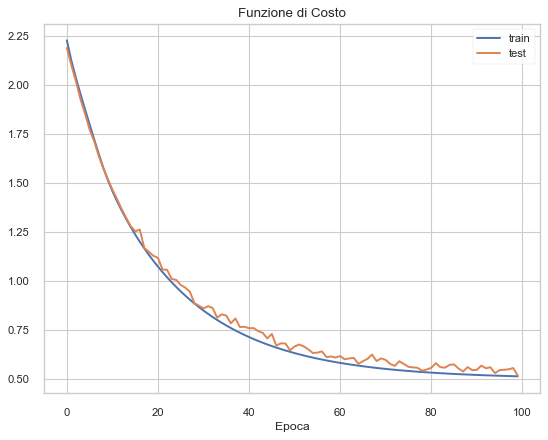

In [208]:
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.title('Funzione di Costo')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epoca')
plt.legend()
plt.show()

In [209]:
y_pred = model.predict(X_test)

# I convert predictions into binary classes (0 or 1) depending on a decision threshold
y_pred_classes = np.round(y_pred)

precision_nn = precision_score(Y_test, y_pred_classes)

recall_nn = recall_score(Y_test, y_pred_classes)

f1_nn = f1_score(Y_test, y_pred_classes)

print("Precision:", precision_nn)
print("Recall:", recall_nn)
print("F1-score:", f1_nn)

1544/1544 [==============================] - 5s 2ms/step
Precision: 0.21284694686756542
Recall: 0.8926829268292683
F1-score: 0.34373532550693703


In [210]:
auc_score_nn = roc_auc_score(Y_test, y_pred)
print("AUC score Neural Network: " + str(auc_score_nn))

AUC score Neural Network: 0.8347361027842422


# Conclusions

In conclusion, it can definitely be said that the models suffer greatly from the unbalance of the classes. In fact, from the analysis performed on an ideal (balanced) test set, the performance of the models appears to be very good compared to the case we are in.

The results of the various models are shown below 

### Real case

1)  GaussianNB                0.701541
2)  Soft Voting               0.695488
3)  Neural Network            0.688787
4)  Random Forest             0.682653
5)  Decision Tree             0.675304
6)  Gradient Boosting         0.675203
7)  Hard Voting               0.674332
8)  SGD_GS                    0.673320
9)  XGB                       0.671802
10) Logistic Regression       0.667753
11) L_SVC                     0.640545


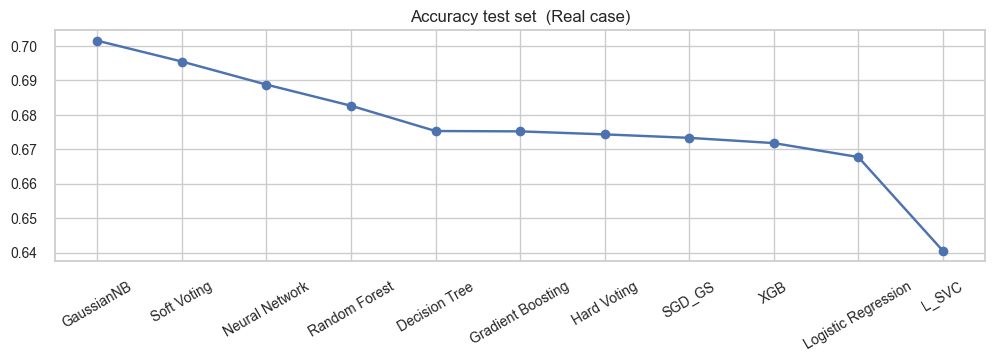

In [211]:
test_ac = [test_score_dt, test_score_sgd2, test_score_svc, test_score_lr, test_score_nb, test_score_rf, test_score_hard, test_score_soft, test_score_gb, test_score_xgb, accuracy_nn]
labels = ['Decision Tree', 'SGD_GS', 'L_SVC','Logistic Regression','GaussianNB','Random Forest','Hard Voting','Soft Voting','Gradient Boosting','XGB','Neural Network']

score_test = ordina_decrescente(labels, test_ac)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 3)

#caso reale

ax.plot(score_test[1],'bo-') 
ax.set_xticks([i for i in range(len(labels))]) 
ax.set_xticklabels(score_test[0], rotation=30, fontsize=10)

_=ax.set_title('Accuracy test set  (Real case)', fontsize=12)


for i in range(len(labels)): 
    if i < 9:
        print(str(i+1)+ ")  " + "{:<25} {:.6f}".format(score_test[0][i],score_test[1][i]))
    else:
        print(str(i+1)+ ") " + "{:<25} {:.6f}".format(score_test[0][i],score_test[1][i]))

The accuracy results on the test set are more or less similar for all models, so one could evaluate the recall and auc metrics with more weight, somewhat less for Logistic Regression and LinearSVC.

1)  L_SVC                     0.949002
2)  Logistic Regression       0.917738
3)  XGB                       0.911530
4)  Gradient Boosting         0.909534
5)  Hard Voting               0.908426
6)  Decision Tree             0.907317
7)  SGD_GS                    0.906874
8)  Neural Network            0.892683
9)  Random Forest             0.892018
10) Soft Voting               0.864967
11) GaussianNB                0.827716


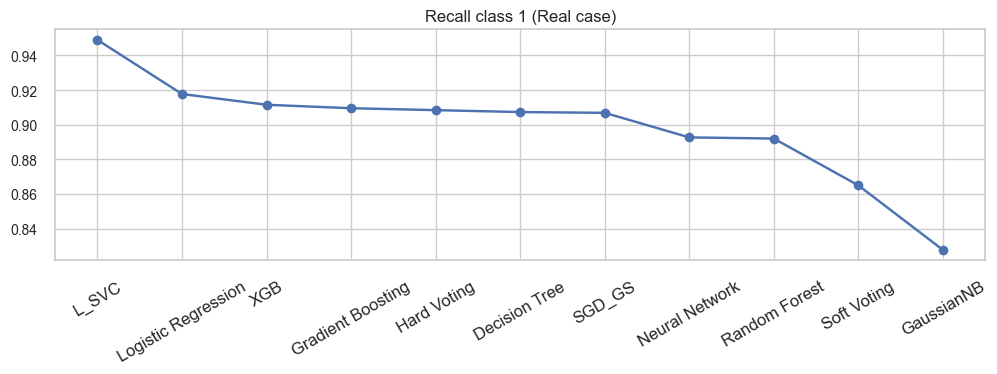

In [212]:
labels = ['Decision Tree', 'SGD_GS', 'L_SVC','Logistic Regression','GaussianNB','Random Forest','Hard Voting','Soft Voting','Gradient Boosting','XGB','Neural Network']
recall1 = [recall1_dt, recall1_sgdgs, recall1_svc, recall1_lr, recall1_nb, recall_rf, recall_hard, recall_soft, recall_gb, recall_xgb, recall_nn]

score_1 = ordina_decrescente(labels, recall1)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 3)

ax.plot(score_1[1],'bo-')

ax.set_xticks([i for i in range(len(labels))])

ax.set_xticklabels(score_1[0], rotation=30, fontsize=12)

_=ax.set_title('Recall class 1 (Real case)')

for i in range(len(labels)): 
    if i < 9:
        print(str(i+1)+ ")  " + "{:<25} {:.6f}".format(score_1[0][i],score_1[1][i]))
    else:
        print(str(i+1)+ ") " + "{:<25} {:.6f}".format(score_1[0][i],score_1[1][i]))

1)  Neural Network            0.343735
2)  Soft Voting               0.341534
3)  Random Forest             0.339179
4)  Gradient Boosting         0.338337
5)  Decision Tree             0.337861
6)  Hard Voting               0.337466
7)  XGB                       0.336498
8)  SGD_GS                    0.336390
9)  GaussianNB                0.336170
10) Logistic Regression       0.335277
11) L_SVC                     0.325277


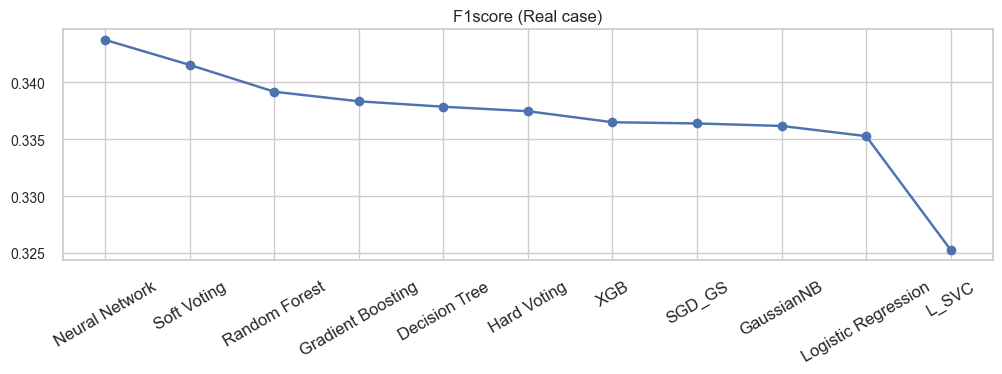

In [213]:
labels = ['Decision Tree', 'SGD_GS', 'L_SVC','Logistic Regression','GaussianNB','Random Forest','Hard Voting','Soft Voting','Gradient Boosting','XGB','Neural Network']
f1scores = [f1score1_dt, f1score1_sgdgs, f1score1_svc, f1score1_lr, f1score1_nb, f1score_rf, f1score_hard, f1score_soft, f1score_gb, f1score_xgb, f1_nn]

f1score1 = ordina_decrescente(labels, f1scores)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 3)

ax.plot(f1score1[1],'bo-')

ax.set_xticks([i for i in range(len(labels))])

ax.set_xticklabels(f1score1[0], rotation=30, fontsize=12)

_=ax.set_title('F1score (Real case)')

for i in range(len(labels)): 
    if i < 9:
        print(str(i+1)+ ")  " + "{:<25} {:.6f}".format(f1score1[0][i],f1score1[1][i]))
    else:
        print(str(i+1)+ ") " + "{:<25} {:.6f}".format(f1score1[0][i],f1score1[1][i]))

Here we notice very poor results for the F1Score metric, due to the unbalanced test set resulting in low values on precision. However, this is not a very negative factor for our analysis, since for the task under study, it is necessary to maximise recall rather than precision. We will see that with a balanced test set, precision values will rise and thus a consequent increase in the f1score.

1)  Neural Network            0.834736
2)  XGB                       0.834380
3)  Gradient Boosting         0.833600
4)  Decision Tree             0.833564
5)  Logistic Regression       0.830056
6)  SGD_GS                    0.829833
7)  Random Forest             0.829608
8)  L_SVC                     0.829554
9)  GaussianNB                0.804962
10) Hard Voting               0.779619
11) Soft Voting               0.771713


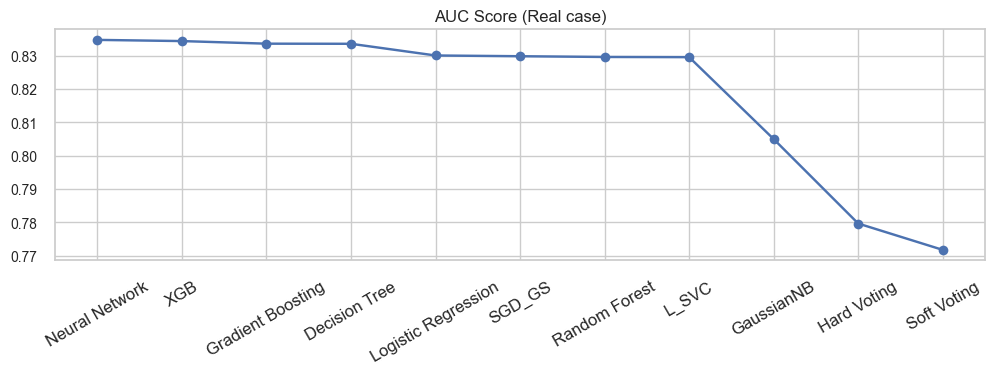

In [214]:
labels = ['Decision Tree', 'SGD_GS', 'L_SVC','Logistic Regression','GaussianNB','Random Forest','Hard Voting','Soft Voting','Gradient Boosting','XGB','Neural Network']
auc_score = [auc_score_dt, rocaucscoregs_sgd, auc_score_svc, auc_score_lr, auc_score_nb, auc_score_rf, auc_score_hard, auc_score_soft, auc_score_gb, auc_score_xgb, auc_score_nn]

aucscore = ordina_decrescente(labels, auc_score)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 3)

ax.plot(aucscore[1],'bo-')

ax.set_xticks([i for i in range(len(labels))])

ax.set_xticklabels(aucscore[0], rotation=30, fontsize=12)

_=ax.set_title('AUC Score (Real case)')

for i in range(len(labels)): 
    if i < 9:
        print(str(i+1)+ ")  " + "{:<25} {:.6f}".format(aucscore[0][i],aucscore[1][i]))
    else:
        print(str(i+1)+ ") " + "{:<25} {:.6f}".format(aucscore[0][i],aucscore[1][i]))

In the real case, considering all three metrics together certainly a good model is the neural network, XGB performs very well for Recall and AUC, Logistic regression among the last for accuracy but does not deviate much, while in the other metrics it has very satisfactory values, linearSVC also performs well (again slightly less for accuracy). Next we find Gradient Boosting, Decision Trees and the remaining models. I expected some better performance for the Voting algorithms.

### Ideal case (Balanced Test Set)

1)  Logistic Regression       0.780549
2)  Decision Tree             0.779970
3)  L_SVC                     0.779591
4)  SGD_GS                    0.778076
5)  Random Forest             0.776996
6)  GaussianNB                0.758315


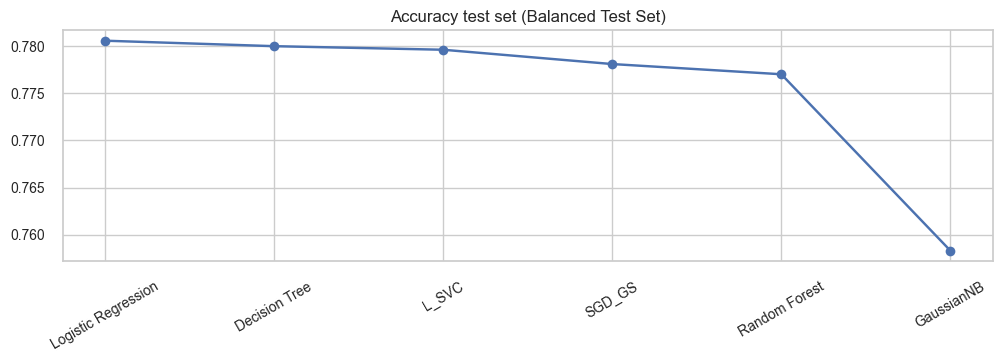

In [215]:
test_ac2 = [test_score_dt2, test_score_sgd3, test_score_svc2, test_score_lr2, test_score_nb2, test_score_rf2]
labels = ['Decision Tree', 'SGD_GS', 'L_SVC','Logistic Regression','GaussianNB','Random Forest']

score_test = ordina_decrescente(labels, test_ac2)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 3)

ax.plot(score_test[1],'bo-') 
ax.set_xticks([i for i in range(len(labels))]) 
ax.set_xticklabels(score_test[0], rotation=30, fontsize=10)

_=ax.set_title('Accuracy test set (Balanced Test Set)', fontsize=12)

for i in range(len(labels)): 
    if i < 9:
        print(str(i+1)+ ")  " + "{:<25} {:.6f}".format(score_test[0][i],score_test[1][i]))
    else:
        print(str(i+1)+ ") " + "{:<25} {:.6f}".format(score_test[0][i],score_test[1][i]))

1)  L_SVC                     0.949696
2)  Logistic Regression       0.918462
3)  Decision Tree             0.907947
4)  SGD_GS                    0.906874
5)  Random Forest             0.892486
6)  GaussianNB                0.827768


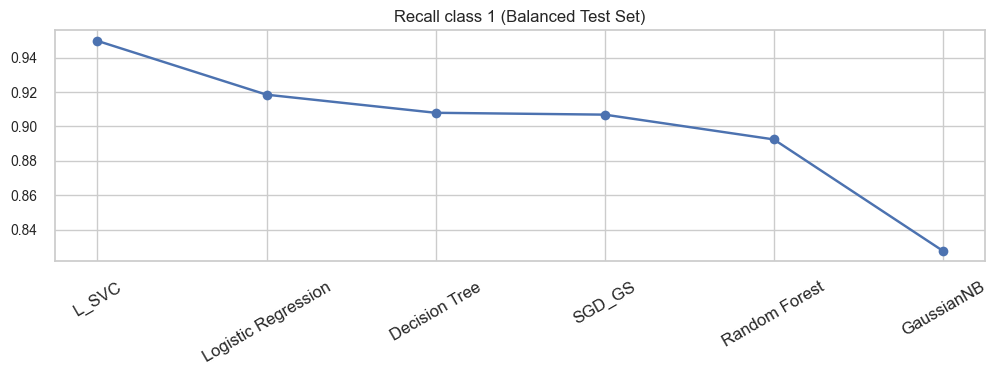

In [216]:
labels = ['Decision Tree', 'SGD_GS', 'L_SVC','Logistic Regression','GaussianNB','Random Forest']
recall1 = [recall1_dt2, recall1_sgdgs, recall1_svc2, recall1_lr2, recall1_nb2, recall2]

score_1 = ordina_decrescente(labels, recall1)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 3)

ax.plot(score_1[1],'bo-')

ax.set_xticks([i for i in range(len(labels))])

ax.set_xticklabels(score_1[0], rotation=30, fontsize=12)

_=ax.set_title('Recall class 1 (Balanced Test Set)')

for i in range(len(labels)): 
    if i < 9:
        print(str(i+1)+ ")  " + "{:<25} {:.6f}".format(score_1[0][i],score_1[1][i]))
    else:
        print(str(i+1)+ ") " + "{:<25} {:.6f}".format(score_1[0][i],score_1[1][i]))

1)  L_SVC                     0.811633
2)  Logistic Regression       0.807146
3)  Decision Tree             0.804934
4)  SGD_GS                    0.803515
5)  Random Forest             0.800084
6)  GaussianNB                0.774011


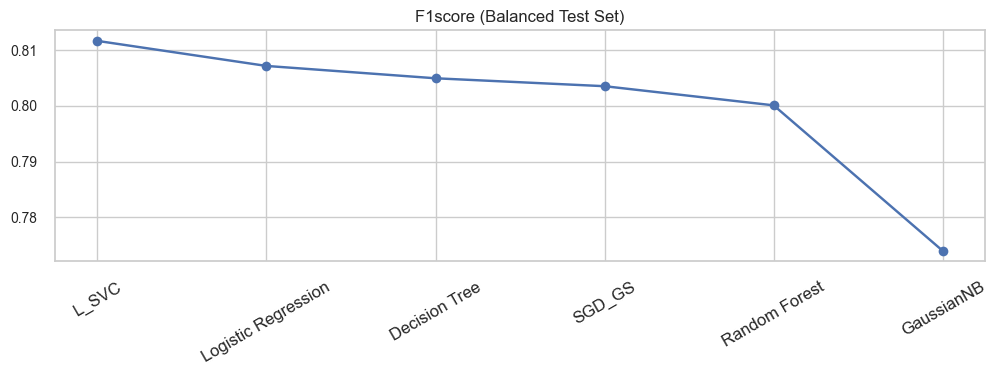

In [217]:
labels = ['Decision Tree', 'SGD_GS', 'L_SVC','Logistic Regression','GaussianNB','Random Forest']
f1scores = [f1score1_dt2, f1score1_sgd2, f1score1_svc2, f1score1_lr2, f1score1_nb2, f1score2]

f1score1 = ordina_decrescente(labels, f1scores)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 3)

ax.plot(f1score1[1],'bo-')

ax.set_xticks([i for i in range(len(labels))])

ax.set_xticklabels(f1score1[0], rotation=30, fontsize=12)

_=ax.set_title('F1score (Balanced Test Set)')

for i in range(len(labels)): 
    if i < 9:
        print(str(i+1)+ ")  " + "{:<25} {:.6f}".format(f1score1[0][i],f1score1[1][i]))
    else:
        print(str(i+1)+ ") " + "{:<25} {:.6f}".format(f1score1[0][i],f1score1[1][i]))

As anticipated, the f1score values are much higher now that the test set is balanced

1)  Decision Tree             0.833750
2)  Logistic Regression       0.830840
3)  L_SVC                     0.830271
4)  SGD_GS                    0.829833
5)  Random Forest             0.828702
6)  GaussianNB                0.804832


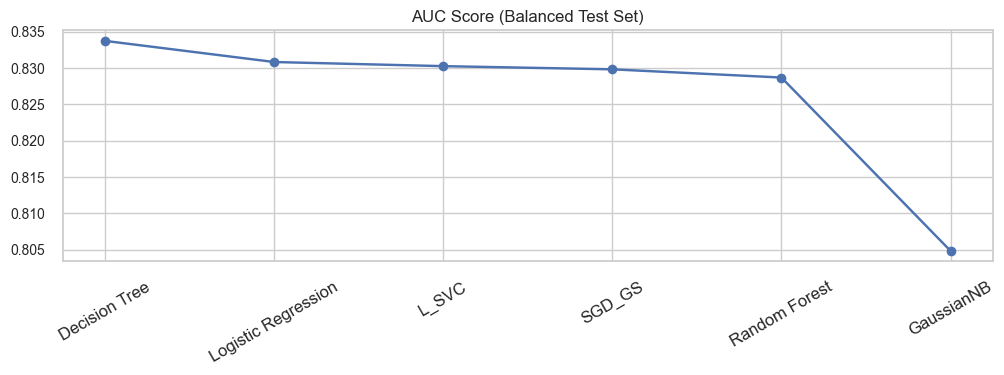

In [218]:
labels = ['Decision Tree', 'SGD_GS', 'L_SVC','Logistic Regression','GaussianNB','Random Forest']
auc_score = [auc_score_dt2, rocaucscoregs_sgd, auc_score_svc2, auc_score_lr2, auc_score_nb2, auc_score_rf2]

aucscore = ordina_decrescente(labels, auc_score)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 3)

ax.plot(aucscore[1],'bo-')

ax.set_xticks([i for i in range(len(labels))])

ax.set_xticklabels(aucscore[0], rotation=30, fontsize=12)

_=ax.set_title('AUC Score (Balanced Test Set)')

for i in range(len(labels)): 
    if i < 9:
        print(str(i+1)+ ")  " + "{:<25} {:.6f}".format(aucscore[0][i],aucscore[1][i]))
    else:
        print(str(i+1)+ ") " + "{:<25} {:.6f}".format(aucscore[0][i],aucscore[1][i]))

As you can see, an ideal condition is to have a balanced test set. We obtained significantly higher performance values!

*Marco Greco - University of Calabria - Master's degree Computer Engineering - Artificial Intelligence & Machine learning*

Contacts: 

https://www.linkedin.com/in/marcogreco314/

https://github.com/marcogreco99

mrcgreco@icloud.com